In [4]:
import os

import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap


/Users/coletonwatt/Developer/MATH 4750/Math4750 Final Project Data Modeling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

base_model = joblib.load('./Data/gridSearch_rf.pickle')
balanced_model = joblib.load('./Data/gridSearch_rf_balanced.pickle')
imbalanced_model = joblib.load('./Data/gridSearch_rf_imbalanced.pickle')

best_models: dict = {"base": base_model.best_estimator_, "balanced": balanced_model.best_estimator_, "imbalanced": imbalanced_model.best_estimator_}

best_models

{'base': Pipeline(steps=[('ct',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['IUCR', 'Domestic', 'Beat',
                                                    'District', 'Ward',
                                                    'Community Area', 'FBI Code',
                                                    'Latitude', 'Longitude']),
                                                  ('desc', TargetEncoder(),
                                                   ['Description',
                                                    'Location Description']),
                                                  ('date', StandardScaler(),
                                                   ['Date'])])),
                 ('clf', RandomForestClassifier(max_depth=6, n_estimators=500))]),
 'balanced': Pipeline(steps=[('ct',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                     

In [6]:
X_test = pd.read_pickle('Data/X_test.pickle')
y_test = pd.read_pickle('Data/y_test.pickle')
X_test


Date  IUCR                           Description  \
117061 2022-09-15 11:00:00  2820                      TELEPHONE THREAT   
157179 2022-07-06 16:00:00   820                        $500 AND UNDER   
152162 2022-09-05 09:25:00  2820                      TELEPHONE THREAT   
189475 2022-12-17 18:00:00   810                             OVER $500   
34891  2022-05-05 08:10:00   486               DOMESTIC BATTERY SIMPLE   
...                    ...   ...                                   ...   
115031 2022-05-07 10:00:00   810                             OVER $500   
144941 2022-04-27 15:37:00   820                        $500 AND UNDER   
50652  2022-07-08 11:33:00   502  VEHICLE TITLE / REGISTRATION OFFENSE   
177756 2022-10-15 08:00:00   820                        $500 AND UNDER   
116045 2022-04-29 21:00:00   890                         FROM BUILDING   

                          Location Description  Domestic  Beat  District  \
117061                               APARTMENT         0  1115        11   
157179  PARKING LOT / GARAGE (NON RESIDENTIAL)         0  1712        17   
152162                               APARTMENT         0   332         3   
189475                         APPLIANCE STORE         0  1712        17   
34891                                APARTMENT         1   531         5   
...                                        ...       ...   ...       ...   
115031                               APARTMENT         0  1235        12   
144941                               APARTMENT         0   232         2   
50652                                   STREET         0   223         2   
177756                               WAREHOUSE         0  1133        11   
116045                              RESTAURANT         0  1834        18   

        Ward  Community Area  FBI Code   Latitude  Longitude  
117061  28.0              26         8  41.881944 -87.734105  
157179  40.0              13         6  41.975753 -87.707980  
152162   5.0              43         8  41.769149 -87.584423  
189475  35.0              14         6  41.968248 -87.727395  
34891    9.0              49         8  41.692742 -87.612855  
...      ...             ...       ...        ...        ...  
115031  25.0              31         6  41.855709 -87.657577  
144941  20.0              40         6  41.786632 -87.620638  
50652    4.0              38        26  41.803386 -87.611313  
177756  28.0              27         6  41.876036 -87.714438  
116045  42.0               8         6  41.891679 -87.627552  

[46847 rows x 12 columns]

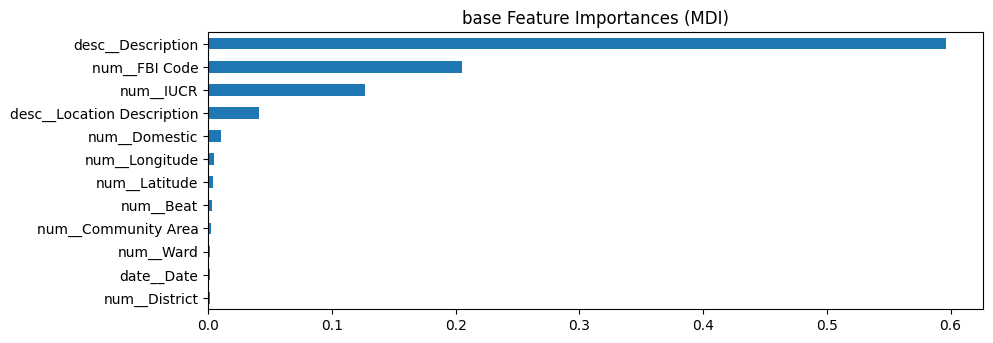

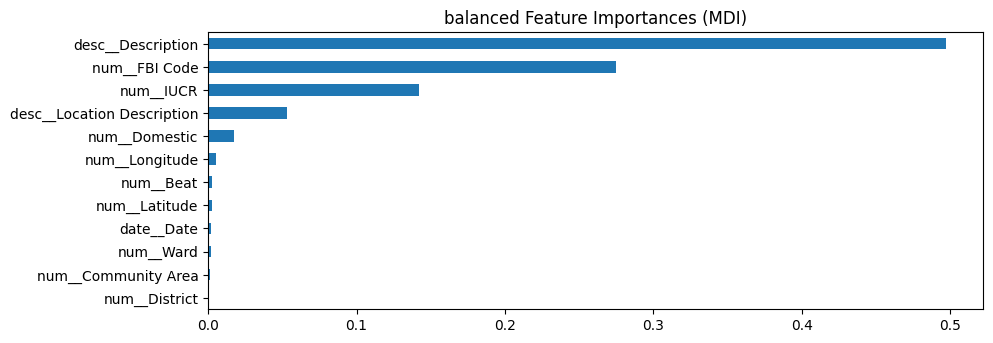

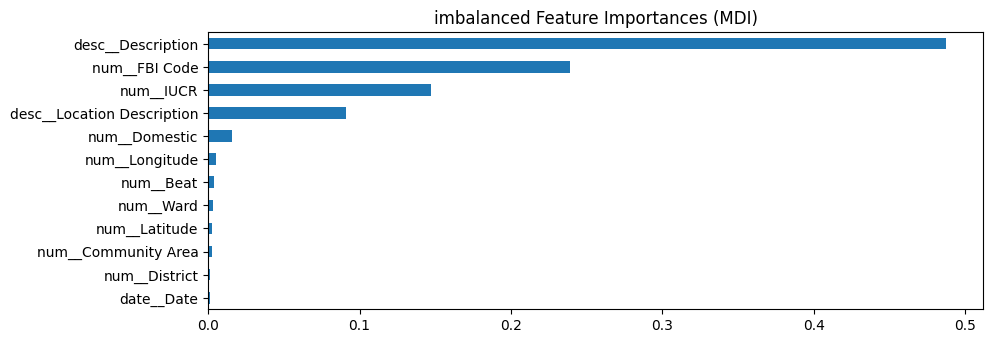

In [4]:
for key, best_model in best_models.items():
    model=best_model.named_steps['clf']
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    # Get the transformed feature names
    mdi_importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=True)

    # Set figure size to increase spacing
    plt.figure(figsize=(10, len(mdi_importances) * 0.3))  # Adjust the height based on the number of features

    # Plot the importances
    ax = mdi_importances.plot.barh()
    ax.set_title(f"{key} Feature Importances (MDI)")

    # Optionally, you can increase the font size for y-axis labels
    ax.tick_params(axis='y', labelsize=10)  # Adjust labelsize for readability
    plt.savefig(f'Graphs/{key}_feature_importance.jpg', format='jpeg', dpi=300, bbox_inches ='tight')
    plt.show()

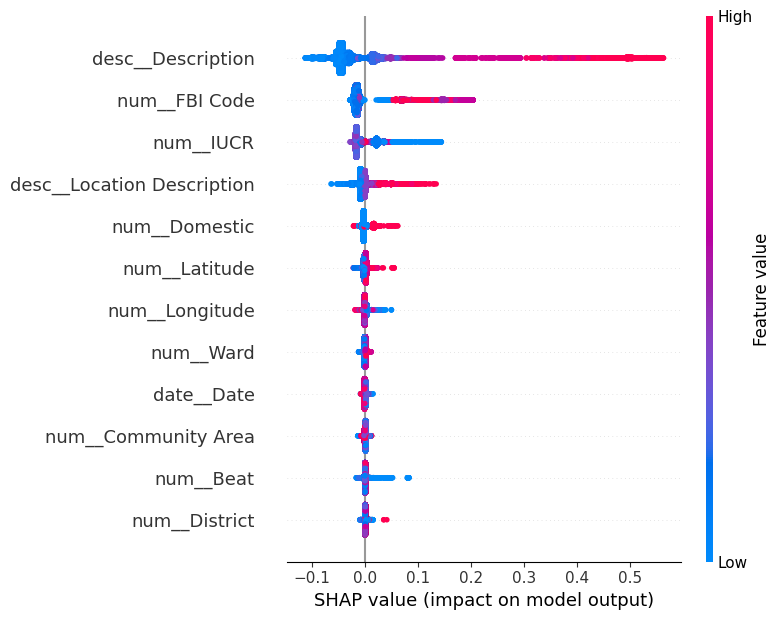

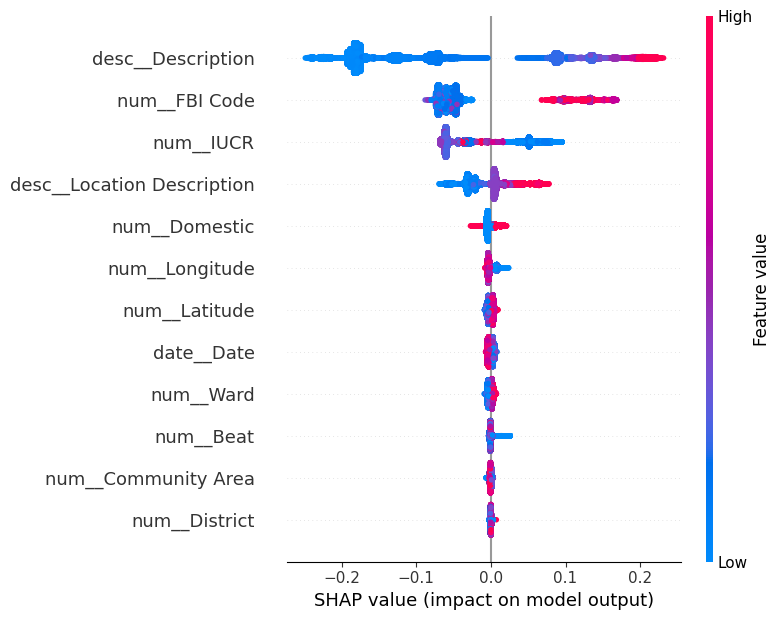

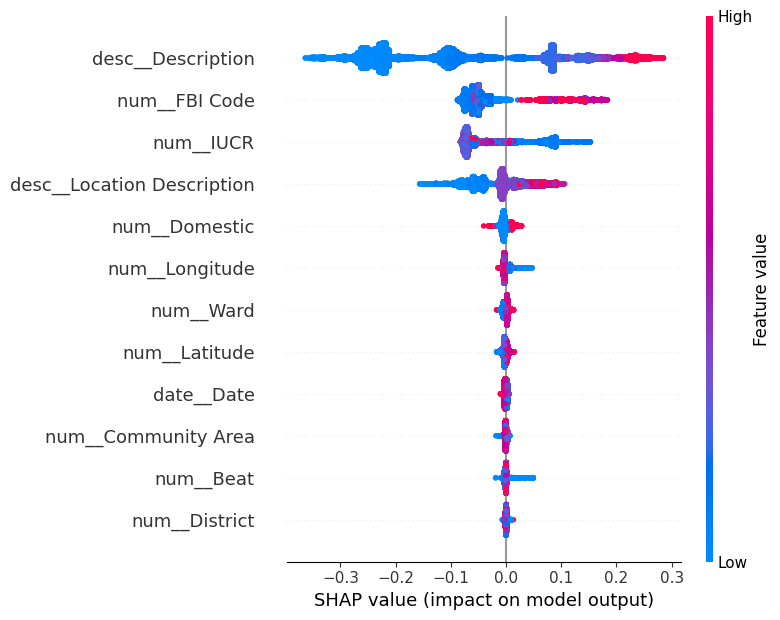

In [5]:
for key, best_model in best_models.items():
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    model=best_model.named_steps['clf']
    x_val_transformed = best_model.named_steps['ct'].transform(X_test)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_val_transformed)
    shap.summary_plot(shap_values[:,:,1,], x_val_transformed, feature_names=feature_names, show=False)
    plt.savefig(f'Graphs/{key}_shap_impact.jpg', format='jpeg', dpi=300, bbox_inches ='tight')
    plt.show()

In [6]:
# shap.dependence_plot('Alm', shap_values[:,:,1], x_val_transformed_name)
for key, best_model in best_models.items():
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    model=best_model.named_steps['clf']
    x_val_transformed_name = pd.DataFrame(best_model.named_steps['ct'].transform(X_test), columns=feature_names)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_val_transformed_name)

    # Create directory for saving plots
    output_dir = f'Graphs/{key}_shap_dependence'
    os.makedirs(output_dir, exist_ok=True)
    
    for feature in feature_names:
        plt.figure()  # Explicitly create a new figure
        shap.dependence_plot(feature, shap_values[:,:,1], x_val_transformed_name, show=False)
        plt.savefig(f'{output_dir}/{feature}.jpg', format='jpeg', dpi=300, bbox_inches ='tight')
        # plt.show()
        plt.close()  # Close the plot to free up memory

    

/Users/coletonwatt/Developer/MATH 4750/Math4750 Final Project Data Modeling/.venv/lib/python3.12/site-packages/shap/plots/_scatter.py:579: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = pl.figure(figsize=figsize)
/var/folders/1q/yvy8f7x573v6gq0wpf2grhx40000gn/T/ipykernel_67465/2417158977.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()  # Explicitly create a new figure


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
shap.initjs()

In [8]:
rows_selection = [1,2,3,4,5,6,7,8,9,10]

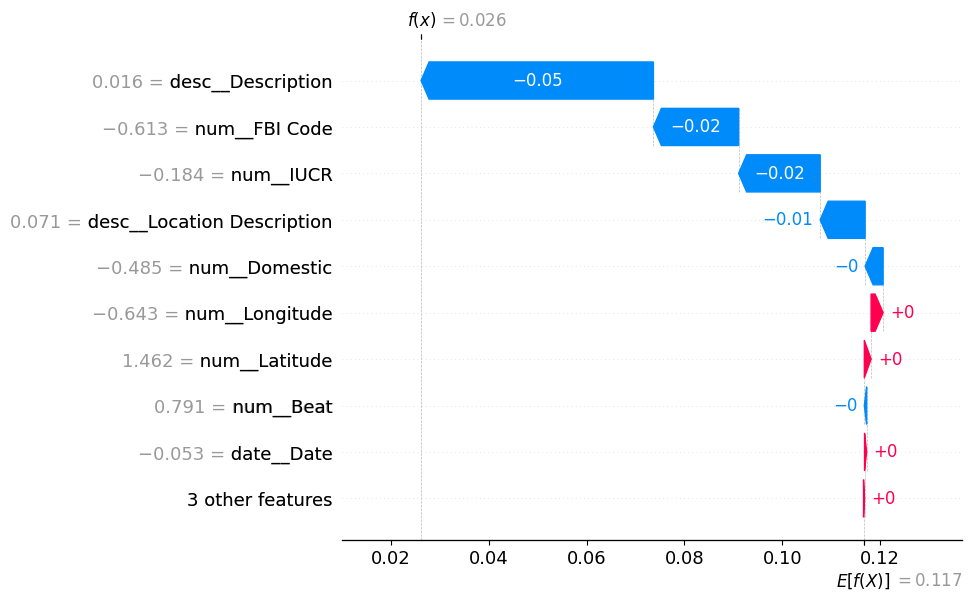

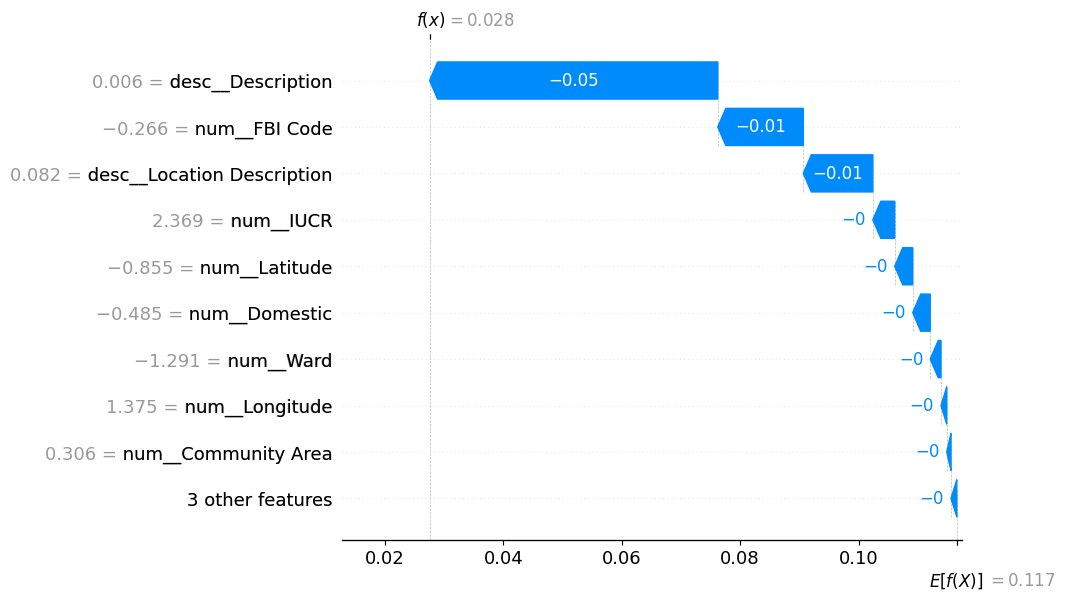

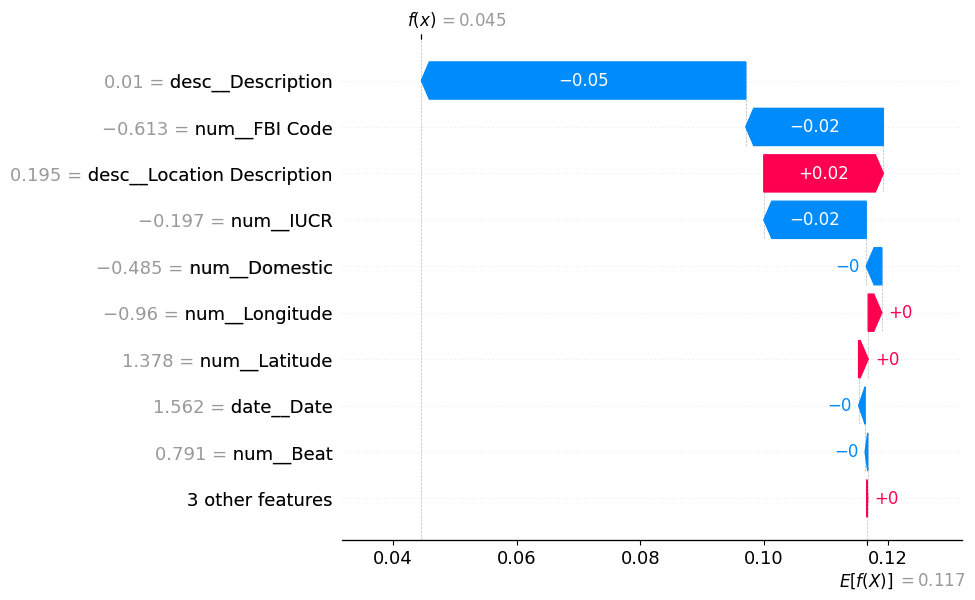

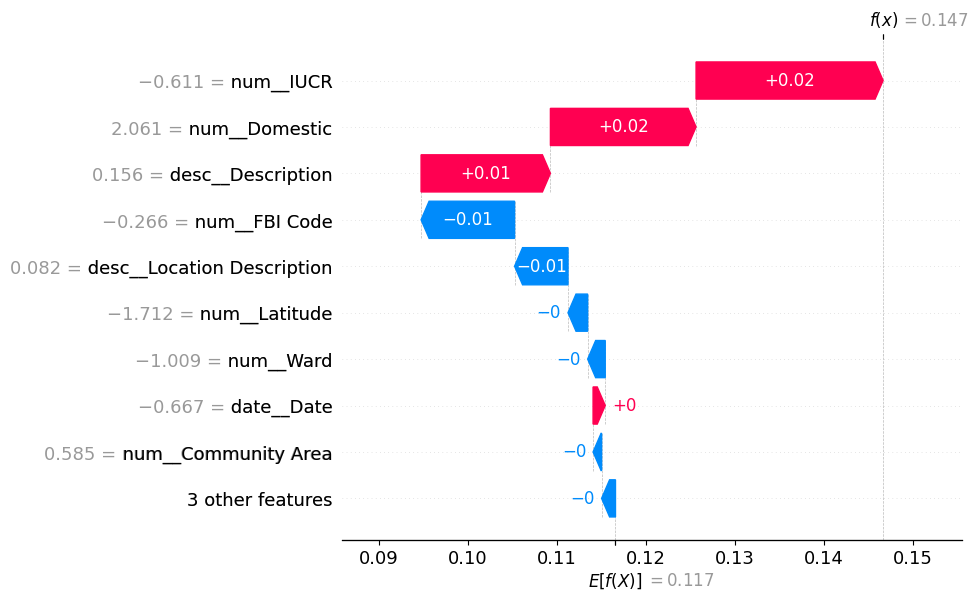

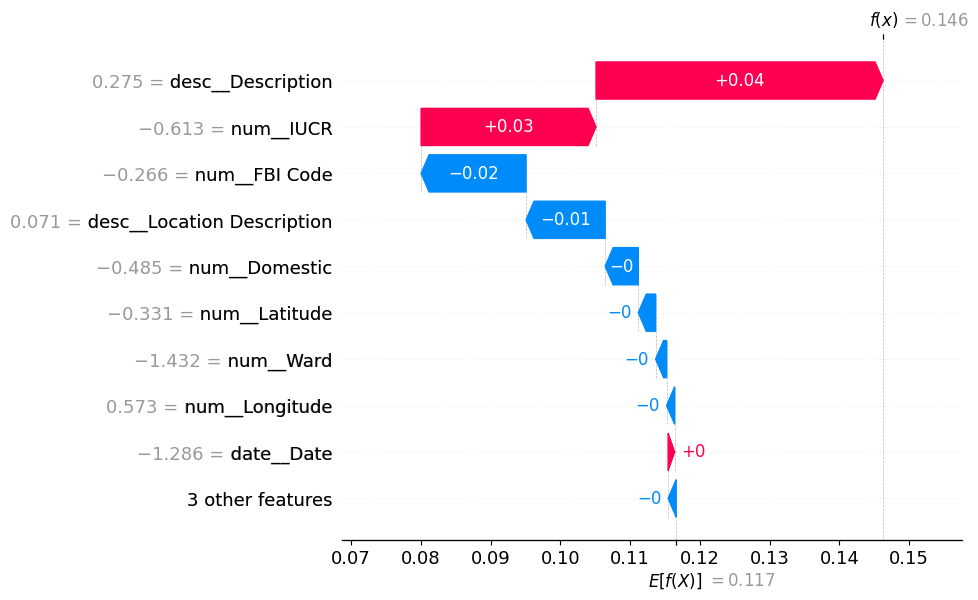

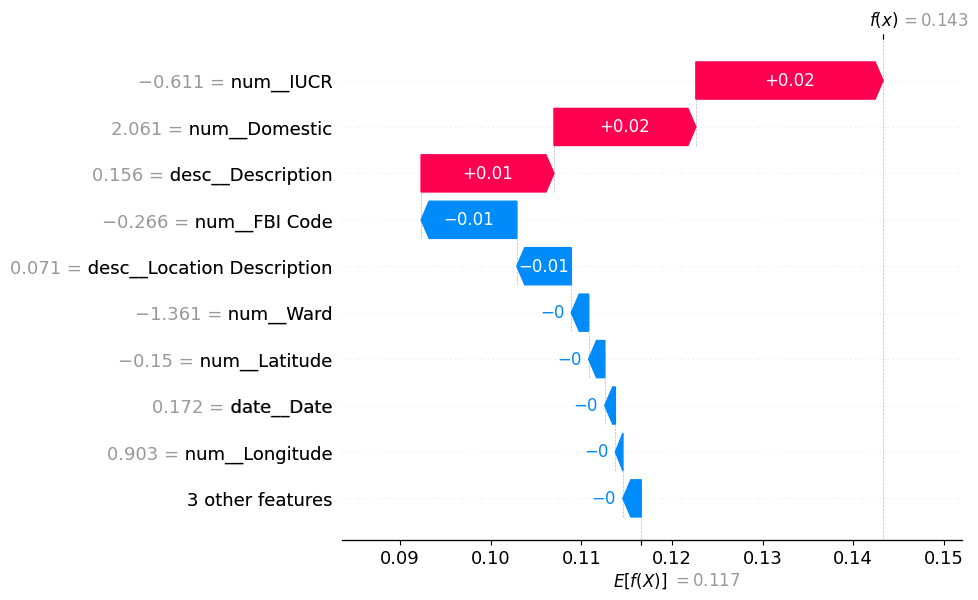

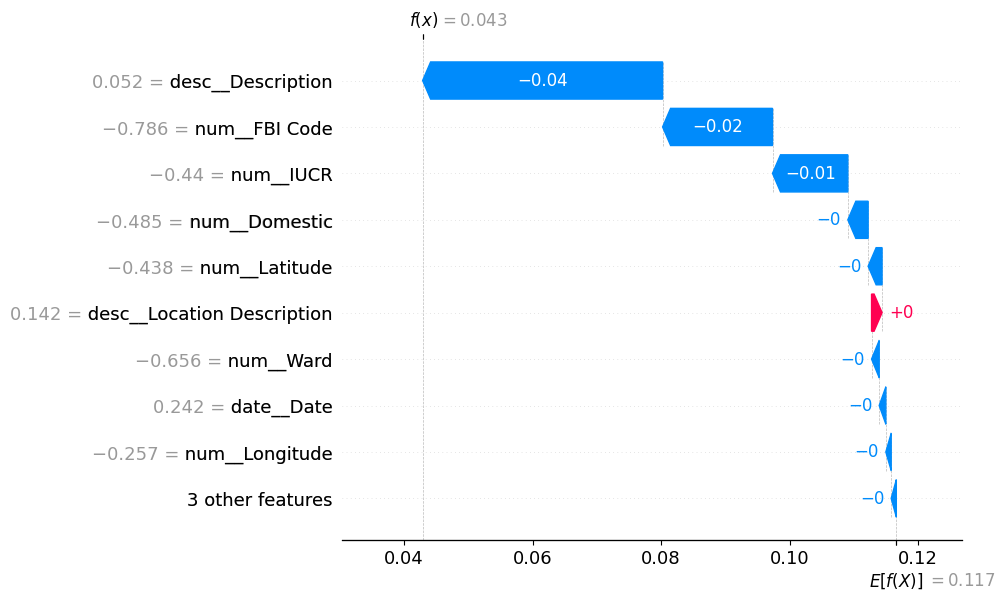

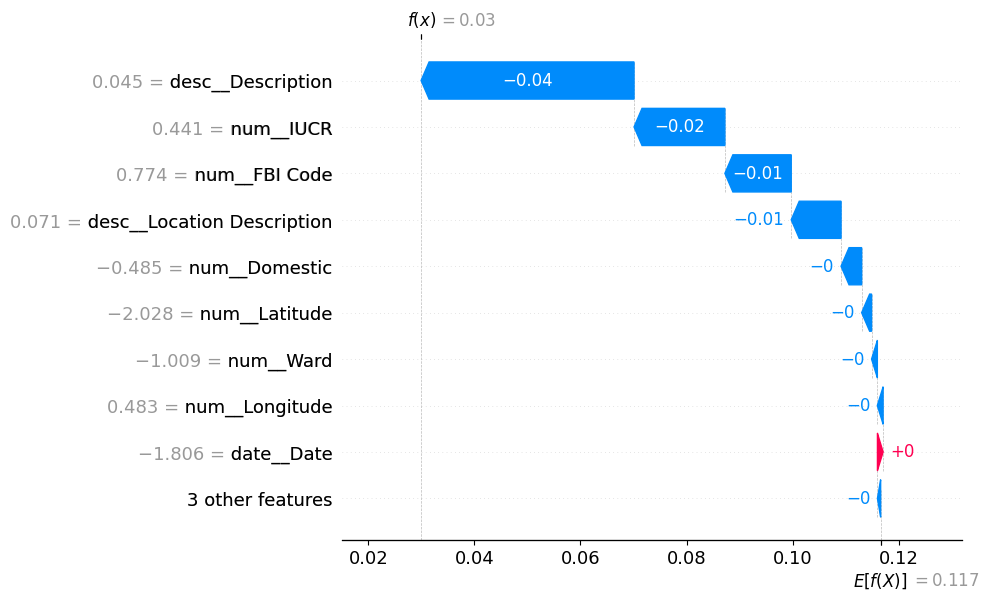

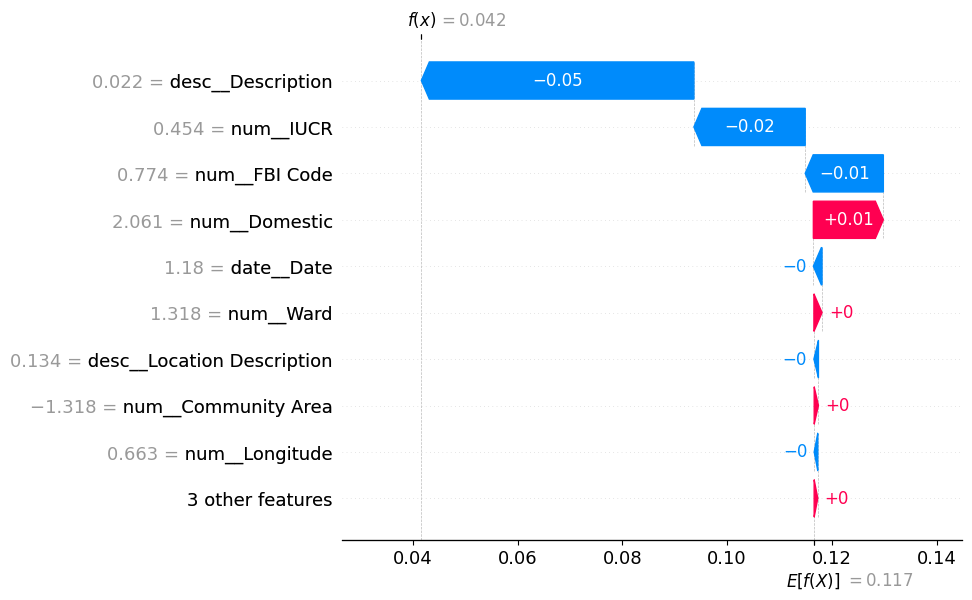

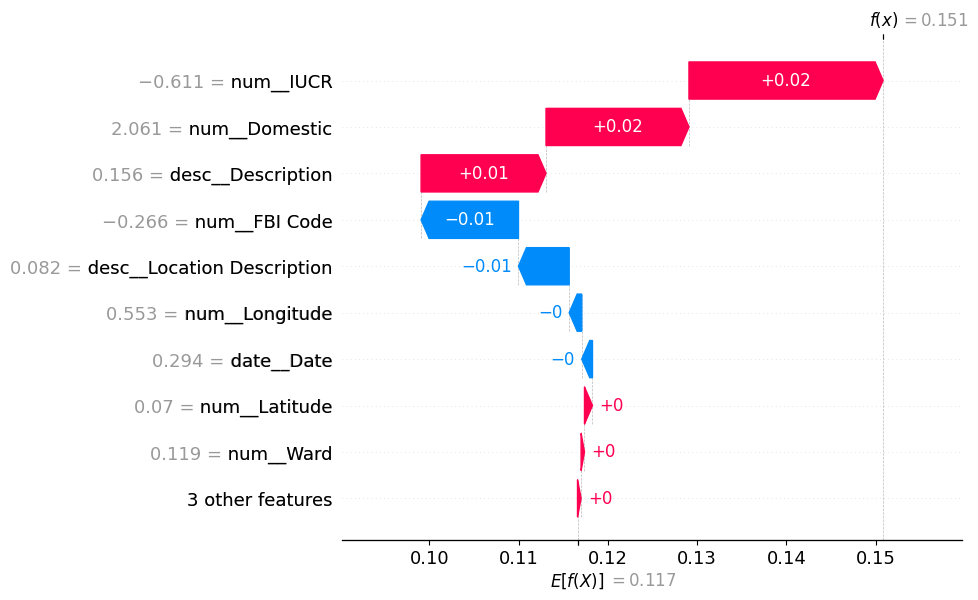

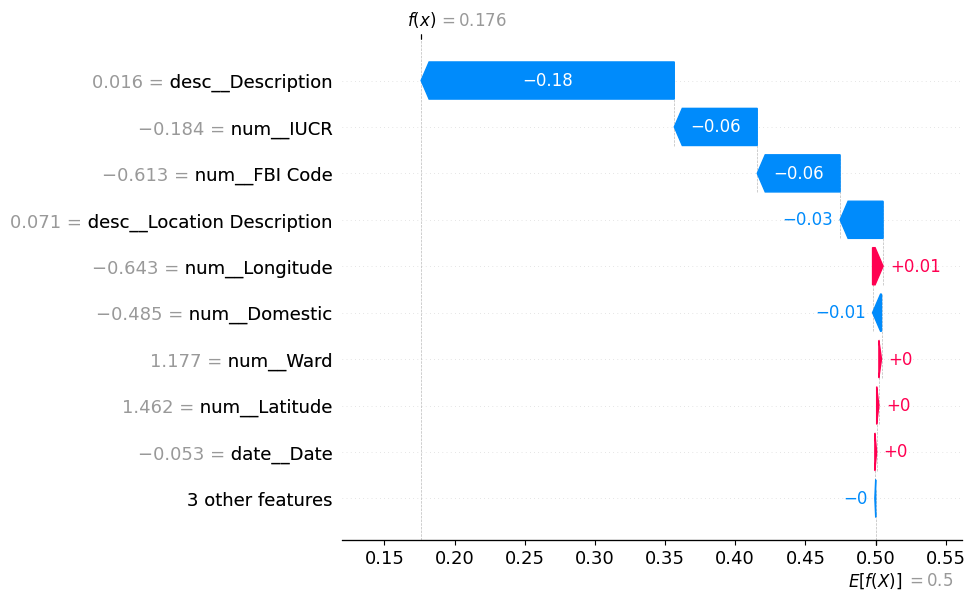

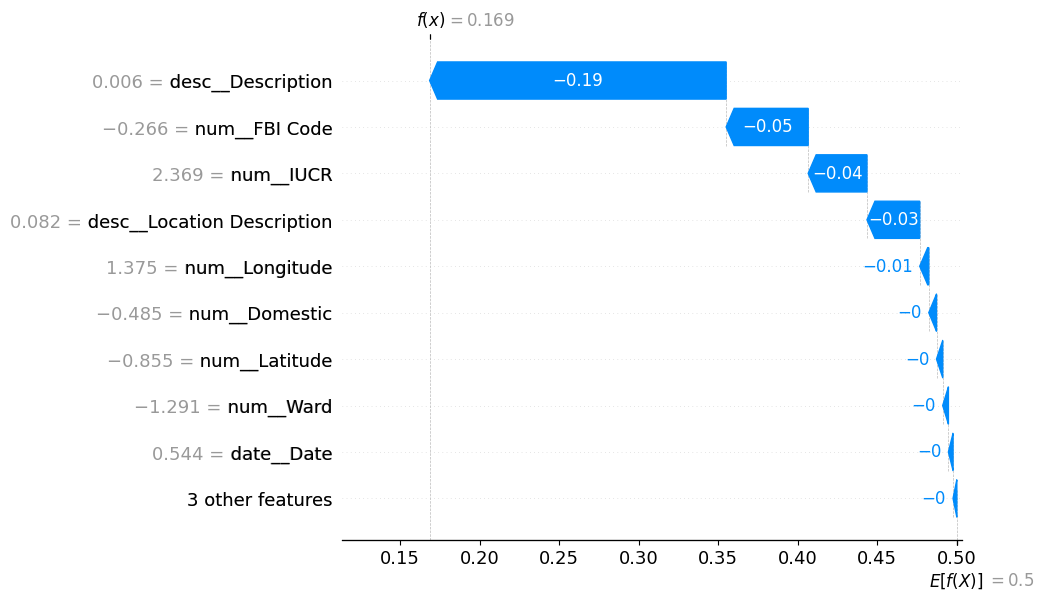

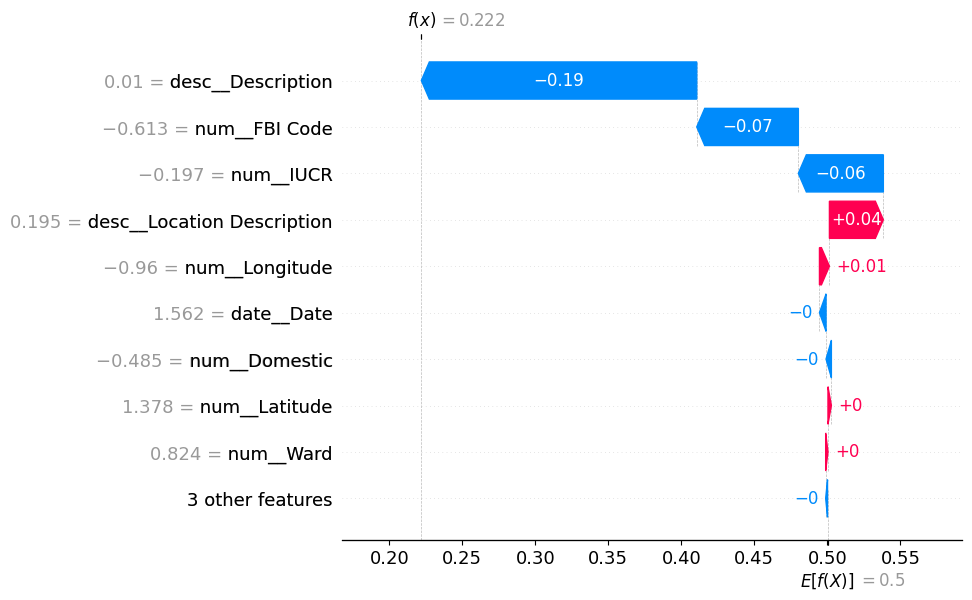

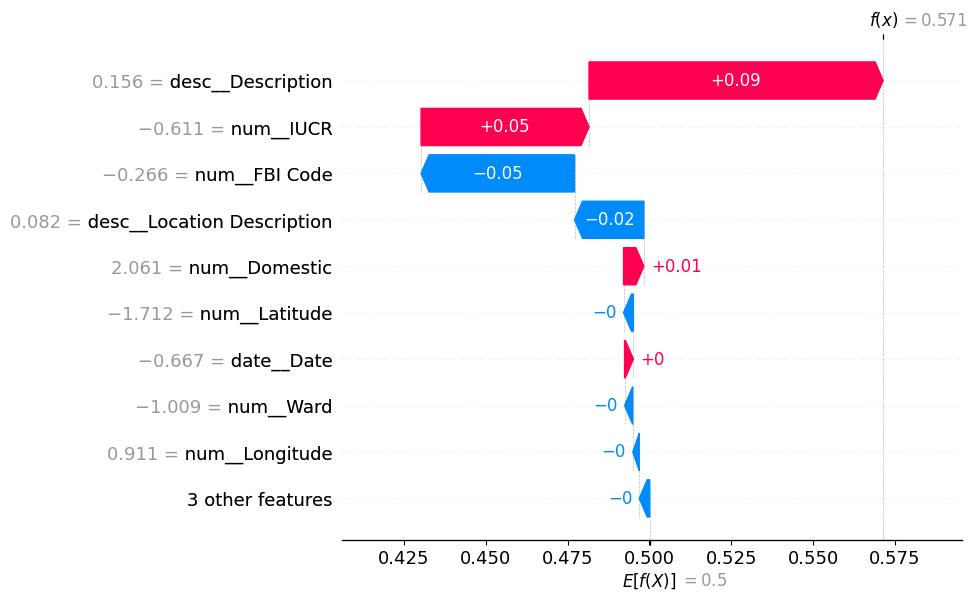

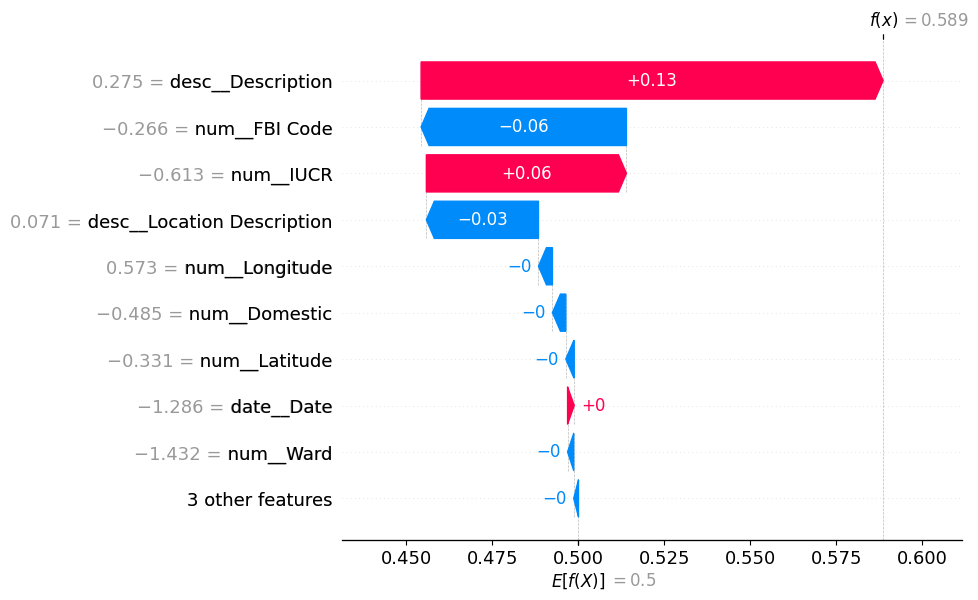

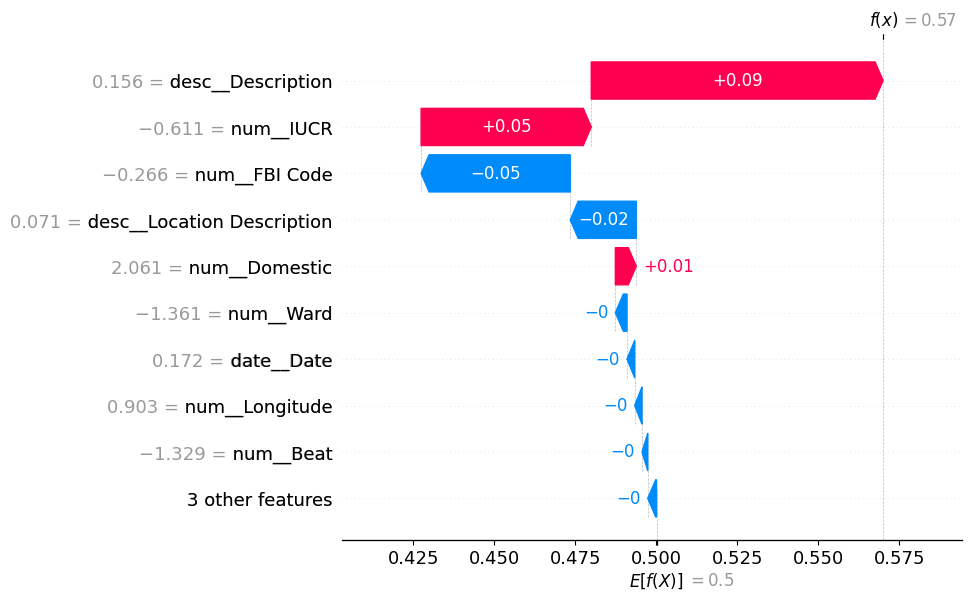

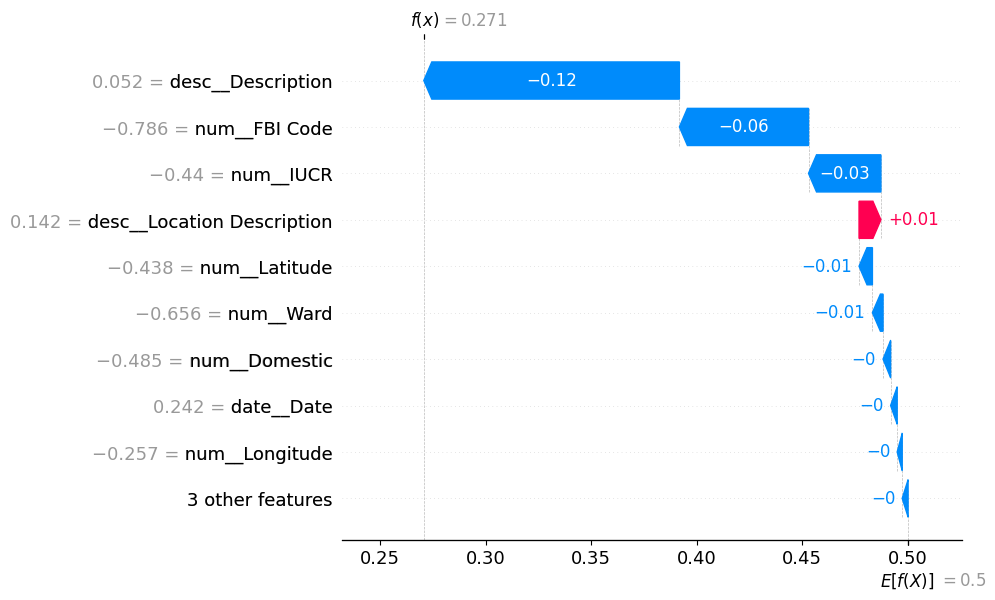

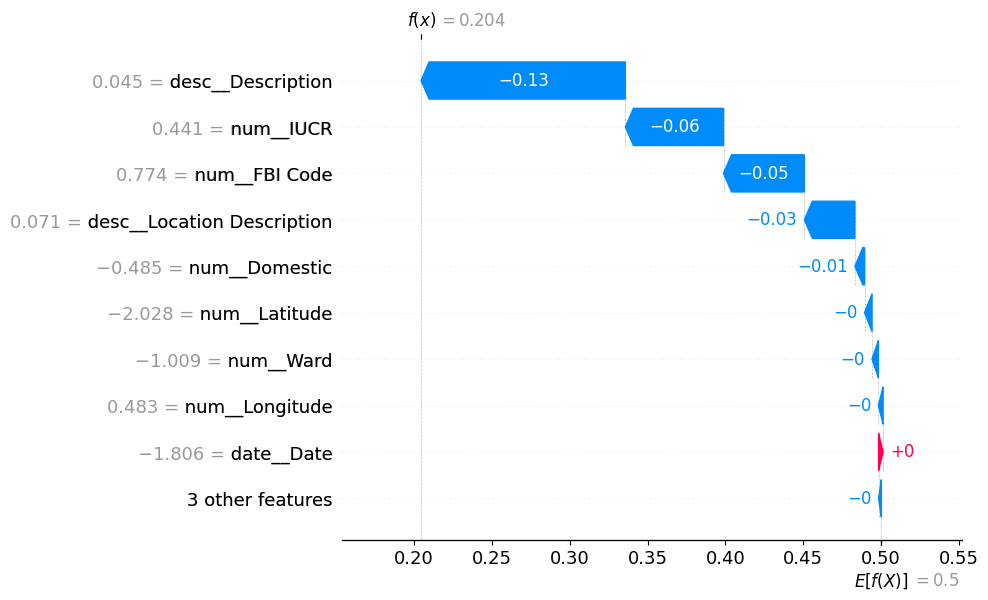

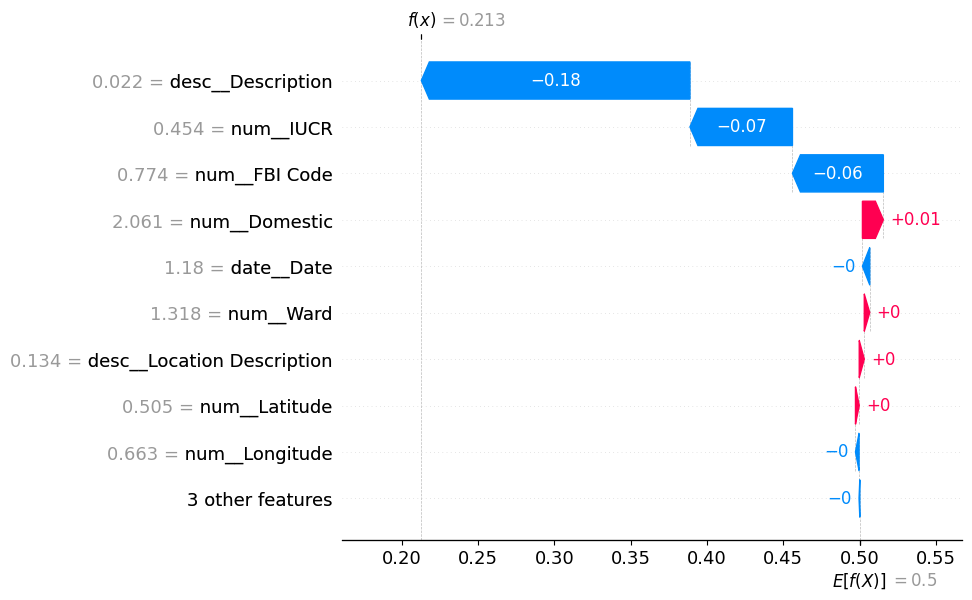

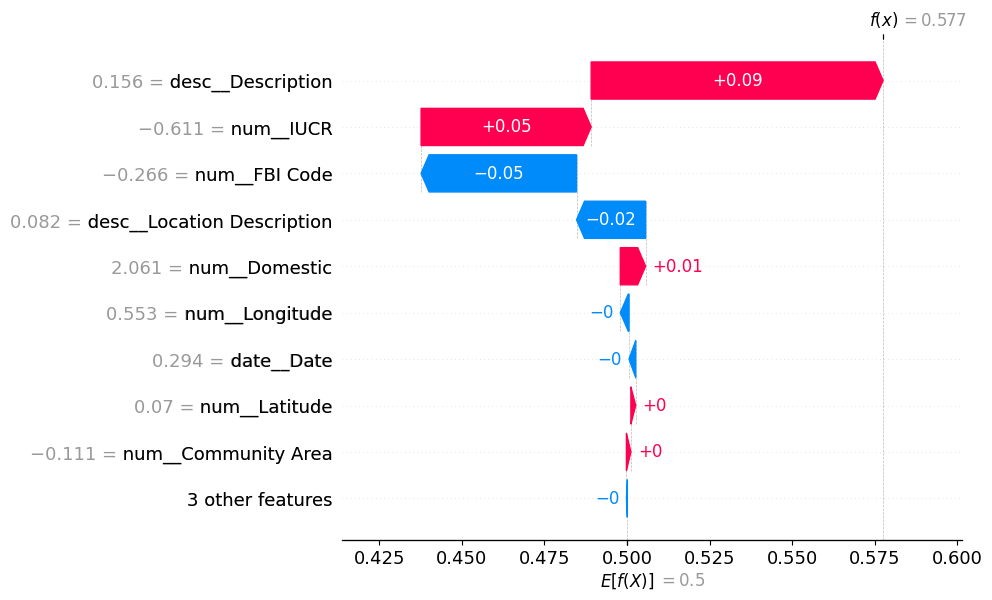

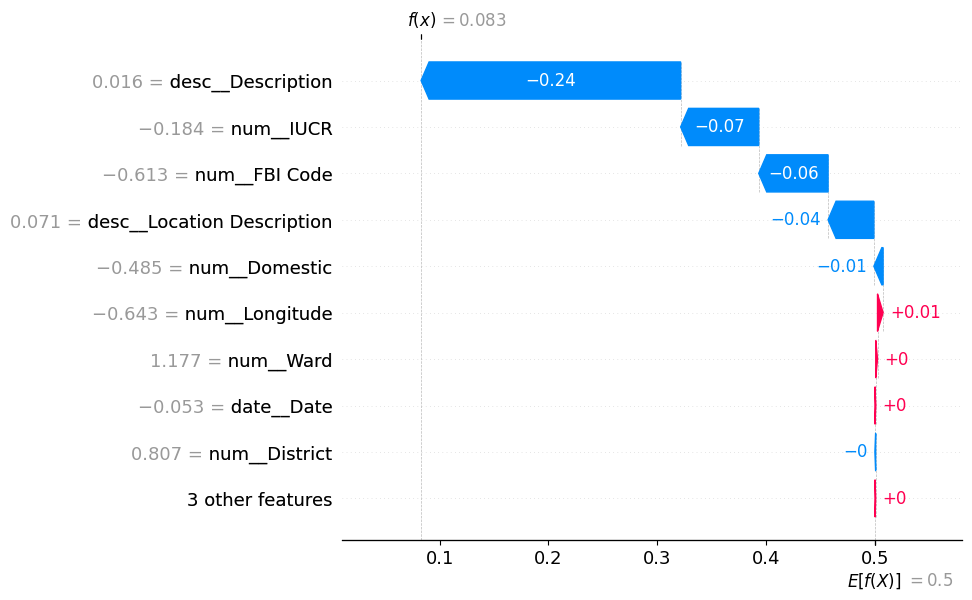

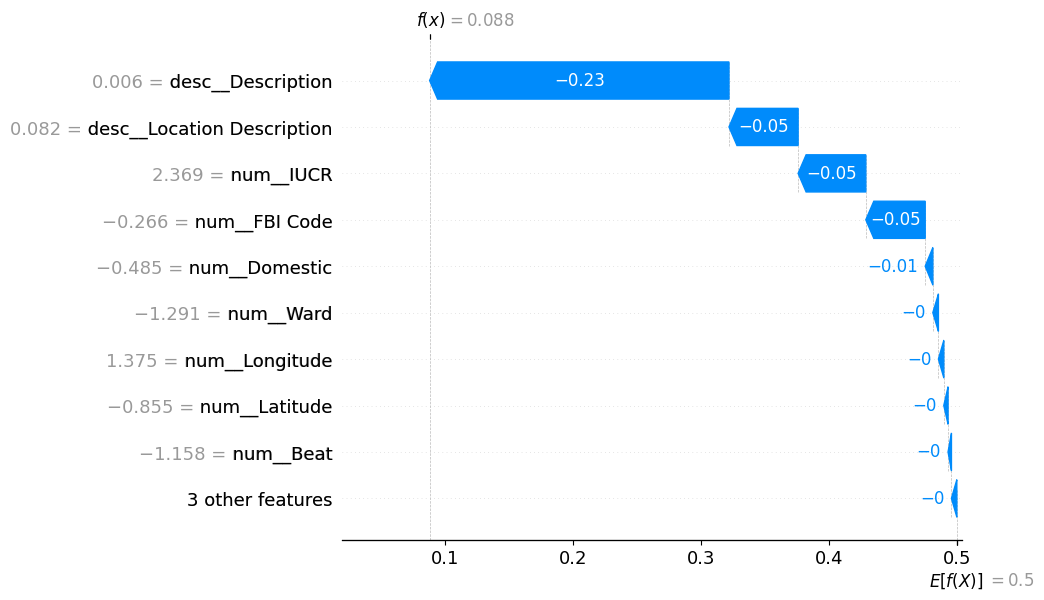

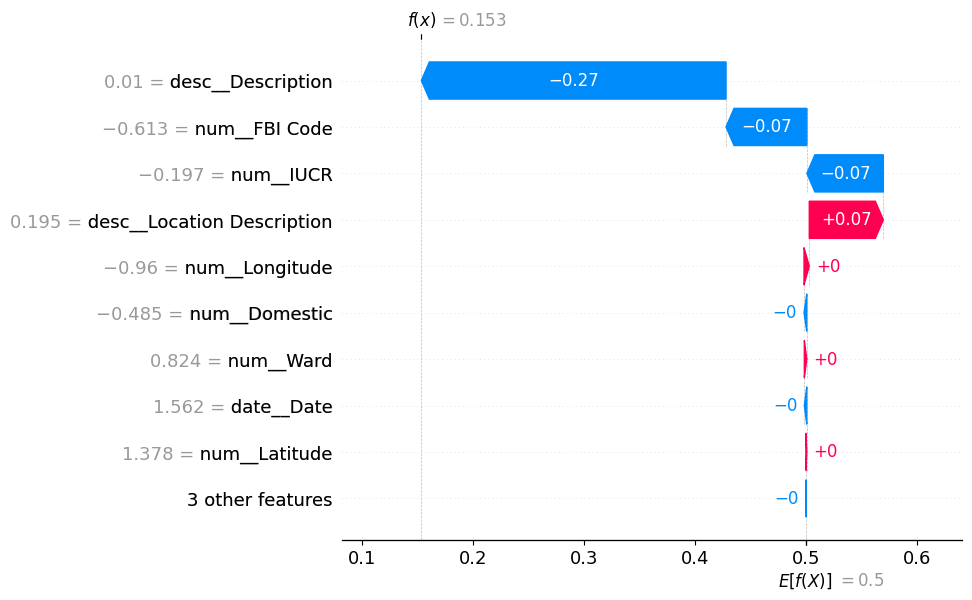

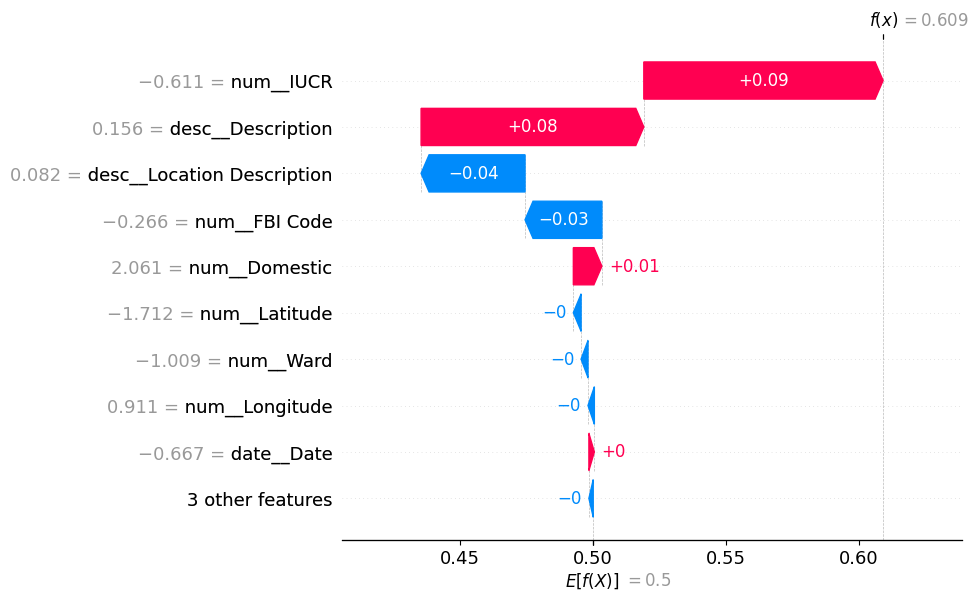

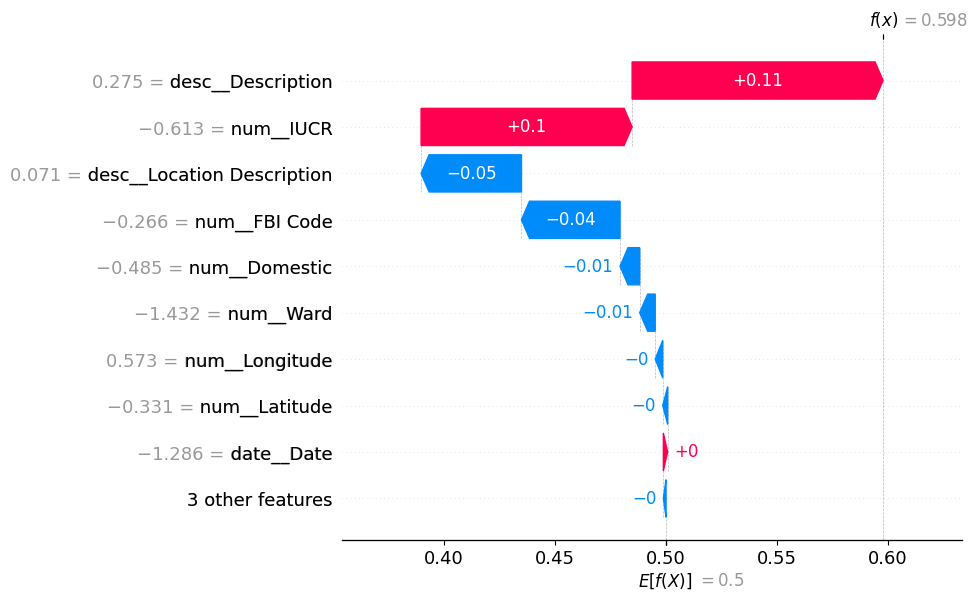

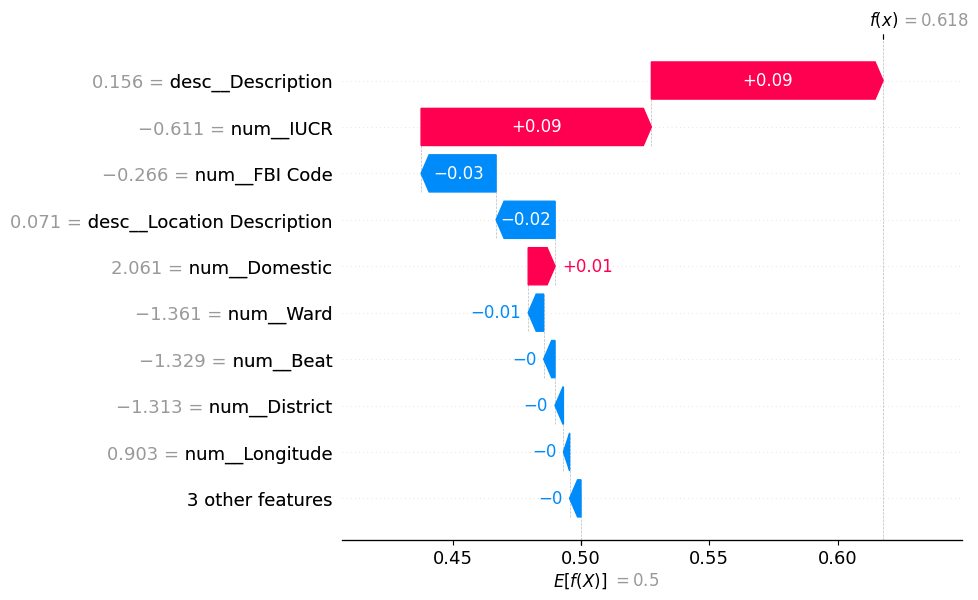

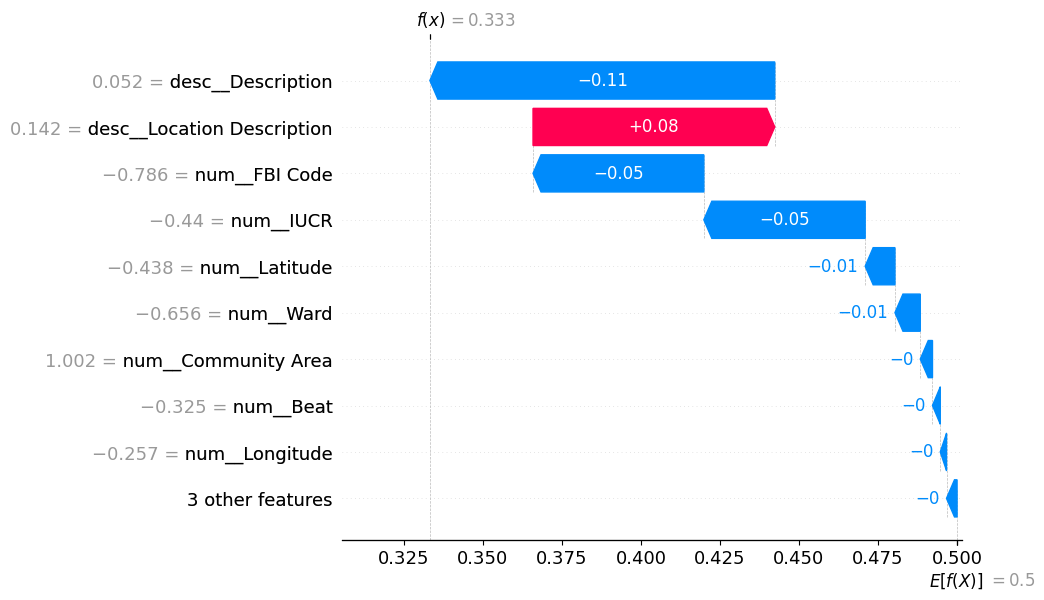

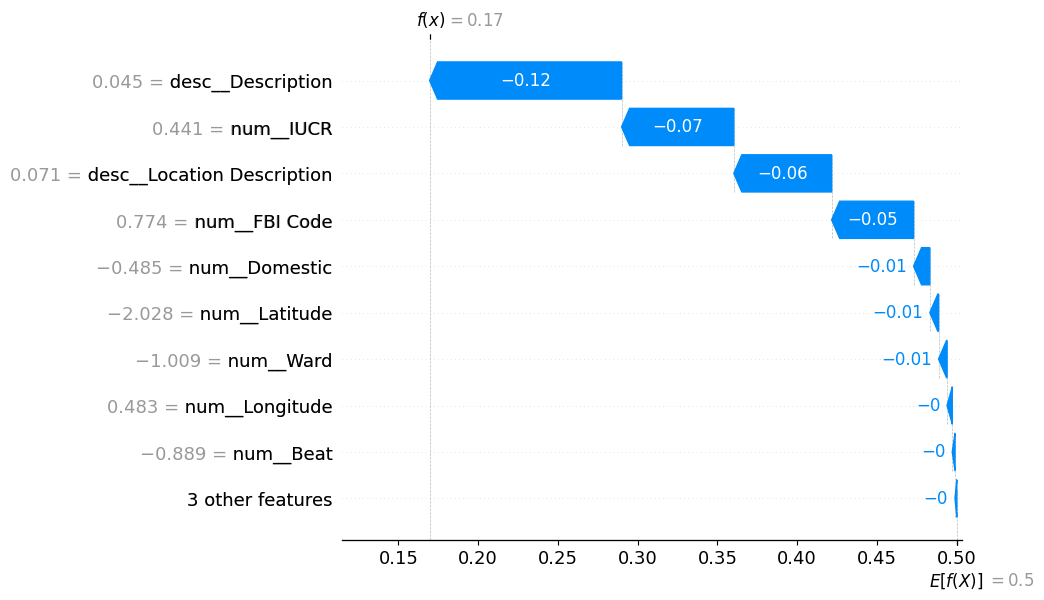

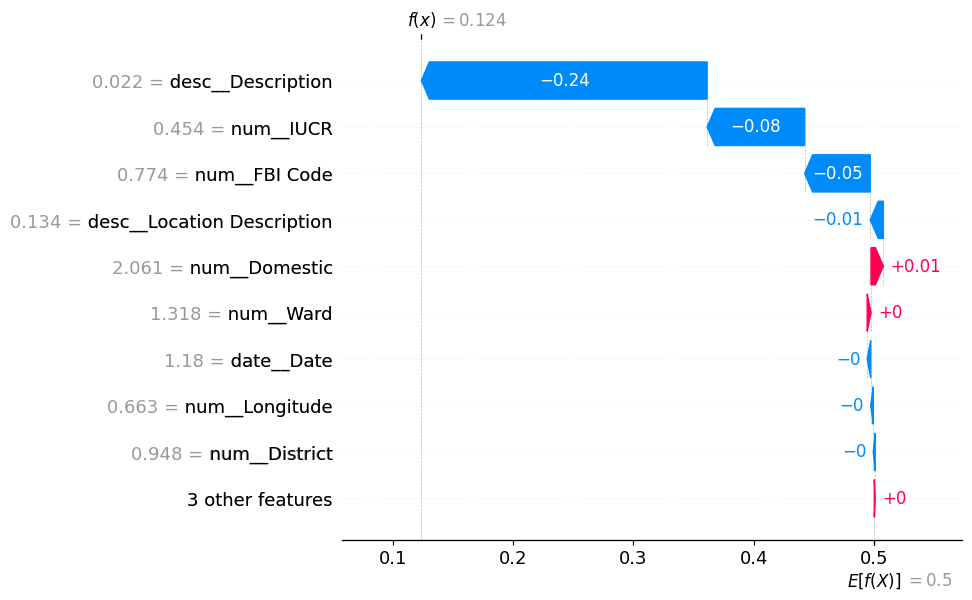

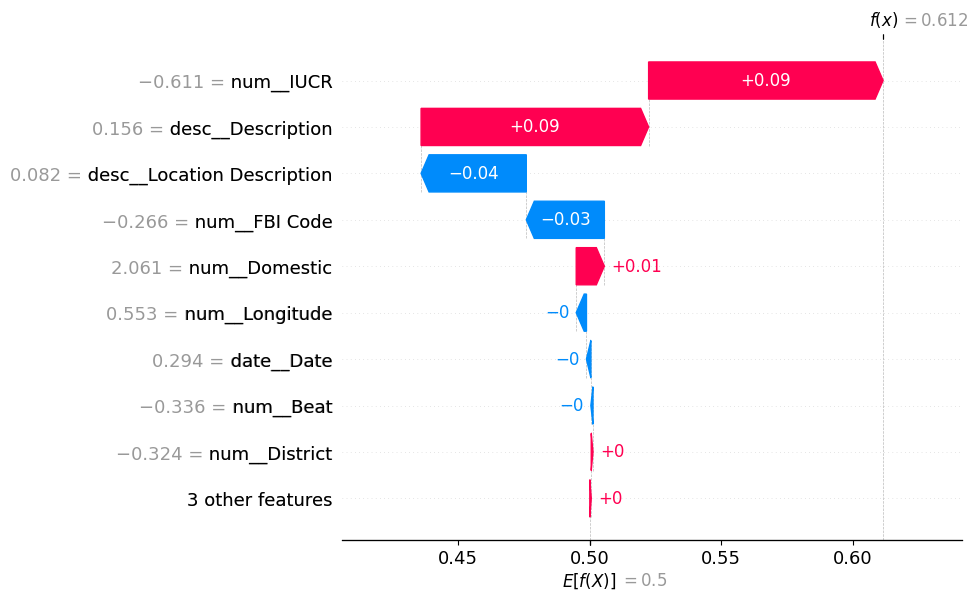

In [9]:
for key, best_model in best_models.items():
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    model=best_model.named_steps['clf']
    x_val_transformed_name = pd.DataFrame(best_model.named_steps['ct'].transform(X_test), columns=feature_names)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_val_transformed_name)

    # Create directory for saving plots
    output_dir = f'Graphs/{key}_waterfall_plot'
    os.makedirs(output_dir, exist_ok=True)
    
    for row in rows_selection:
        fig = plt.figure(figsize=(6, 3.3))
        explanation5 = shap.Explanation(
            values=shap_values[row, :, 1],  # Select SHAP values for the specific class
            base_values=explainer.expected_value[1],  # Use expected value for the same class
            #feature_names=X_test.columns,
            data=x_val_transformed_name.iloc[row, :]
        )
        shap.plots.waterfall(explanation5)
        fig.tight_layout()
        fig.savefig(f'{output_dir}/Details{row}.jpg', format='jpeg', dpi=300, bbox_inches='tight')

In [14]:
rows_selection = [1]

In [31]:
import pandas as pd

# Combine X_test and y_test
test_data = pd.concat([pd.DataFrame(X_test), pd.Series(y_test, name='target')], axis=1)

print(test_data)
# Save as CSV
test_data.to_csv('test_data.csv', index=False)


                      Date  IUCR                           Description  \
117061 2022-09-15 11:00:00  2820                      TELEPHONE THREAT   
157179 2022-07-06 16:00:00   820                        $500 AND UNDER   
152162 2022-09-05 09:25:00  2820                      TELEPHONE THREAT   
189475 2022-12-17 18:00:00   810                             OVER $500   
34891  2022-05-05 08:10:00   486               DOMESTIC BATTERY SIMPLE   
...                    ...   ...                                   ...   
115031 2022-05-07 10:00:00   810                             OVER $500   
144941 2022-04-27 15:37:00   820                        $500 AND UNDER   
50652  2022-07-08 11:33:00   502  VEHICLE TITLE / REGISTRATION OFFENSE   
177756 2022-10-15 08:00:00   820                        $500 AND UNDER   
116045 2022-04-29 21:00:00   890                         FROM BUILDING   

                          Location Description  Domestic  Beat  District  \
117061                             

In [1]:
confirmed_arrest = [16,23,44, 12000]

num__IUCR                    -0.554538
num__Domestic                 2.060617
num__Beat                    -1.315139
num__District                -1.313016
num__Ward                    -1.431854
num__Community Area           0.074341
num__FBI Code                -0.959291
num__Latitude                -0.341419
num__Longitude                0.979097
desc__Description             0.108981
desc__Location Description    0.134030
date__Date                   -0.114355
Name: 16, dtype: float64


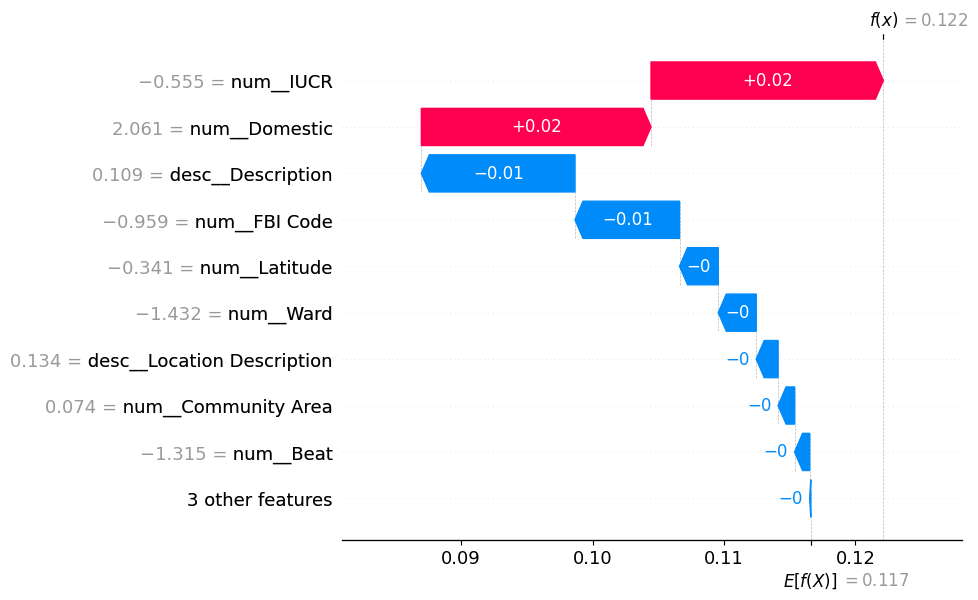

num__IUCR                    -0.197092
num__Domestic                -0.485291
num__Beat                     0.958947
num__District                 0.947979
num__Ward                     1.317834
num__Community Area          -1.317896
num__FBI Code                -0.612652
num__Latitude                 0.535872
num__Longitude                0.554772
desc__Description             0.010454
desc__Location Description    0.140329
date__Date                   -1.121565
Name: 23, dtype: float64


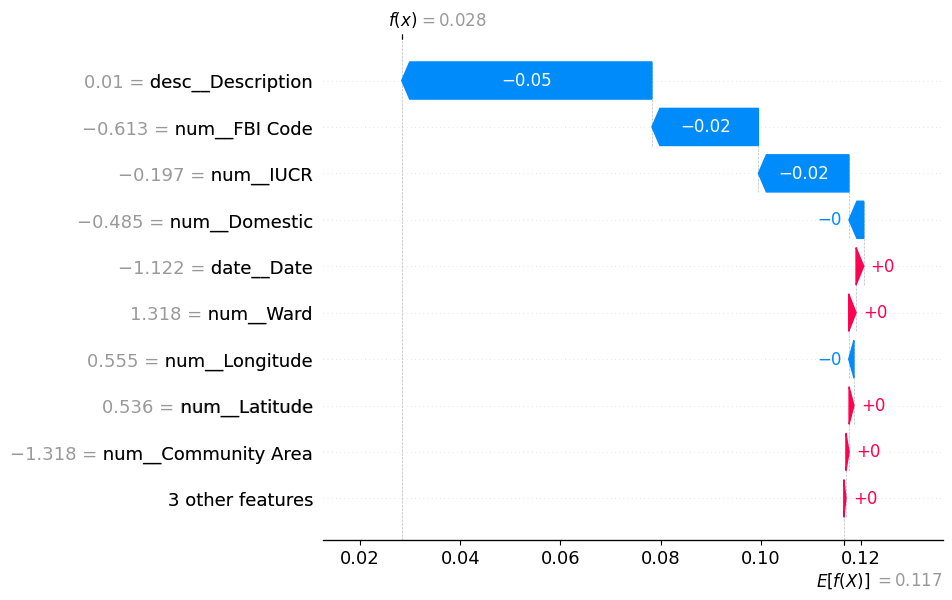

num__IUCR                    -0.133262
num__Domestic                -0.485291
num__Beat                     0.946235
num__District                 0.947979
num__Ward                     0.260262
num__Community Area          -1.317896
num__FBI Code                -0.612652
num__Latitude                 0.657204
num__Longitude                0.414742
desc__Description             0.168312
desc__Location Description    0.207521
date__Date                   -0.497166
Name: 44, dtype: float64


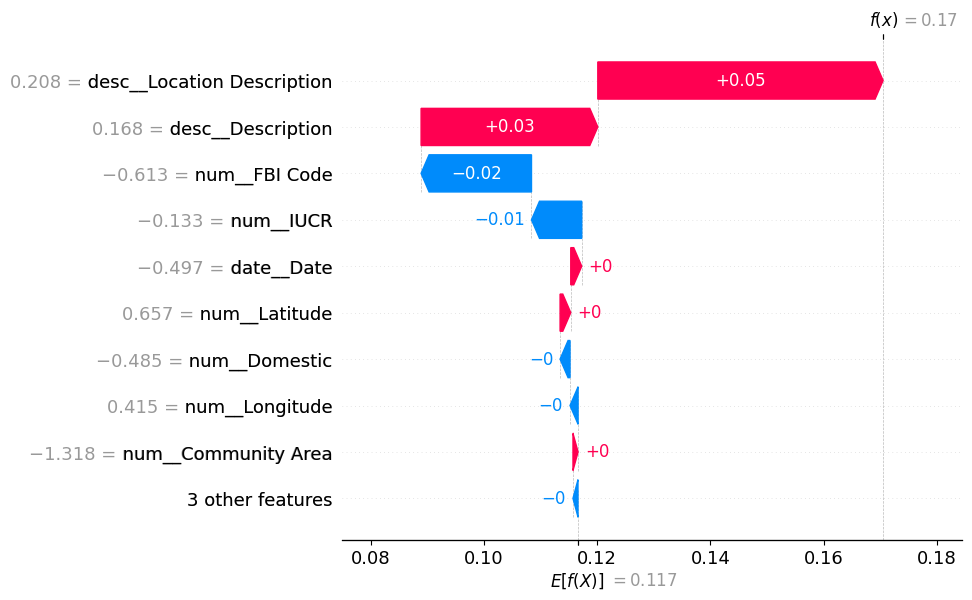

num__IUCR                     0.453970
num__Domestic                -0.485291
num__Beat                    -0.185158
num__District                -0.182519
num__Ward                     0.048747
num__Community Area          -0.343330
num__FBI Code                 0.773908
num__Latitude                 0.195853
num__Longitude               -0.744617
desc__Description             0.021545
desc__Location Description    0.134030
date__Date                    0.091599
Name: 12000, dtype: float64


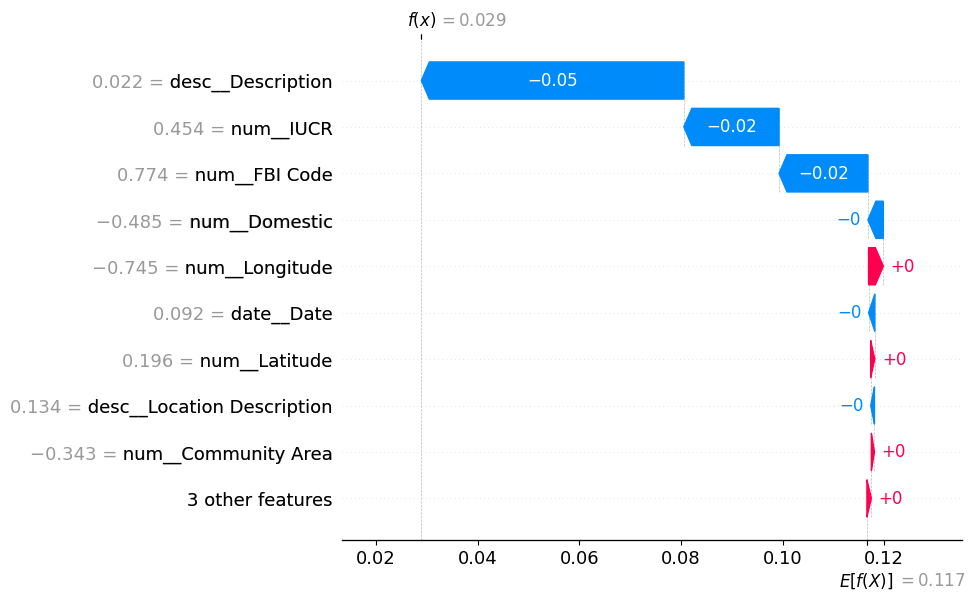

num__IUCR                    -0.554538
num__Domestic                 2.060617
num__Beat                    -1.315139
num__District                -1.313016
num__Ward                    -1.431854
num__Community Area           0.074341
num__FBI Code                -0.959291
num__Latitude                -0.341419
num__Longitude                0.979097
desc__Description             0.108981
desc__Location Description    0.134030
date__Date                   -0.114355
Name: 16, dtype: float64


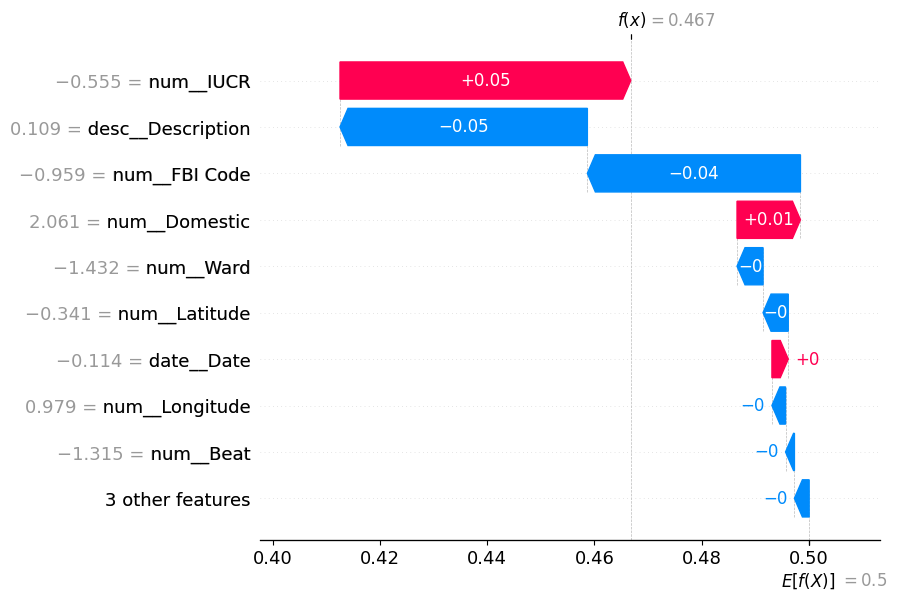

num__IUCR                    -0.197092
num__Domestic                -0.485291
num__Beat                     0.958947
num__District                 0.947979
num__Ward                     1.317834
num__Community Area          -1.317896
num__FBI Code                -0.612652
num__Latitude                 0.535872
num__Longitude                0.554772
desc__Description             0.010454
desc__Location Description    0.140329
date__Date                   -1.121565
Name: 23, dtype: float64


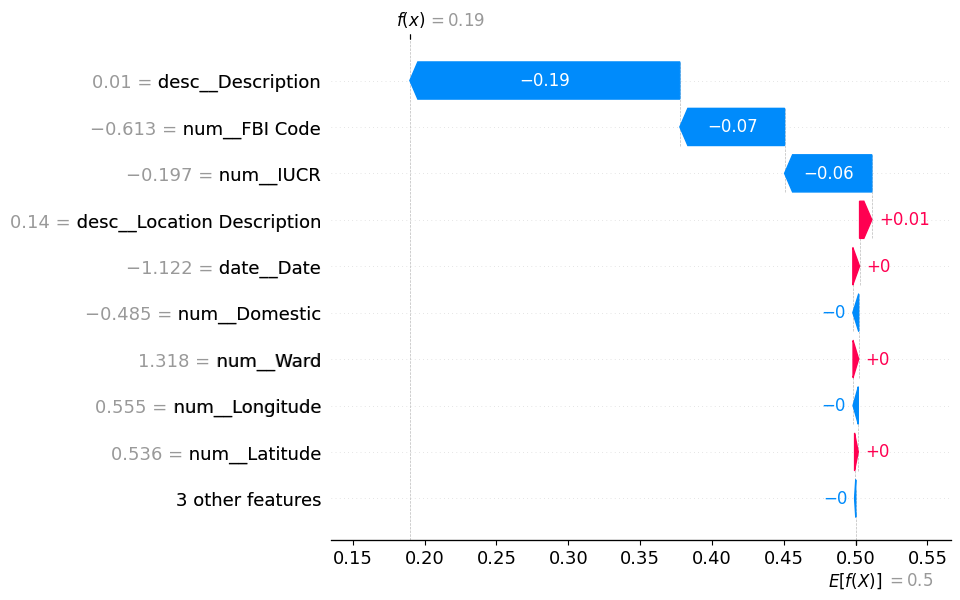

num__IUCR                    -0.133262
num__Domestic                -0.485291
num__Beat                     0.946235
num__District                 0.947979
num__Ward                     0.260262
num__Community Area          -1.317896
num__FBI Code                -0.612652
num__Latitude                 0.657204
num__Longitude                0.414742
desc__Description             0.168312
desc__Location Description    0.207521
date__Date                   -0.497166
Name: 44, dtype: float64


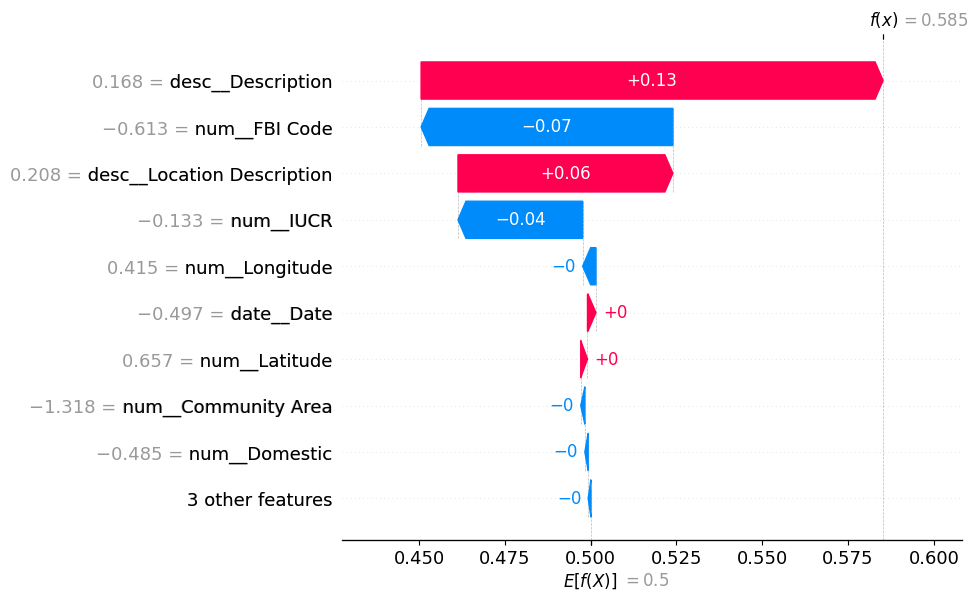

num__IUCR                     0.453970
num__Domestic                -0.485291
num__Beat                    -0.185158
num__District                -0.182519
num__Ward                     0.048747
num__Community Area          -0.343330
num__FBI Code                 0.773908
num__Latitude                 0.195853
num__Longitude               -0.744617
desc__Description             0.021545
desc__Location Description    0.134030
date__Date                    0.091599
Name: 12000, dtype: float64


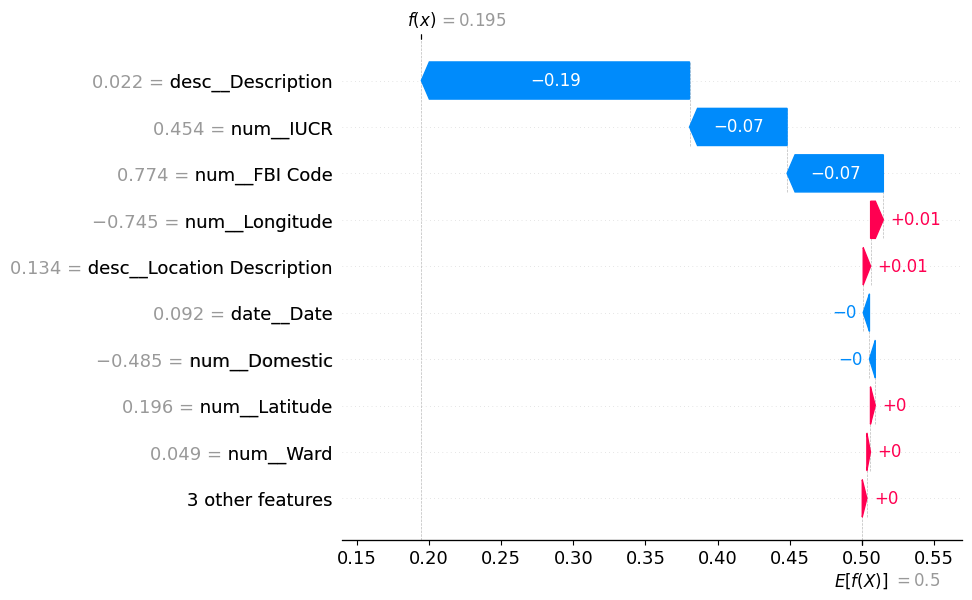

num__IUCR                    -0.554538
num__Domestic                 2.060617
num__Beat                    -1.315139
num__District                -1.313016
num__Ward                    -1.431854
num__Community Area           0.074341
num__FBI Code                -0.959291
num__Latitude                -0.341419
num__Longitude                0.979097
desc__Description             0.108981
desc__Location Description    0.134030
date__Date                   -0.114355
Name: 16, dtype: float64


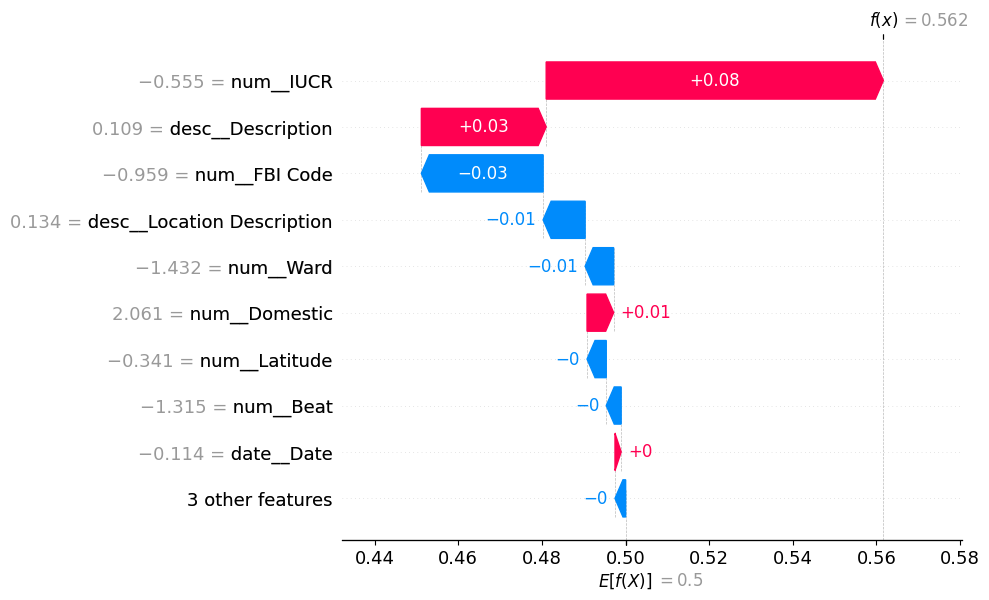

num__IUCR                    -0.197092
num__Domestic                -0.485291
num__Beat                     0.958947
num__District                 0.947979
num__Ward                     1.317834
num__Community Area          -1.317896
num__FBI Code                -0.612652
num__Latitude                 0.535872
num__Longitude                0.554772
desc__Description             0.010454
desc__Location Description    0.140329
date__Date                   -1.121565
Name: 23, dtype: float64


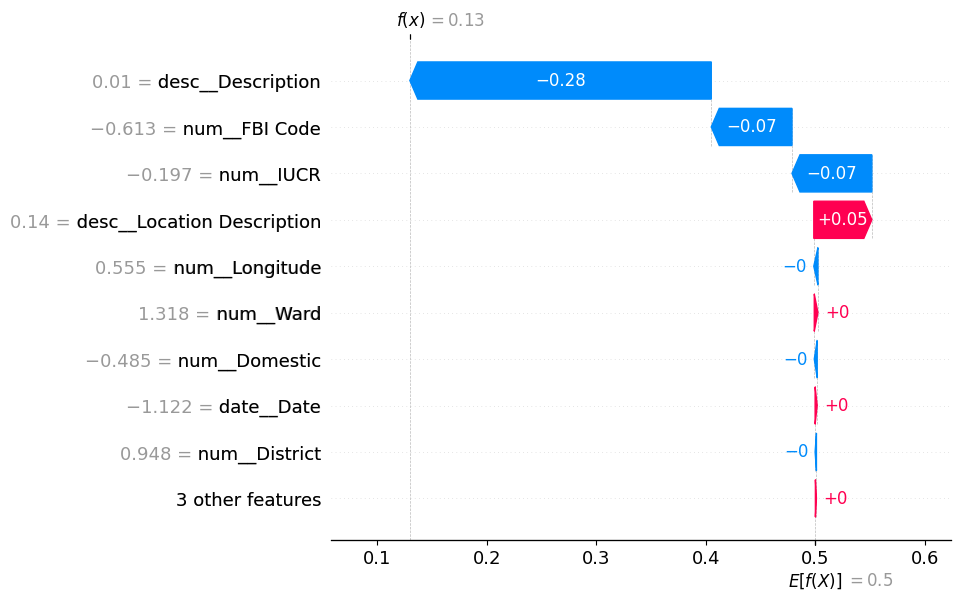

num__IUCR                    -0.133262
num__Domestic                -0.485291
num__Beat                     0.946235
num__District                 0.947979
num__Ward                     0.260262
num__Community Area          -1.317896
num__FBI Code                -0.612652
num__Latitude                 0.657204
num__Longitude                0.414742
desc__Description             0.168312
desc__Location Description    0.207521
date__Date                   -0.497166
Name: 44, dtype: float64


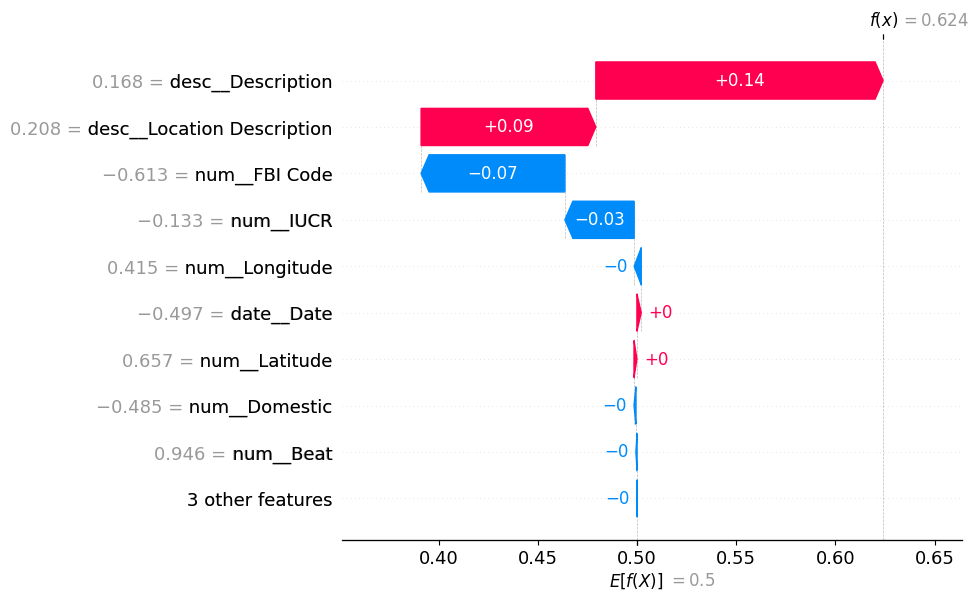

num__IUCR                     0.453970
num__Domestic                -0.485291
num__Beat                    -0.185158
num__District                -0.182519
num__Ward                     0.048747
num__Community Area          -0.343330
num__FBI Code                 0.773908
num__Latitude                 0.195853
num__Longitude               -0.744617
desc__Description             0.021545
desc__Location Description    0.134030
date__Date                    0.091599
Name: 12000, dtype: float64


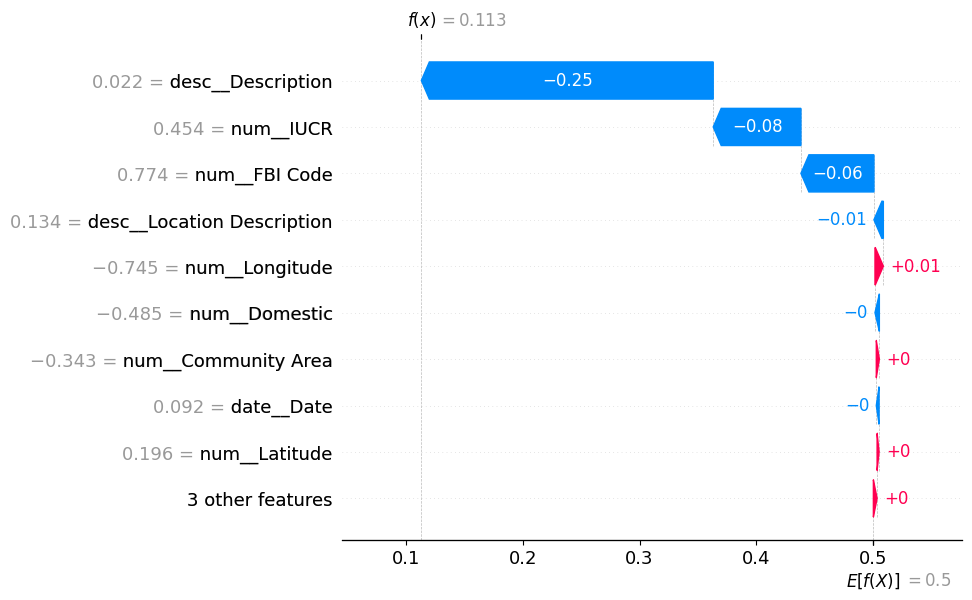

In [7]:
for key, best_model in best_models.items():
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    model=best_model.named_steps['clf']
    x_val_transformed_name = pd.DataFrame(best_model.named_steps['ct'].transform(X_test), columns=feature_names)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_val_transformed_name)

    # Create directory for saving plots
    output_dir = f'Graphs/{key}_waterfall_plot'
    os.makedirs(output_dir, exist_ok=True)
    
    for row in confirmed_arrest:
        fig = plt.figure(figsize=(6, 3.3))
        print(x_val_transformed_name.iloc[row, :])
        explanation5 = shap.Explanation(
            values=shap_values[row, :, 1],  # Select SHAP values for the specific class
            base_values=explainer.expected_value[1],  # Use expected value for the same class
            #feature_names=X_test.columns,
            data=x_val_transformed_name.iloc[row, :]
        )
        shap.plots.waterfall(explanation5)
        fig.tight_layout()
        fig.savefig(f'{output_dir}/Details{row}.jpg', format='jpeg', dpi=300, bbox_inches='tight')


In [8]:
something = [21,22,23,24,25,26,27,28,29,30,31,32,33,34,34,2134,3214,1123,88,99,1000,43]

num__IUCR                    -0.133262
num__Domestic                -0.485291
num__Beat                     0.393957
num__District                 0.382730
num__Ward                    -1.572863
num__Community Area          -0.668185
num__FBI Code                -0.612652
num__Latitude                 0.858031
num__Longitude               -0.442666
desc__Description             0.168312
desc__Location Description    0.106921
date__Date                   -0.693624
Name: 21, dtype: float64


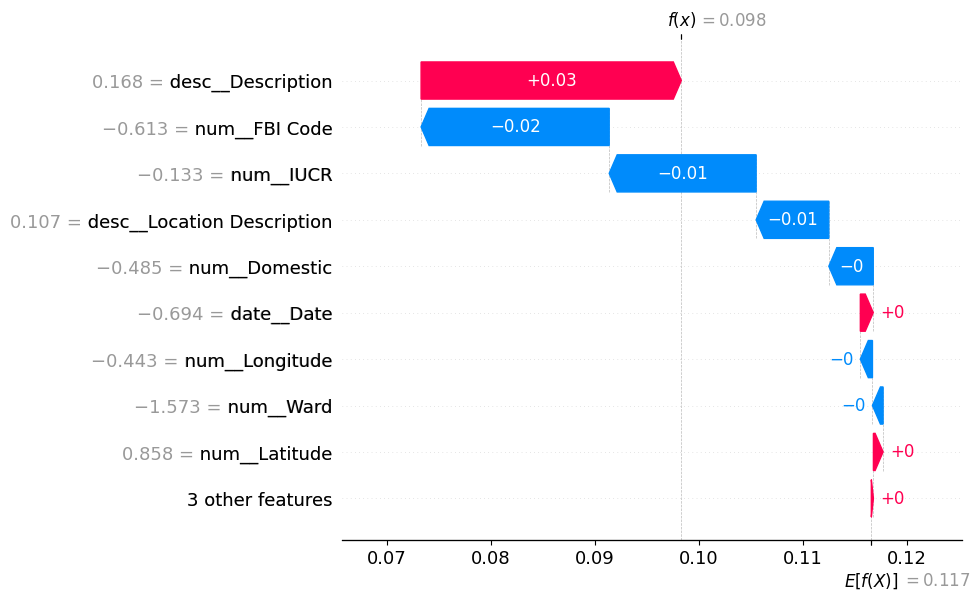

num__IUCR                     0.505034
num__Domestic                -0.485291
num__Beat                    -0.734611
num__District                -0.747768
num__Ward                    -1.079330
num__Community Area           0.352789
num__FBI Code                 2.853747
num__Latitude                -1.229904
num__Longitude                1.056877
desc__Description             0.021545
desc__Location Description    0.134030
date__Date                    0.742387
Name: 22, dtype: float64


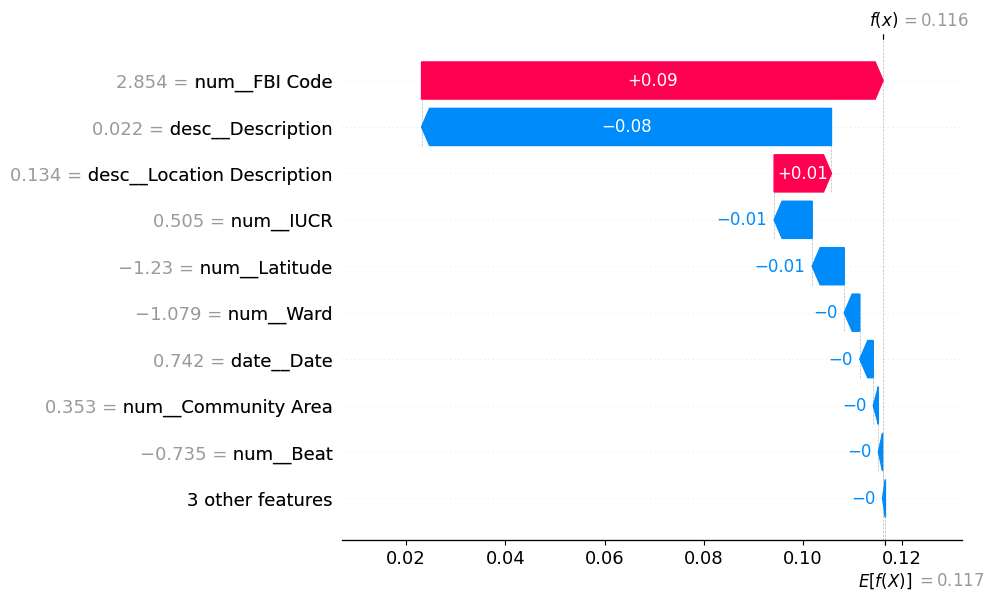

num__IUCR                    -0.197092
num__Domestic                -0.485291
num__Beat                     0.958947
num__District                 0.947979
num__Ward                     1.317834
num__Community Area          -1.317896
num__FBI Code                -0.612652
num__Latitude                 0.535872
num__Longitude                0.554772
desc__Description             0.010454
desc__Location Description    0.140329
date__Date                   -1.121565
Name: 23, dtype: float64


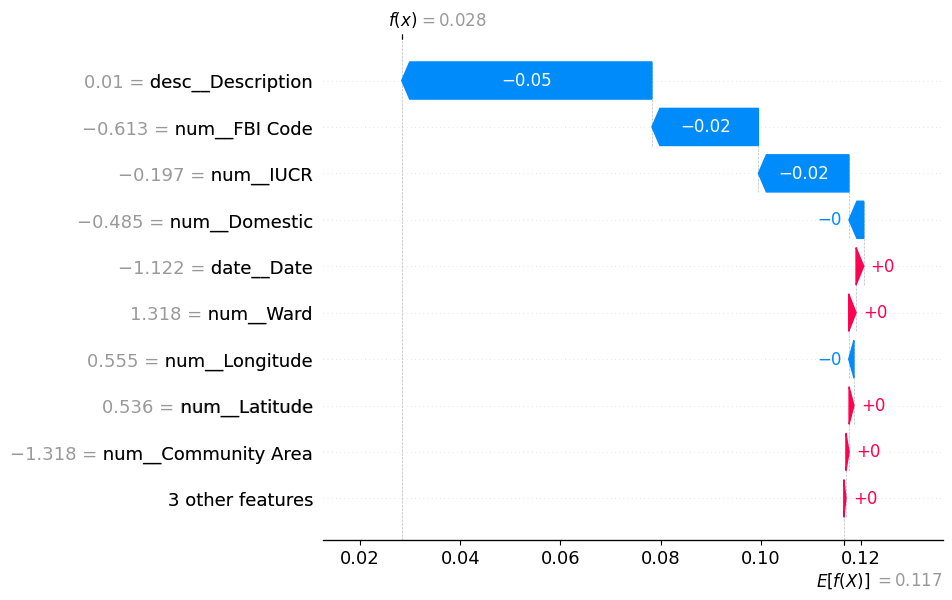

num__IUCR                     0.441205
num__Domestic                -0.485291
num__Beat                    -0.464828
num__District                -0.465143
num__Ward                    -0.021758
num__Community Area           1.373763
num__FBI Code                 0.773908
num__Latitude                -0.735722
num__Longitude               -0.653301
desc__Description             0.044838
desc__Location Description    0.067030
date__Date                   -0.493618
Name: 24, dtype: float64


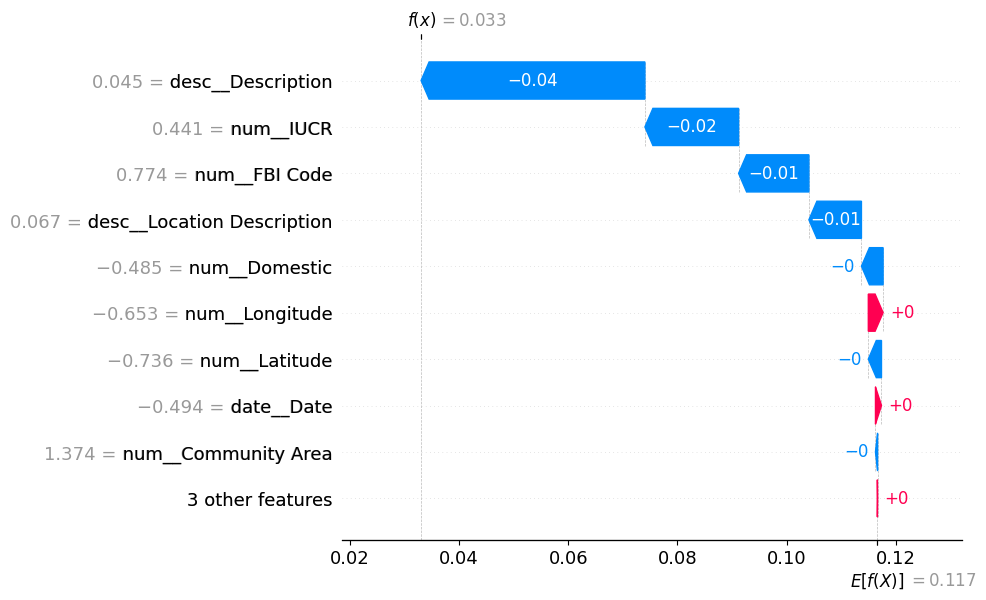

num__IUCR                     0.453970
num__Domestic                -0.485291
num__Beat                    -0.478953
num__District                -0.465143
num__Ward                    -0.726806
num__Community Area           1.188131
num__FBI Code                 0.773908
num__Latitude                -0.588053
num__Longitude               -0.890613
desc__Description             0.021545
desc__Location Description    0.134030
date__Date                   -0.148709
Name: 25, dtype: float64


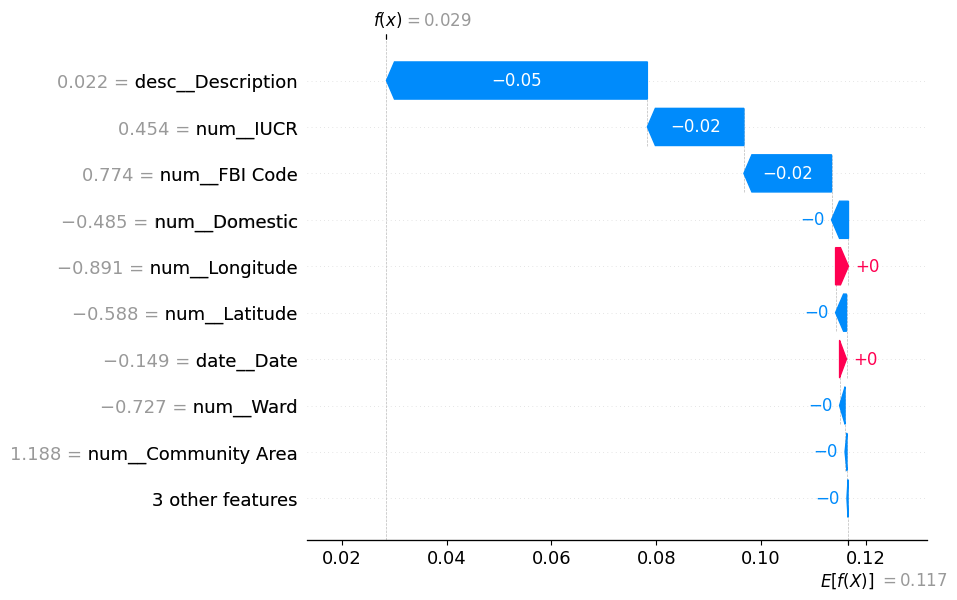

num__IUCR                     0.441205
num__Domestic                 2.060617
num__Beat                    -1.032644
num__District                -1.030392
num__Ward                    -1.149835
num__Community Area           0.306381
num__FBI Code                 0.773908
num__Latitude                -1.030054
num__Longitude                1.698557
desc__Description             0.044838
desc__Location Description    0.081583
date__Date                    1.199137
Name: 26, dtype: float64


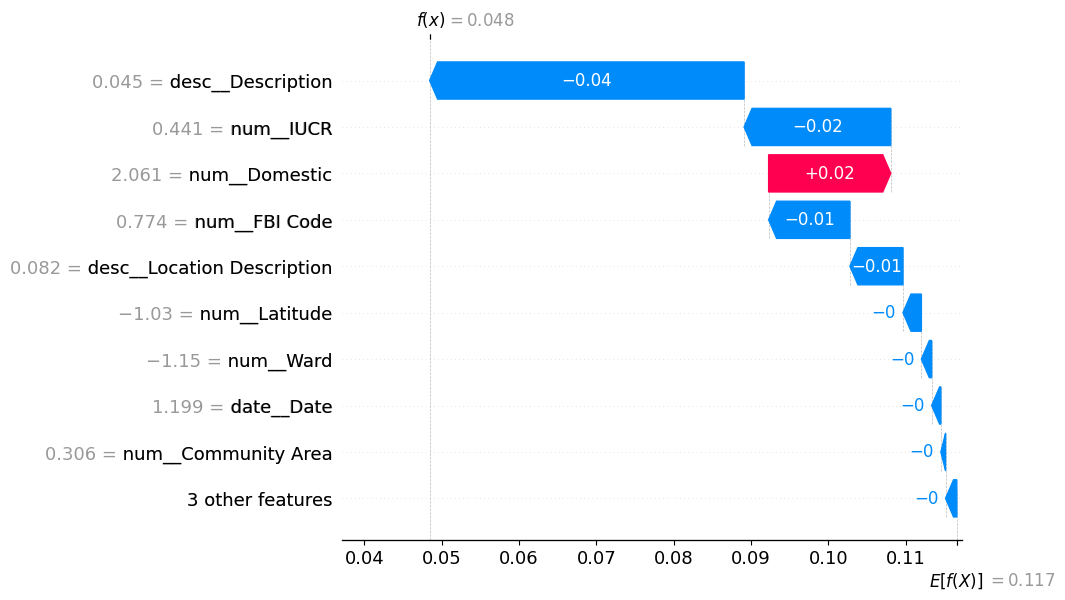

num__IUCR                     2.376519
num__Domestic                -0.485291
num__Beat                    -0.464828
num__District                -0.465143
num__Ward                    -0.515291
num__Community Area           1.373763
num__FBI Code                 2.853747
num__Latitude                -0.712295
num__Longitude               -0.425768
desc__Description             0.009199
desc__Location Description    0.067030
date__Date                   -0.552208
Name: 27, dtype: float64


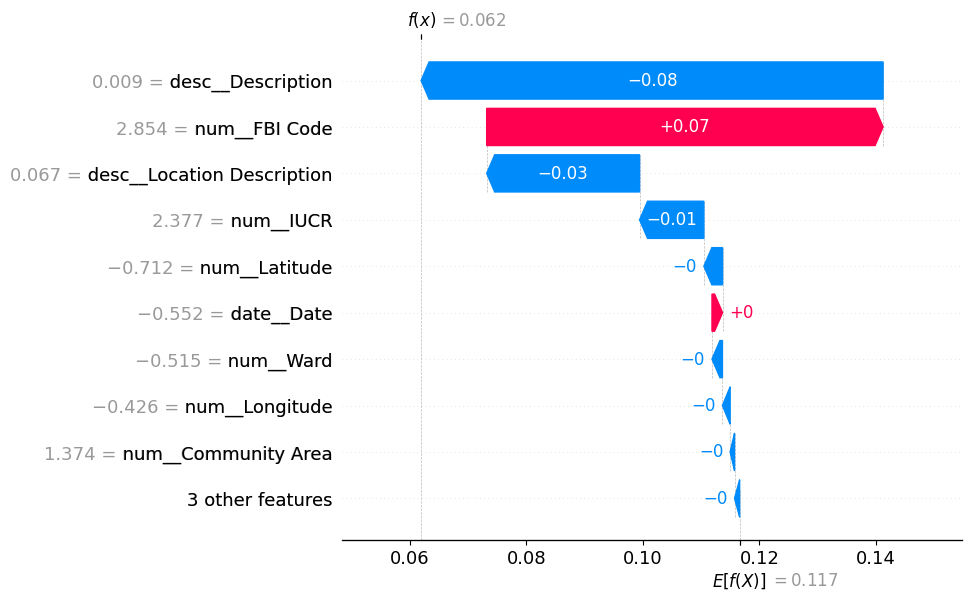

num__IUCR                    -0.197092
num__Domestic                -0.485291
num__Beat                     1.779595
num__District                 1.795852
num__Ward                     1.881872
num__Community Area          -1.596343
num__FBI Code                -0.612652
num__Latitude                 1.710545
num__Longitude               -0.606577
desc__Description             0.010454
desc__Location Description    0.134030
date__Date                    0.787297
Name: 28, dtype: float64


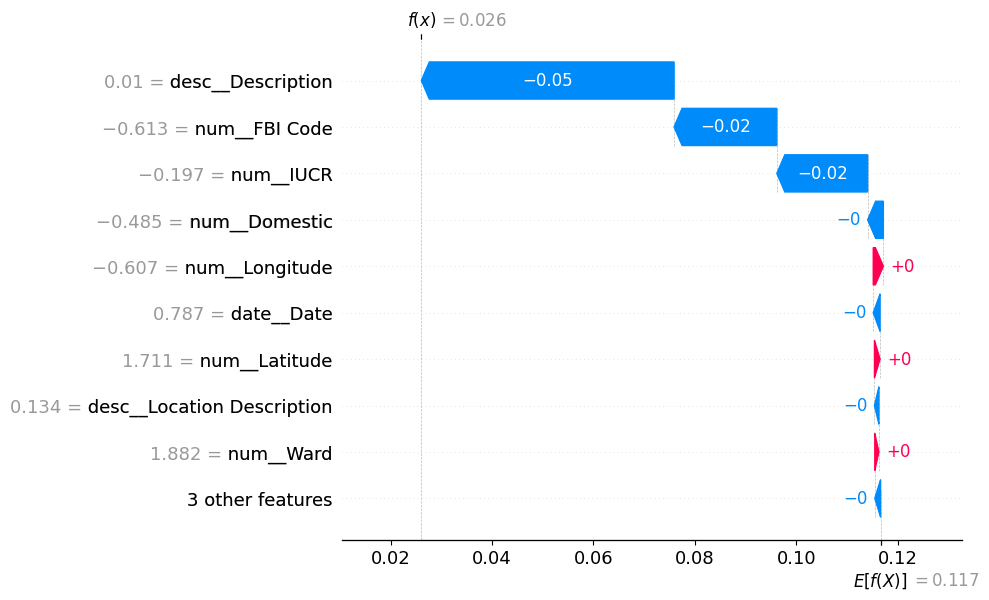

num__IUCR                    -1.048579
num__Domestic                -0.485291
num__Beat                    -1.440849
num__District                -1.454328
num__Ward                    -1.361349
num__Community Area          -0.157698
num__FBI Code                 0.947228
num__Latitude                 0.034198
num__Longitude                0.828268
desc__Description             0.936059
desc__Location Description    0.134030
date__Date                   -1.319397
Name: 29, dtype: float64


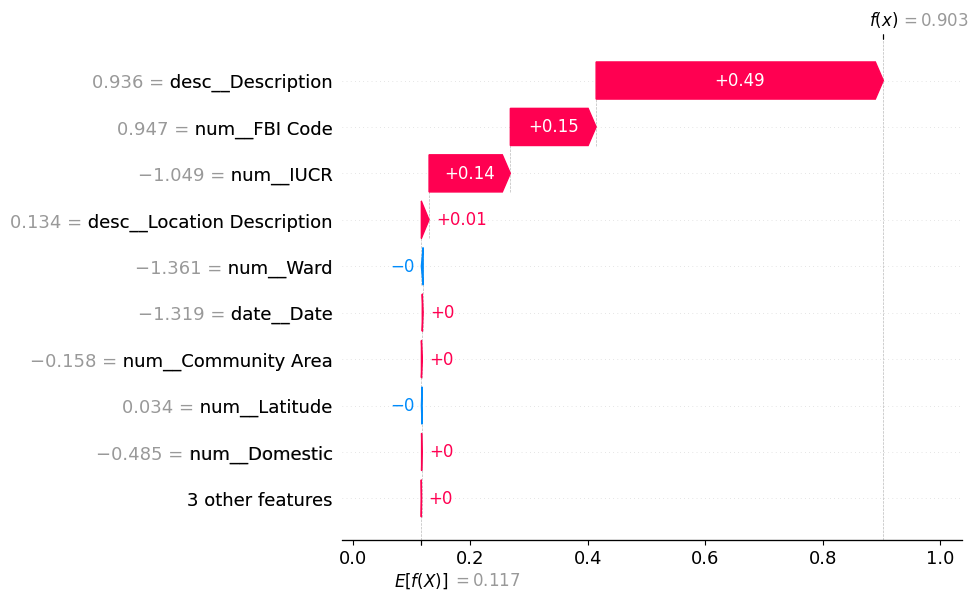

num__IUCR                    -0.060496
num__Domestic                -0.485291
num__Beat                     0.398194
num__District                 0.382730
num__Ward                     0.612786
num__Community Area          -0.575369
num__FBI Code                -0.439332
num__Latitude                 0.752567
num__Longitude               -0.145123
desc__Description             0.032526
desc__Location Description    0.134030
date__Date                   -0.497242
Name: 30, dtype: float64


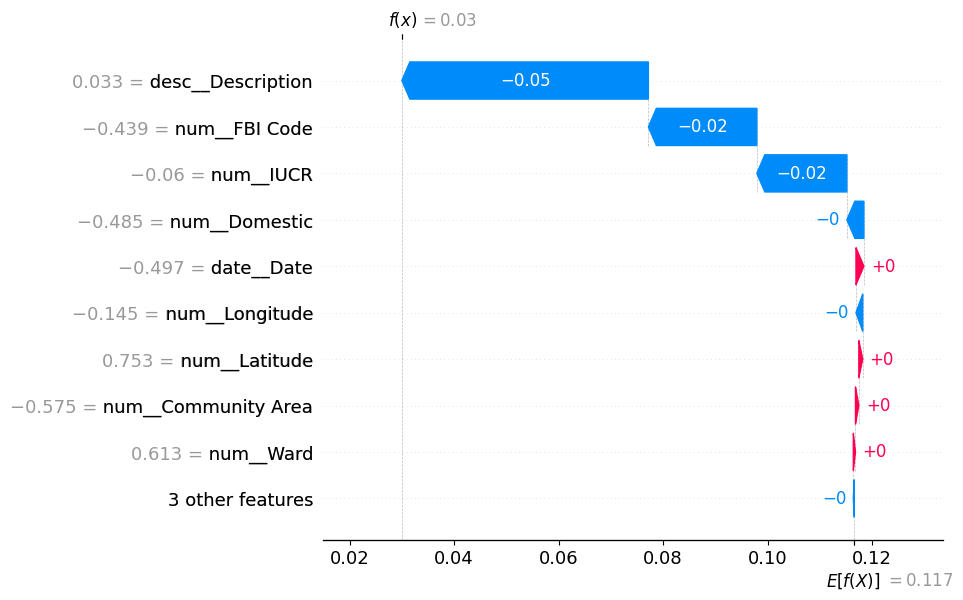

num__IUCR                     2.376519
num__Domestic                 2.060617
num__Beat                     1.213193
num__District                 1.230603
num__Ward                     1.176824
num__Community Area          -1.596343
num__FBI Code                 2.853747
num__Latitude                 1.611258
num__Longitude               -0.462187
desc__Description             0.009199
desc__Location Description    0.067030
date__Date                    1.393469
Name: 31, dtype: float64


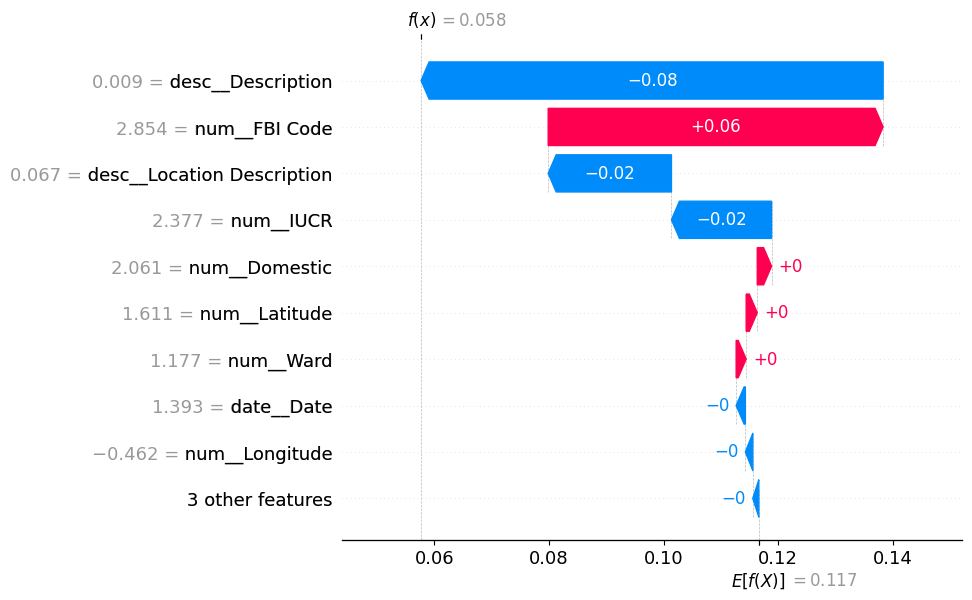

num__IUCR                    -0.516240
num__Domestic                -0.485291
num__Beat                     0.819112
num__District                 0.806667
num__Ward                     0.824300
num__Community Area          -0.714593
num__FBI Code                -0.266012
num__Latitude                 1.119779
num__Longitude               -0.719423
desc__Description             0.085514
desc__Location Description    0.070754
date__Date                    1.233491
Name: 32, dtype: float64


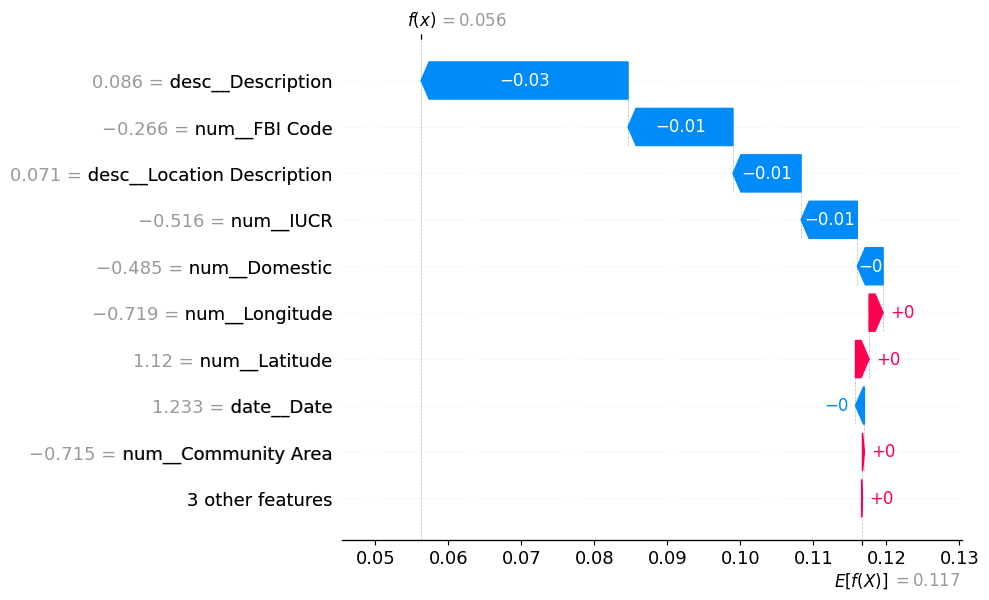

num__IUCR                    -0.590282
num__Domestic                -0.485291
num__Beat                    -0.038261
num__District                -0.041207
num__Ward                     0.260262
num__Community Area          -0.389738
num__FBI Code                 2.853747
num__Latitude                 0.354576
num__Longitude               -0.350401
desc__Description             0.488269
desc__Location Description    0.134030
date__Date                   -0.193797
Name: 33, dtype: float64


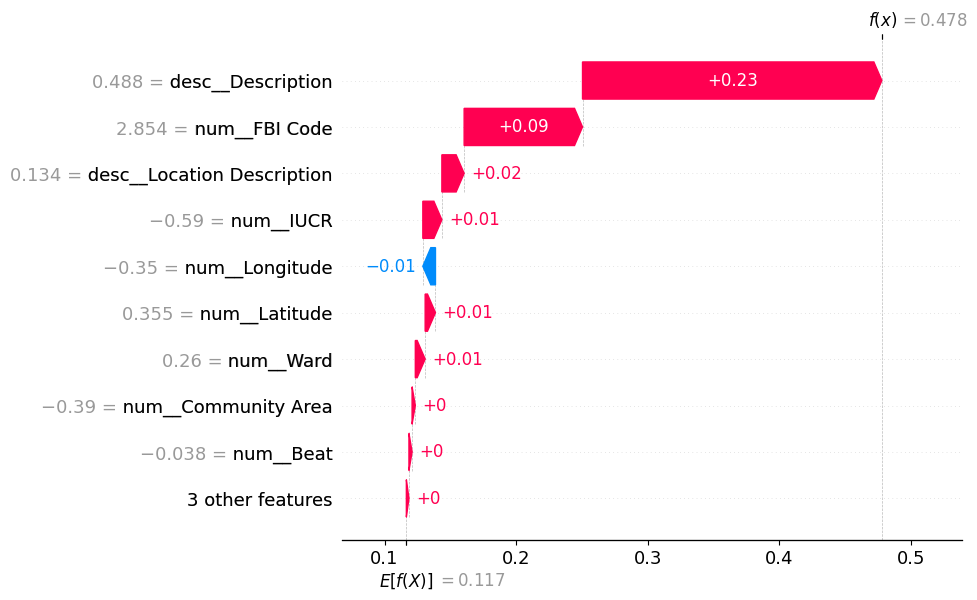

num__IUCR                     0.441205
num__Domestic                -0.485291
num__Beat                    -0.594776
num__District                -0.606455
num__Ward                    -1.220339
num__Community Area           1.512986
num__FBI Code                 0.773908
num__Latitude                -0.958916
num__Longitude                0.568185
desc__Description             0.044838
desc__Location Description    0.067030
date__Date                    0.743406
Name: 34, dtype: float64


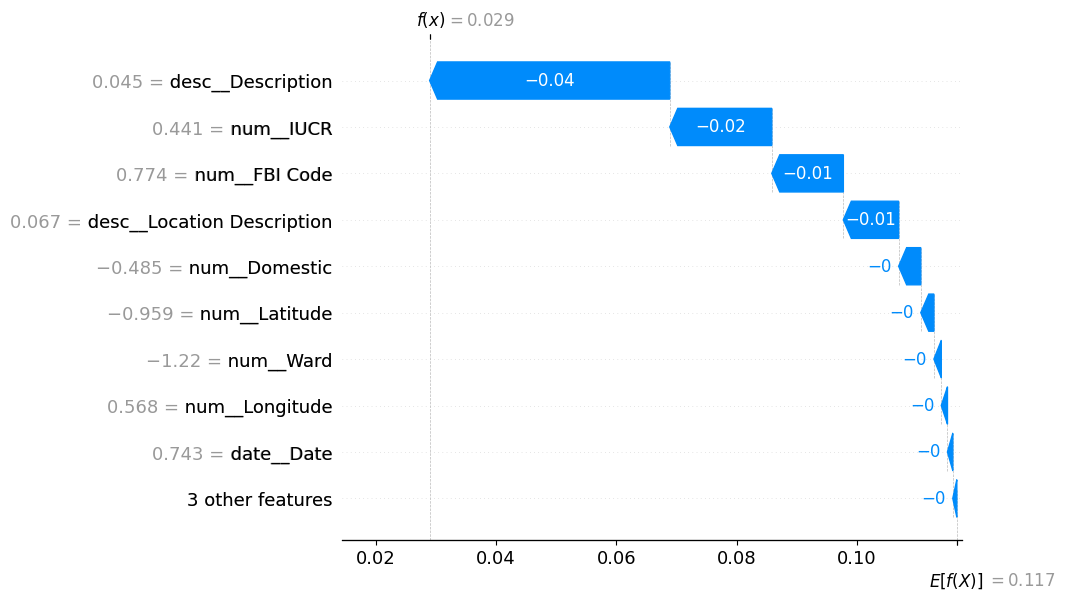

num__IUCR                     0.441205
num__Domestic                -0.485291
num__Beat                    -0.594776
num__District                -0.606455
num__Ward                    -1.220339
num__Community Area           1.512986
num__FBI Code                 0.773908
num__Latitude                -0.958916
num__Longitude                0.568185
desc__Description             0.044838
desc__Location Description    0.067030
date__Date                    0.743406
Name: 34, dtype: float64


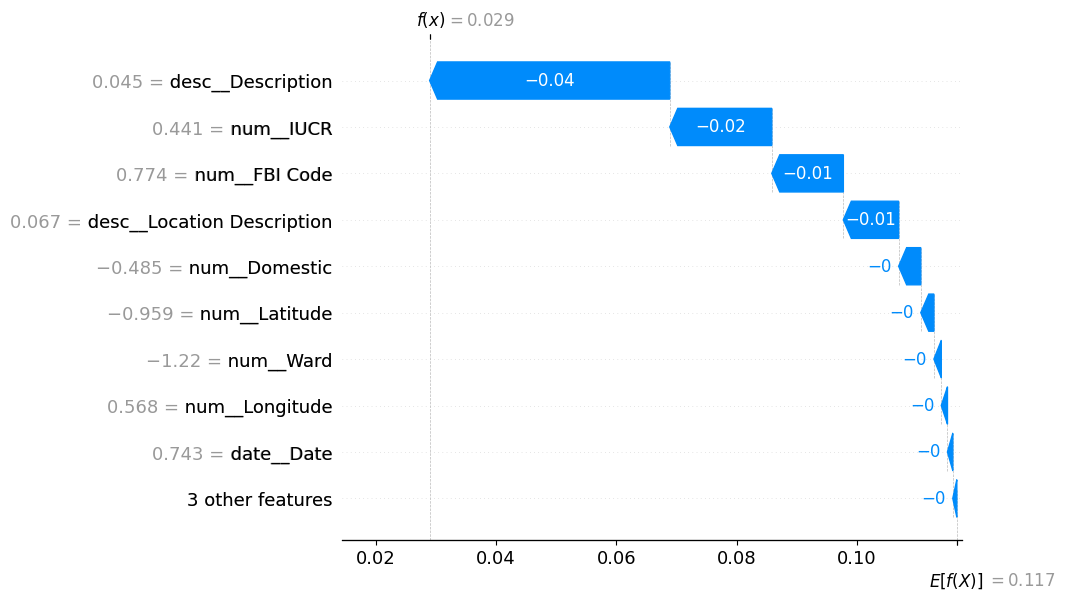

num__IUCR                    -0.184326
num__Domestic                -0.485291
num__Beat                     0.522492
num__District                 0.524042
num__Ward                     0.330767
num__Community Area          -0.528961
num__FBI Code                -0.612652
num__Latitude                 0.392177
num__Longitude               -1.417553
desc__Description             0.016137
desc__Location Description    0.134030
date__Date                    1.095151
Name: 2134, dtype: float64


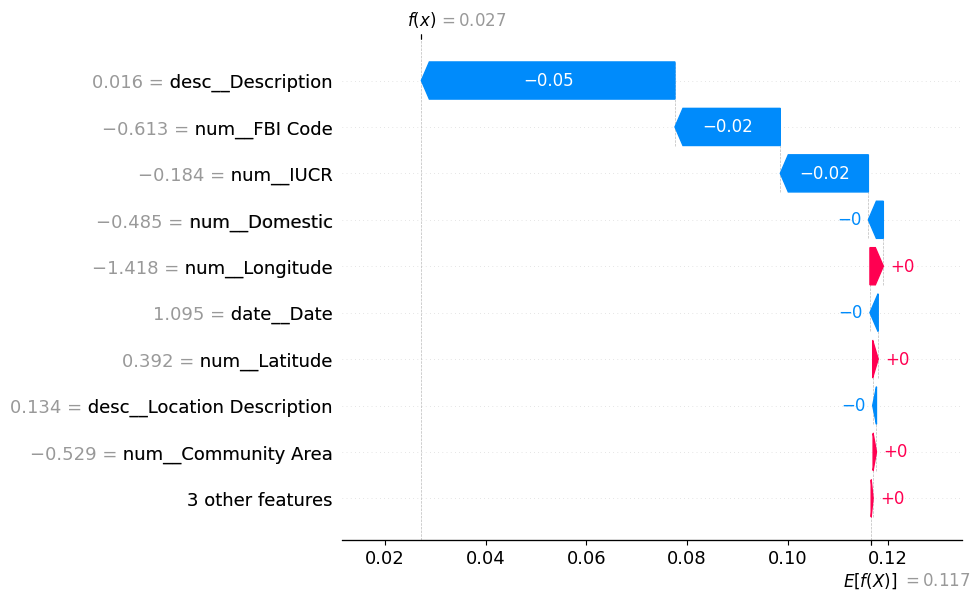

num__IUCR                    -0.516240
num__Domestic                 2.060617
num__Beat                    -0.902696
num__District                -0.889080
num__Ward                    -1.008825
num__Community Area           0.584828
num__FBI Code                -0.266012
num__Latitude                -1.699191
num__Longitude                0.921713
desc__Description             0.085514
desc__Location Description    0.081583
date__Date                   -0.407613
Name: 3214, dtype: float64


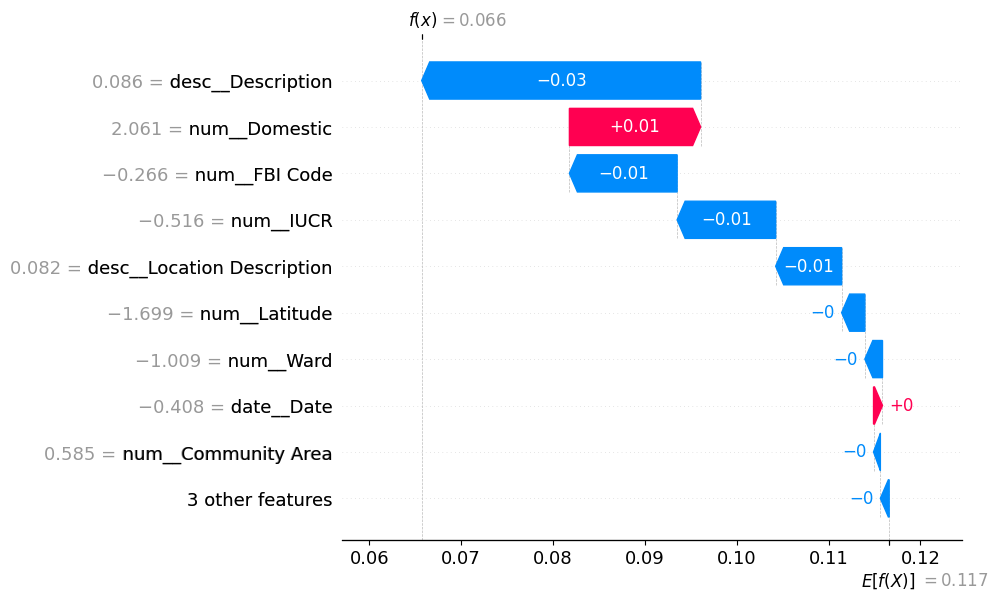

num__IUCR                    -0.184326
num__Domestic                -0.485291
num__Beat                     0.704702
num__District                 0.665354
num__Ward                     1.247329
num__Community Area           1.837842
num__FBI Code                -0.612652
num__Latitude                 1.468069
num__Longitude               -3.864445
desc__Description             0.016137
desc__Location Description    0.134030
date__Date                   -1.077673
Name: 1123, dtype: float64


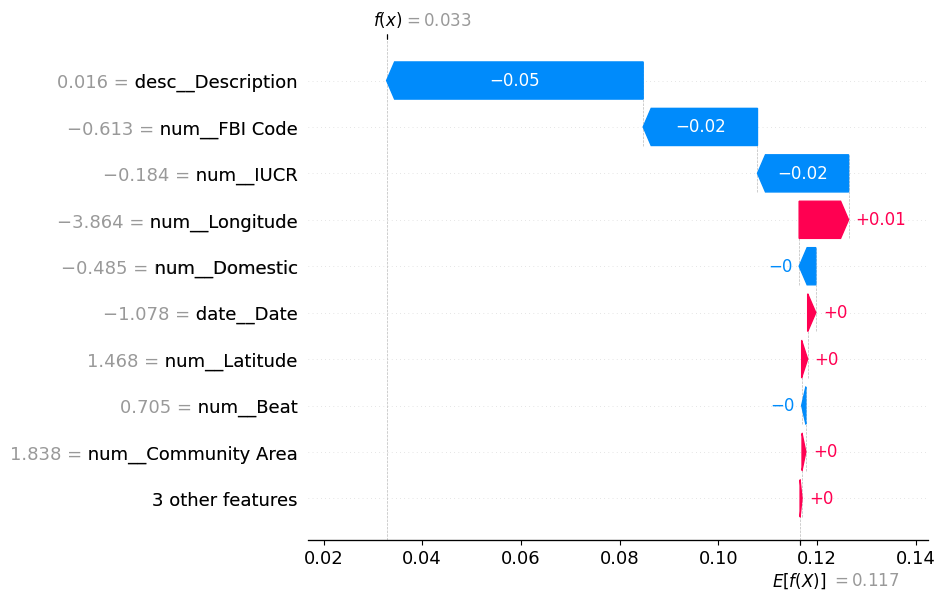

num__IUCR                    -0.554538
num__Domestic                -0.485291
num__Beat                    -0.058035
num__District                -0.041207
num__Ward                     0.965310
num__Community Area          -0.621777
num__FBI Code                -0.959291
num__Latitude                 0.559848
num__Longitude               -0.985220
desc__Description             0.108981
desc__Location Description    0.217986
date__Date                   -0.123960
Name: 88, dtype: float64


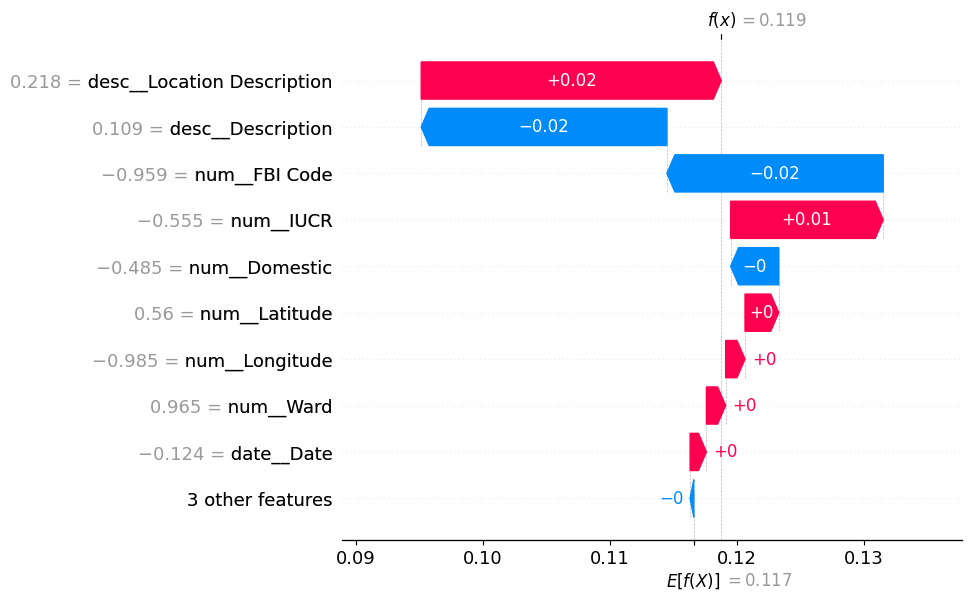

num__IUCR                    -0.452410
num__Domestic                -0.485291
num__Beat                    -1.032644
num__District                -1.030392
num__Ward                    -1.149835
num__Community Area           0.306381
num__FBI Code                -0.785972
num__Latitude                -0.967465
num__Longitude                1.855888
desc__Description             0.043657
desc__Location Description    0.081583
date__Date                    1.101715
Name: 99, dtype: float64


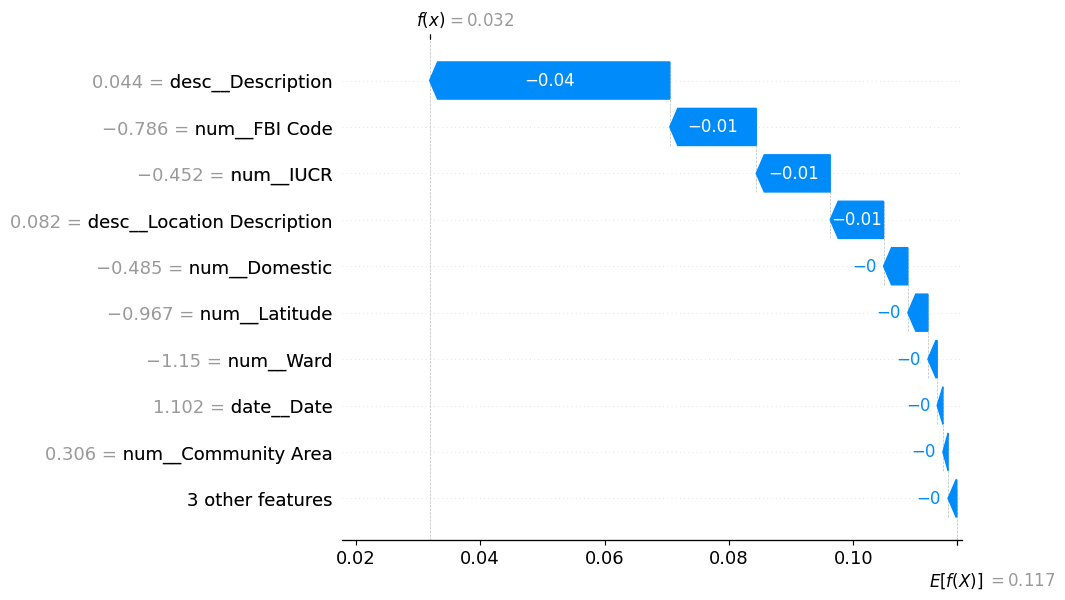

num__IUCR                    -0.184326
num__Domestic                -0.485291
num__Beat                     0.365707
num__District                 0.382730
num__Ward                     0.683291
num__Community Area          -0.714593
num__FBI Code                -0.612652
num__Latitude                 1.044616
num__Longitude               -0.441761
desc__Description             0.016137
desc__Location Description    0.134030
date__Date                    0.213634
Name: 1000, dtype: float64


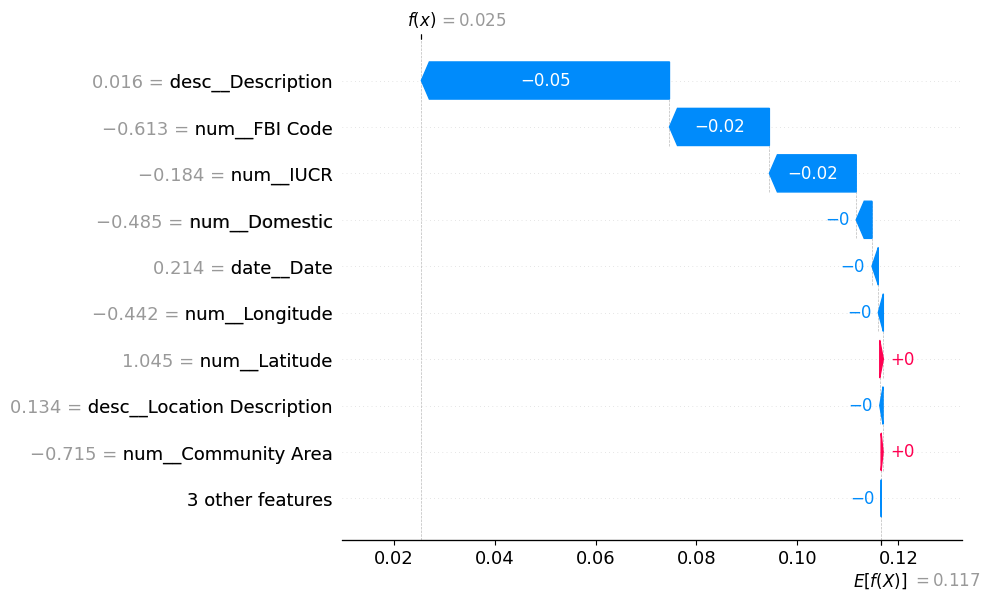

num__IUCR                    -1.048579
num__Domestic                -0.485291
num__Beat                    -0.736024
num__District                -0.747768
num__Ward                    -1.079330
num__Community Area           0.352789
num__FBI Code                 0.947228
num__Latitude                -1.087362
num__Longitude                1.036542
desc__Description             0.936059
desc__Location Description    0.189829
date__Date                   -0.419358
Name: 43, dtype: float64


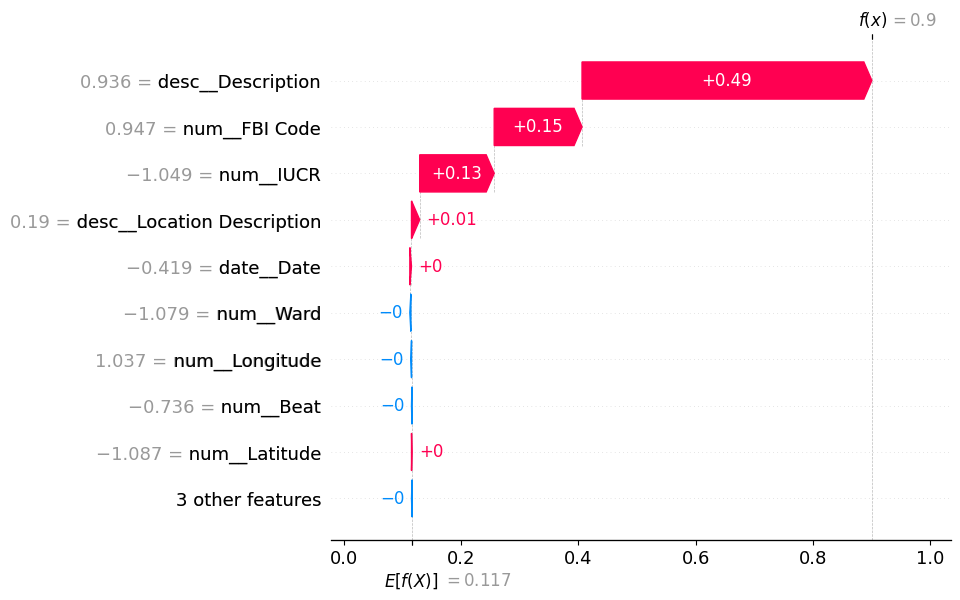

num__IUCR                    -0.133262
num__Domestic                -0.485291
num__Beat                     0.393957
num__District                 0.382730
num__Ward                    -1.572863
num__Community Area          -0.668185
num__FBI Code                -0.612652
num__Latitude                 0.858031
num__Longitude               -0.442666
desc__Description             0.168312
desc__Location Description    0.106921
date__Date                   -0.693624
Name: 21, dtype: float64


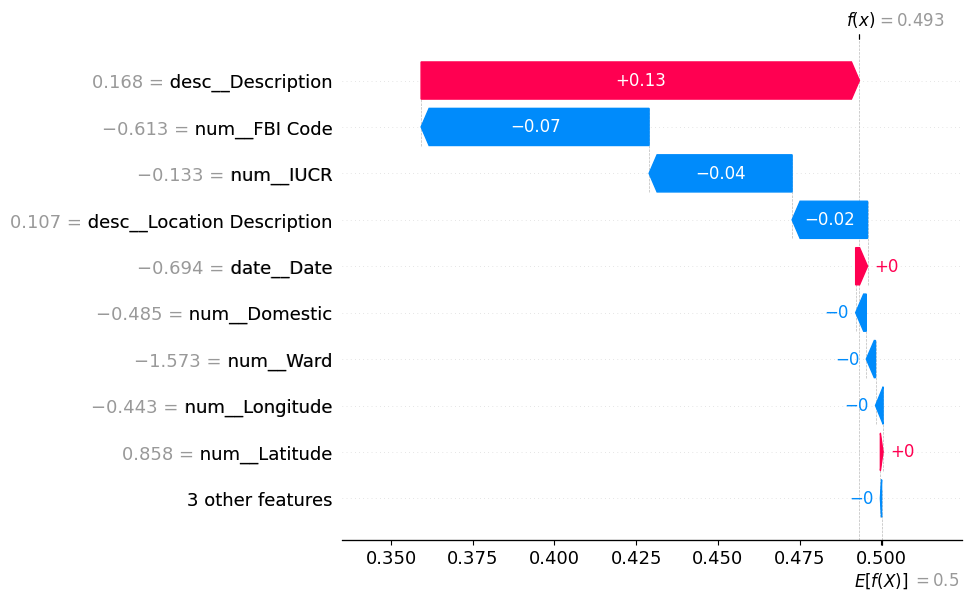

num__IUCR                     0.505034
num__Domestic                -0.485291
num__Beat                    -0.734611
num__District                -0.747768
num__Ward                    -1.079330
num__Community Area           0.352789
num__FBI Code                 2.853747
num__Latitude                -1.229904
num__Longitude                1.056877
desc__Description             0.021545
desc__Location Description    0.134030
date__Date                    0.742387
Name: 22, dtype: float64


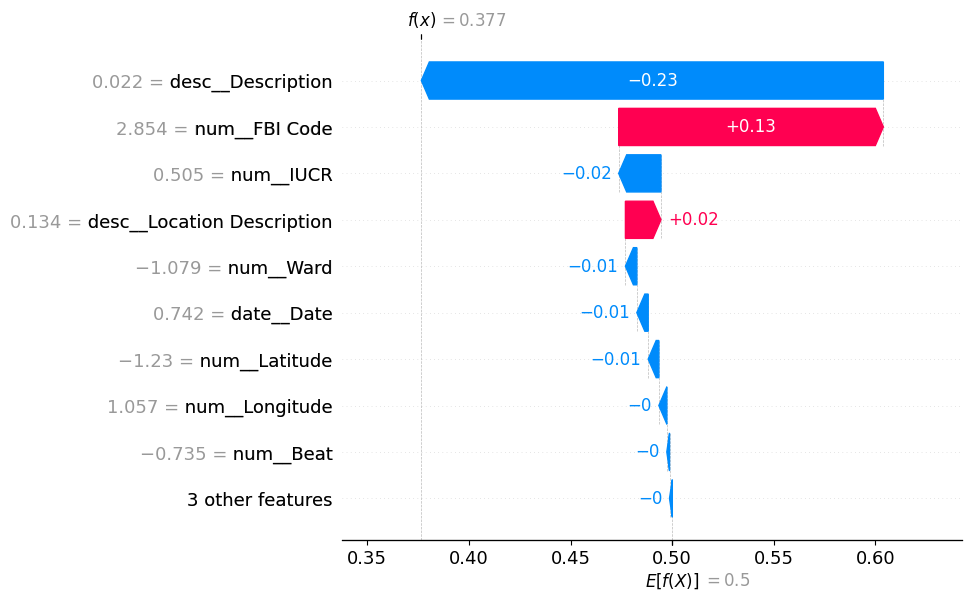

num__IUCR                    -0.197092
num__Domestic                -0.485291
num__Beat                     0.958947
num__District                 0.947979
num__Ward                     1.317834
num__Community Area          -1.317896
num__FBI Code                -0.612652
num__Latitude                 0.535872
num__Longitude                0.554772
desc__Description             0.010454
desc__Location Description    0.140329
date__Date                   -1.121565
Name: 23, dtype: float64


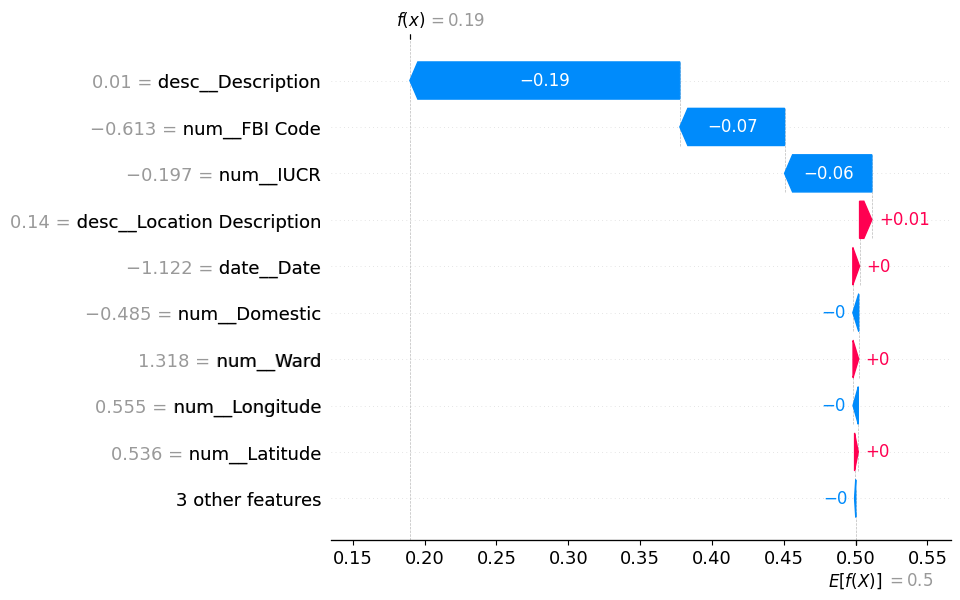

num__IUCR                     0.441205
num__Domestic                -0.485291
num__Beat                    -0.464828
num__District                -0.465143
num__Ward                    -0.021758
num__Community Area           1.373763
num__FBI Code                 0.773908
num__Latitude                -0.735722
num__Longitude               -0.653301
desc__Description             0.044838
desc__Location Description    0.067030
date__Date                   -0.493618
Name: 24, dtype: float64


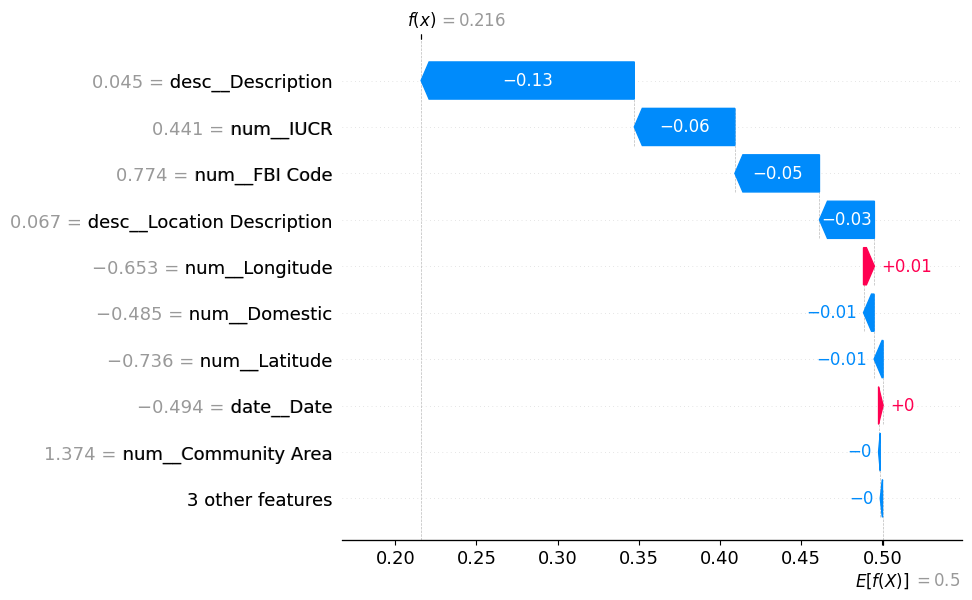

num__IUCR                     0.453970
num__Domestic                -0.485291
num__Beat                    -0.478953
num__District                -0.465143
num__Ward                    -0.726806
num__Community Area           1.188131
num__FBI Code                 0.773908
num__Latitude                -0.588053
num__Longitude               -0.890613
desc__Description             0.021545
desc__Location Description    0.134030
date__Date                   -0.148709
Name: 25, dtype: float64


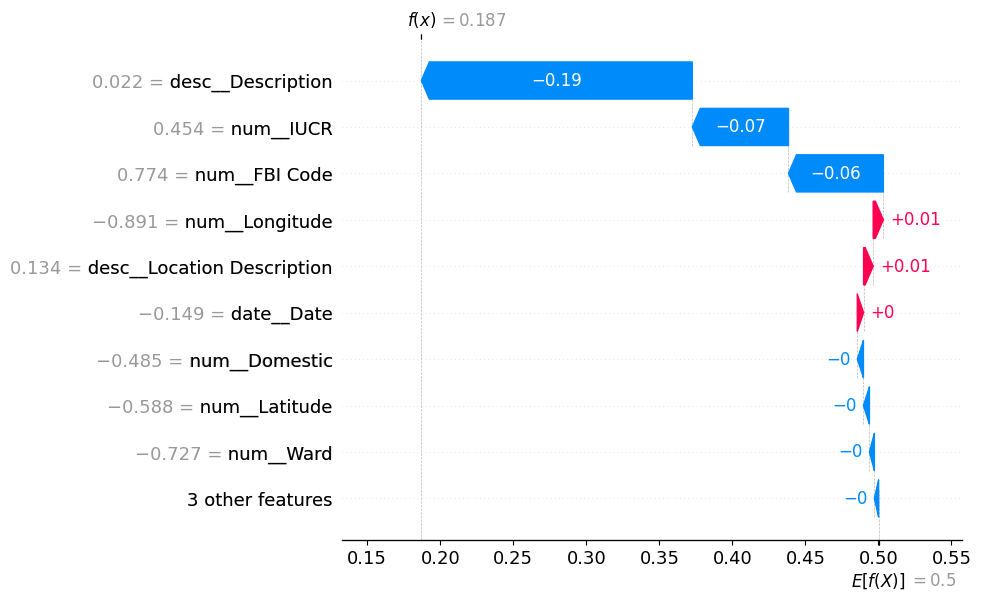

num__IUCR                     0.441205
num__Domestic                 2.060617
num__Beat                    -1.032644
num__District                -1.030392
num__Ward                    -1.149835
num__Community Area           0.306381
num__FBI Code                 0.773908
num__Latitude                -1.030054
num__Longitude                1.698557
desc__Description             0.044838
desc__Location Description    0.081583
date__Date                    1.199137
Name: 26, dtype: float64


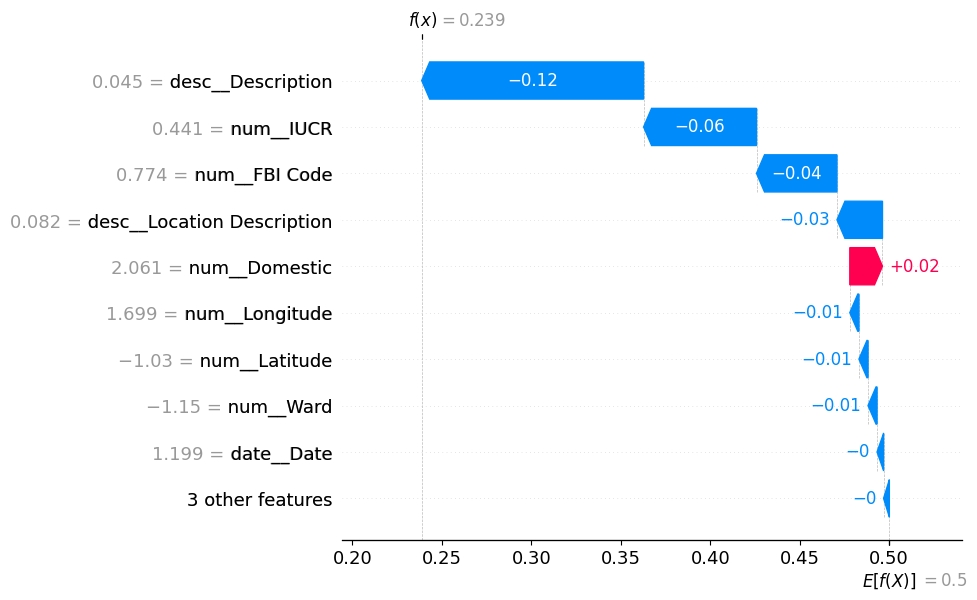

num__IUCR                     2.376519
num__Domestic                -0.485291
num__Beat                    -0.464828
num__District                -0.465143
num__Ward                    -0.515291
num__Community Area           1.373763
num__FBI Code                 2.853747
num__Latitude                -0.712295
num__Longitude               -0.425768
desc__Description             0.009199
desc__Location Description    0.067030
date__Date                   -0.552208
Name: 27, dtype: float64


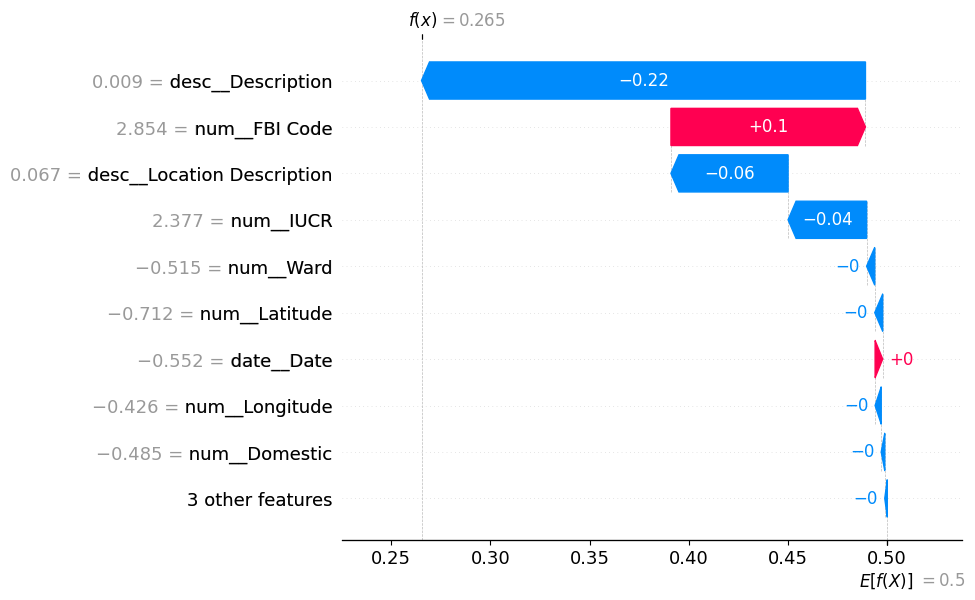

num__IUCR                    -0.197092
num__Domestic                -0.485291
num__Beat                     1.779595
num__District                 1.795852
num__Ward                     1.881872
num__Community Area          -1.596343
num__FBI Code                -0.612652
num__Latitude                 1.710545
num__Longitude               -0.606577
desc__Description             0.010454
desc__Location Description    0.134030
date__Date                    0.787297
Name: 28, dtype: float64


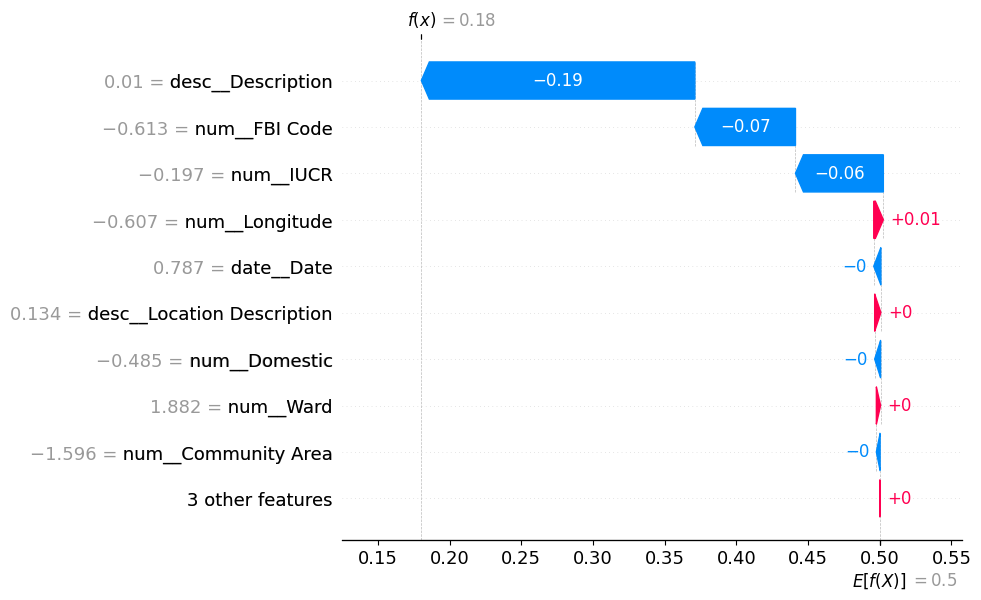

num__IUCR                    -1.048579
num__Domestic                -0.485291
num__Beat                    -1.440849
num__District                -1.454328
num__Ward                    -1.361349
num__Community Area          -0.157698
num__FBI Code                 0.947228
num__Latitude                 0.034198
num__Longitude                0.828268
desc__Description             0.936059
desc__Location Description    0.134030
date__Date                   -1.319397
Name: 29, dtype: float64


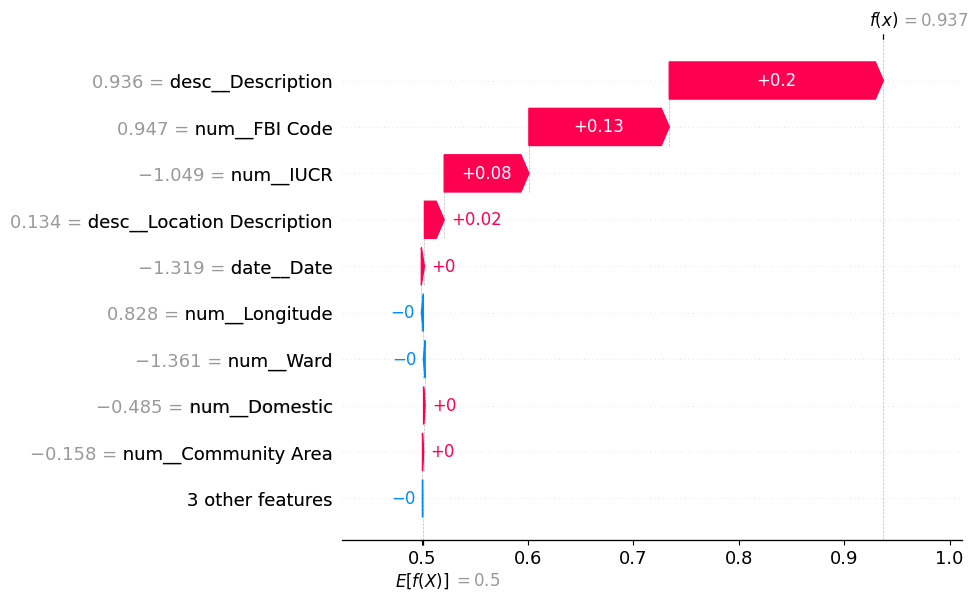

num__IUCR                    -0.060496
num__Domestic                -0.485291
num__Beat                     0.398194
num__District                 0.382730
num__Ward                     0.612786
num__Community Area          -0.575369
num__FBI Code                -0.439332
num__Latitude                 0.752567
num__Longitude               -0.145123
desc__Description             0.032526
desc__Location Description    0.134030
date__Date                   -0.497242
Name: 30, dtype: float64


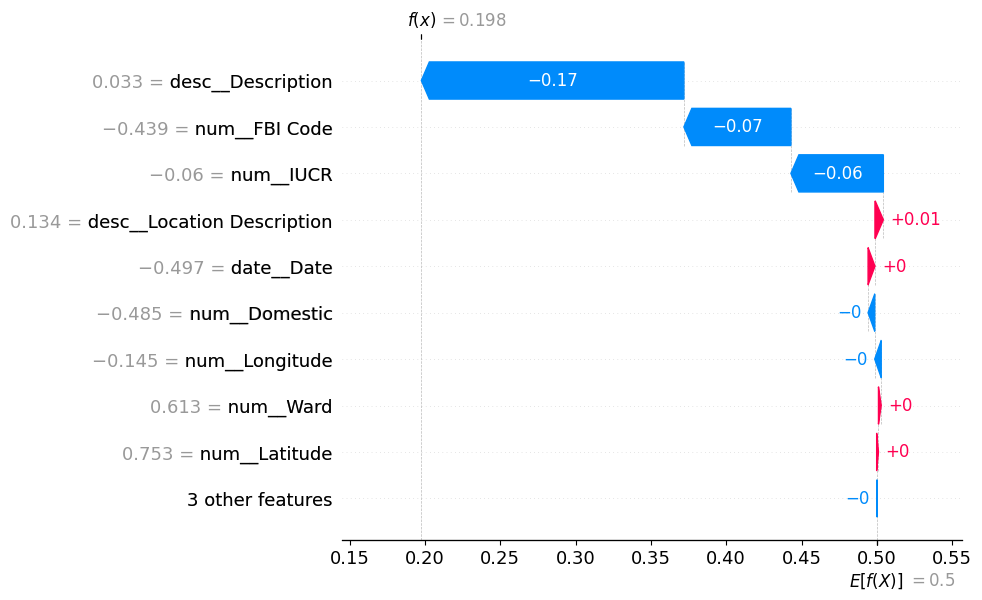

num__IUCR                     2.376519
num__Domestic                 2.060617
num__Beat                     1.213193
num__District                 1.230603
num__Ward                     1.176824
num__Community Area          -1.596343
num__FBI Code                 2.853747
num__Latitude                 1.611258
num__Longitude               -0.462187
desc__Description             0.009199
desc__Location Description    0.067030
date__Date                    1.393469
Name: 31, dtype: float64


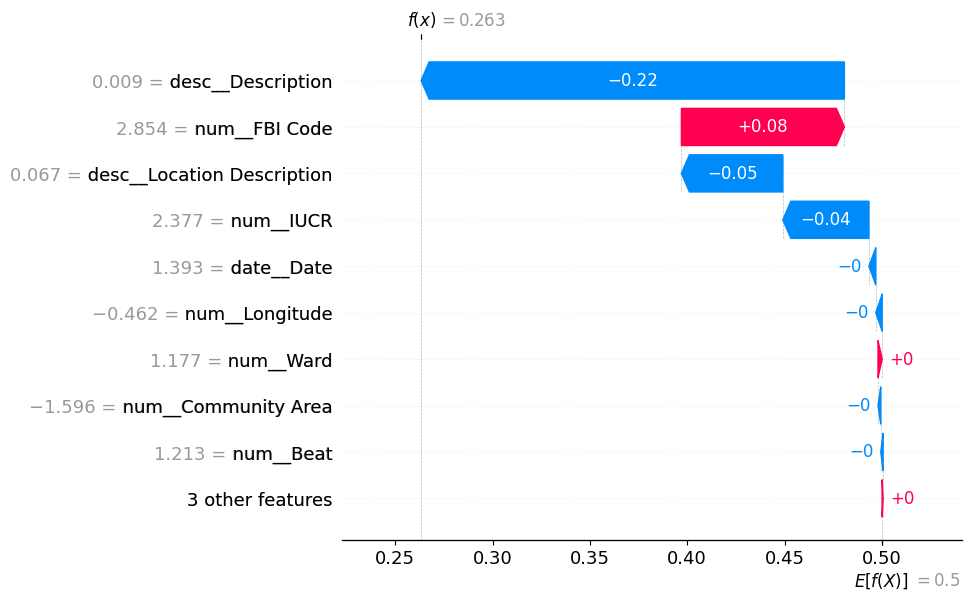

num__IUCR                    -0.516240
num__Domestic                -0.485291
num__Beat                     0.819112
num__District                 0.806667
num__Ward                     0.824300
num__Community Area          -0.714593
num__FBI Code                -0.266012
num__Latitude                 1.119779
num__Longitude               -0.719423
desc__Description             0.085514
desc__Location Description    0.070754
date__Date                    1.233491
Name: 32, dtype: float64


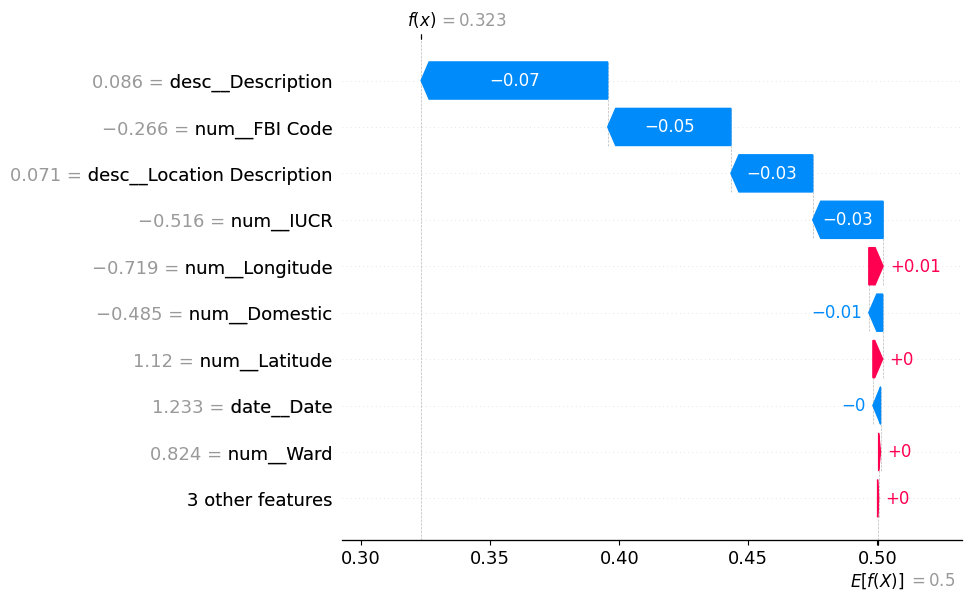

num__IUCR                    -0.590282
num__Domestic                -0.485291
num__Beat                    -0.038261
num__District                -0.041207
num__Ward                     0.260262
num__Community Area          -0.389738
num__FBI Code                 2.853747
num__Latitude                 0.354576
num__Longitude               -0.350401
desc__Description             0.488269
desc__Location Description    0.134030
date__Date                   -0.193797
Name: 33, dtype: float64


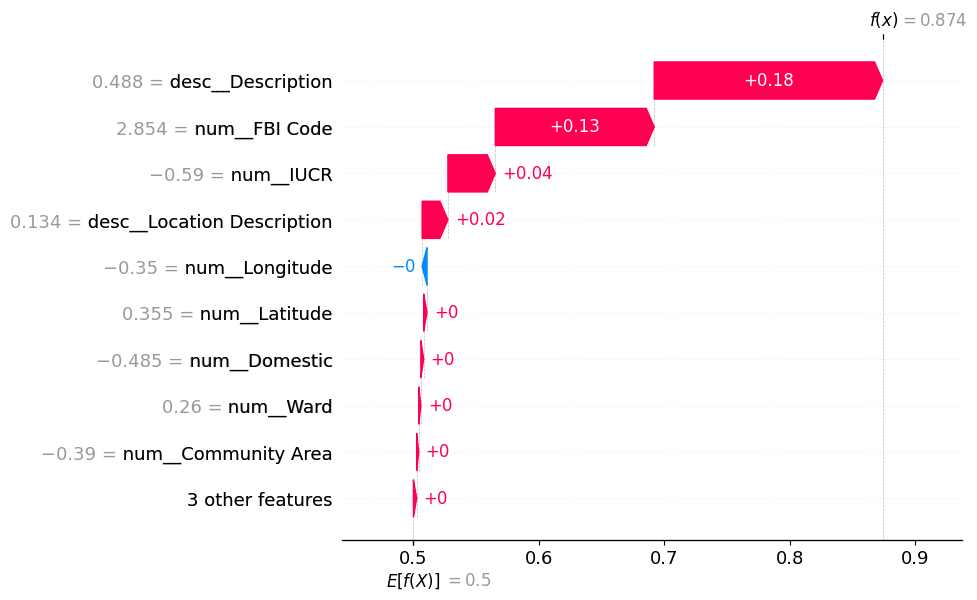

num__IUCR                     0.441205
num__Domestic                -0.485291
num__Beat                    -0.594776
num__District                -0.606455
num__Ward                    -1.220339
num__Community Area           1.512986
num__FBI Code                 0.773908
num__Latitude                -0.958916
num__Longitude                0.568185
desc__Description             0.044838
desc__Location Description    0.067030
date__Date                    0.743406
Name: 34, dtype: float64


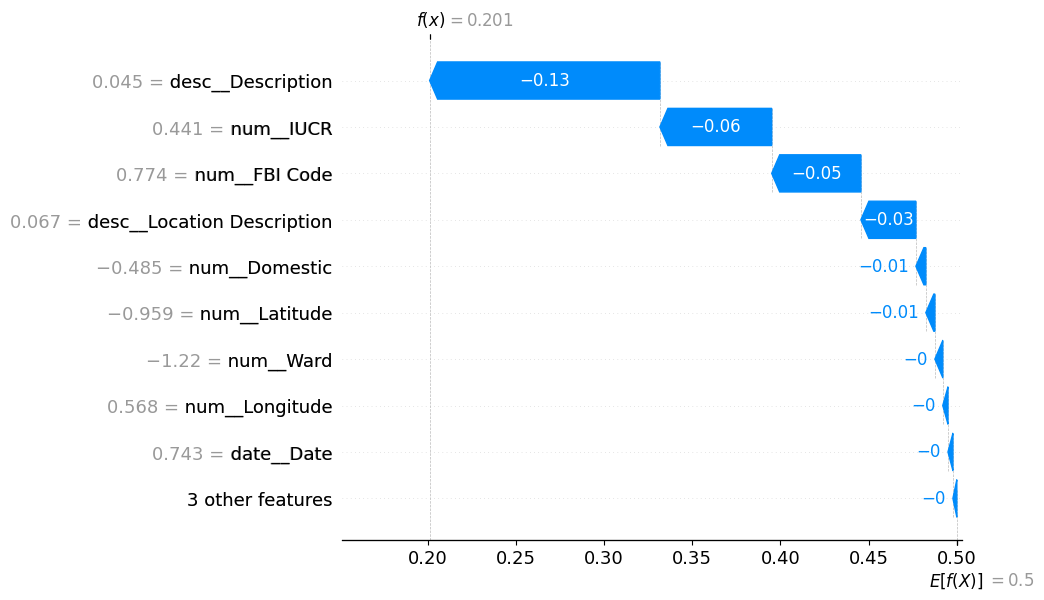

num__IUCR                     0.441205
num__Domestic                -0.485291
num__Beat                    -0.594776
num__District                -0.606455
num__Ward                    -1.220339
num__Community Area           1.512986
num__FBI Code                 0.773908
num__Latitude                -0.958916
num__Longitude                0.568185
desc__Description             0.044838
desc__Location Description    0.067030
date__Date                    0.743406
Name: 34, dtype: float64


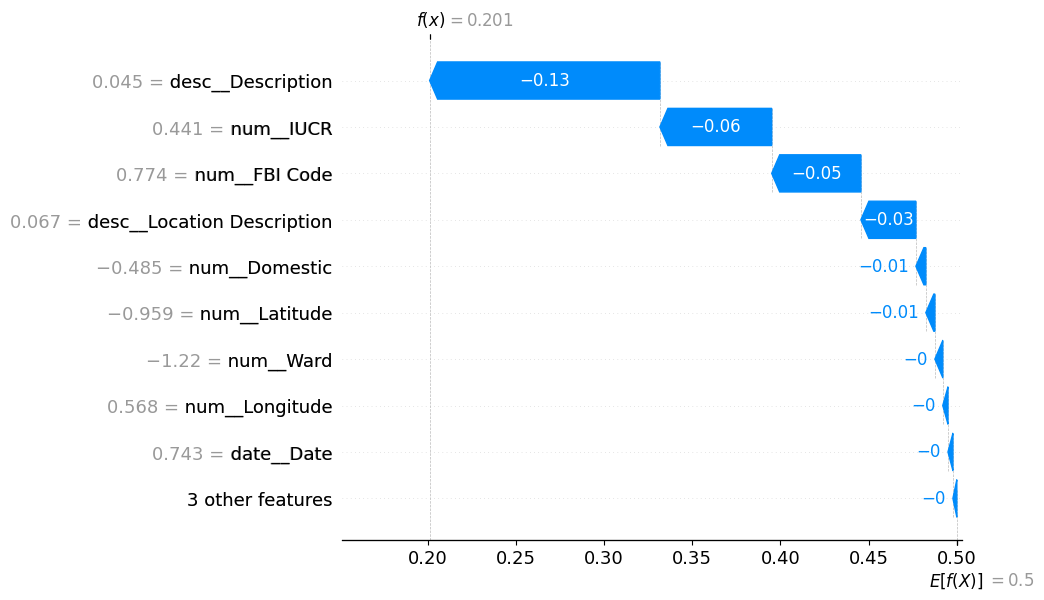

num__IUCR                    -0.184326
num__Domestic                -0.485291
num__Beat                     0.522492
num__District                 0.524042
num__Ward                     0.330767
num__Community Area          -0.528961
num__FBI Code                -0.612652
num__Latitude                 0.392177
num__Longitude               -1.417553
desc__Description             0.016137
desc__Location Description    0.134030
date__Date                    1.095151
Name: 2134, dtype: float64


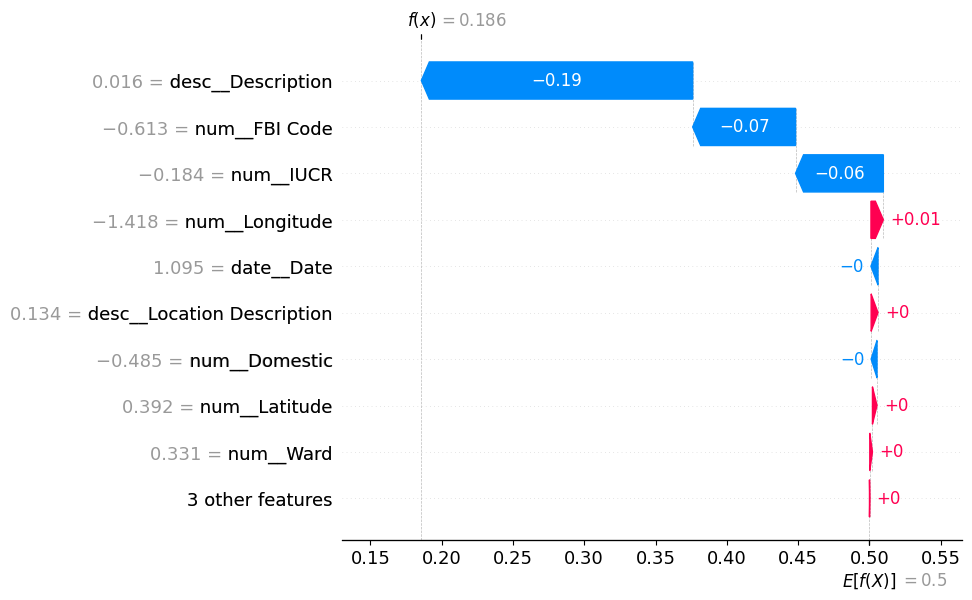

num__IUCR                    -0.516240
num__Domestic                 2.060617
num__Beat                    -0.902696
num__District                -0.889080
num__Ward                    -1.008825
num__Community Area           0.584828
num__FBI Code                -0.266012
num__Latitude                -1.699191
num__Longitude                0.921713
desc__Description             0.085514
desc__Location Description    0.081583
date__Date                   -0.407613
Name: 3214, dtype: float64


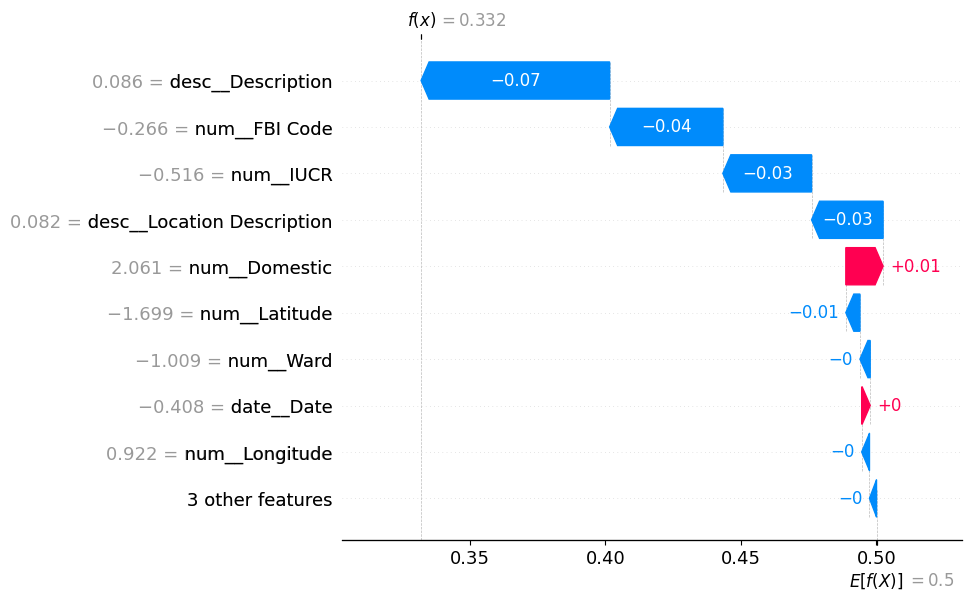

num__IUCR                    -0.184326
num__Domestic                -0.485291
num__Beat                     0.704702
num__District                 0.665354
num__Ward                     1.247329
num__Community Area           1.837842
num__FBI Code                -0.612652
num__Latitude                 1.468069
num__Longitude               -3.864445
desc__Description             0.016137
desc__Location Description    0.134030
date__Date                   -1.077673
Name: 1123, dtype: float64


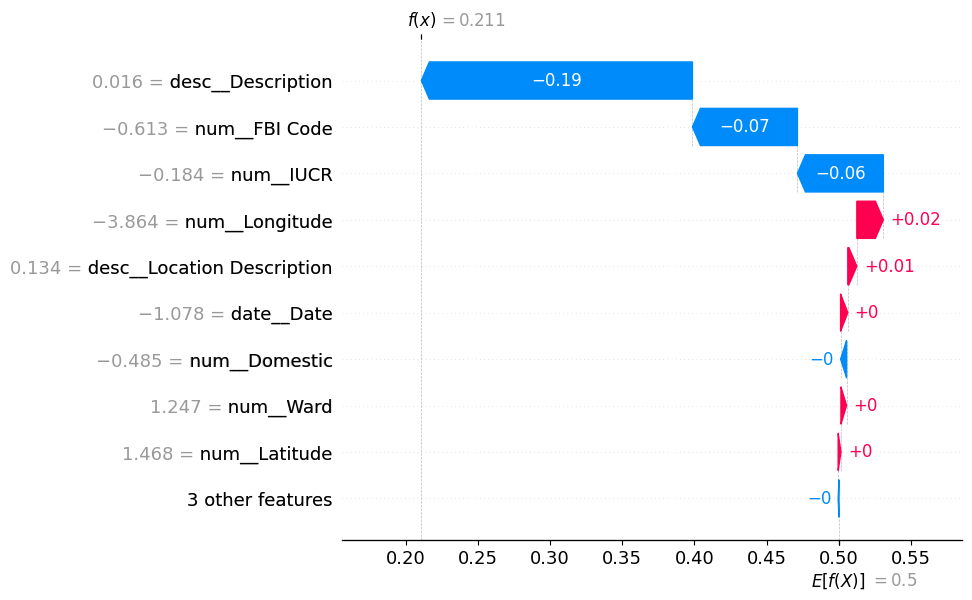

num__IUCR                    -0.554538
num__Domestic                -0.485291
num__Beat                    -0.058035
num__District                -0.041207
num__Ward                     0.965310
num__Community Area          -0.621777
num__FBI Code                -0.959291
num__Latitude                 0.559848
num__Longitude               -0.985220
desc__Description             0.108981
desc__Location Description    0.217986
date__Date                   -0.123960
Name: 88, dtype: float64


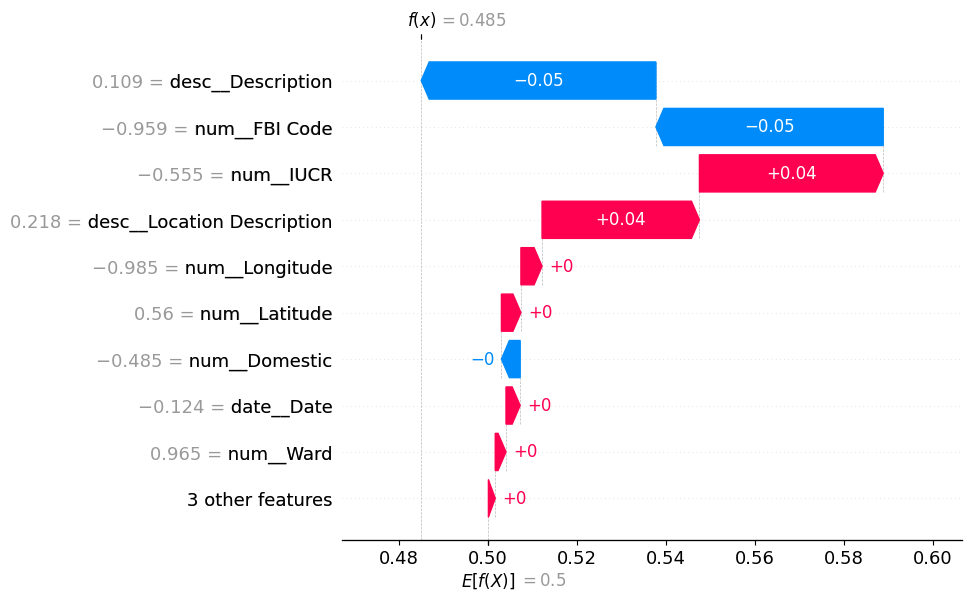

num__IUCR                    -0.452410
num__Domestic                -0.485291
num__Beat                    -1.032644
num__District                -1.030392
num__Ward                    -1.149835
num__Community Area           0.306381
num__FBI Code                -0.785972
num__Latitude                -0.967465
num__Longitude                1.855888
desc__Description             0.043657
desc__Location Description    0.081583
date__Date                    1.101715
Name: 99, dtype: float64


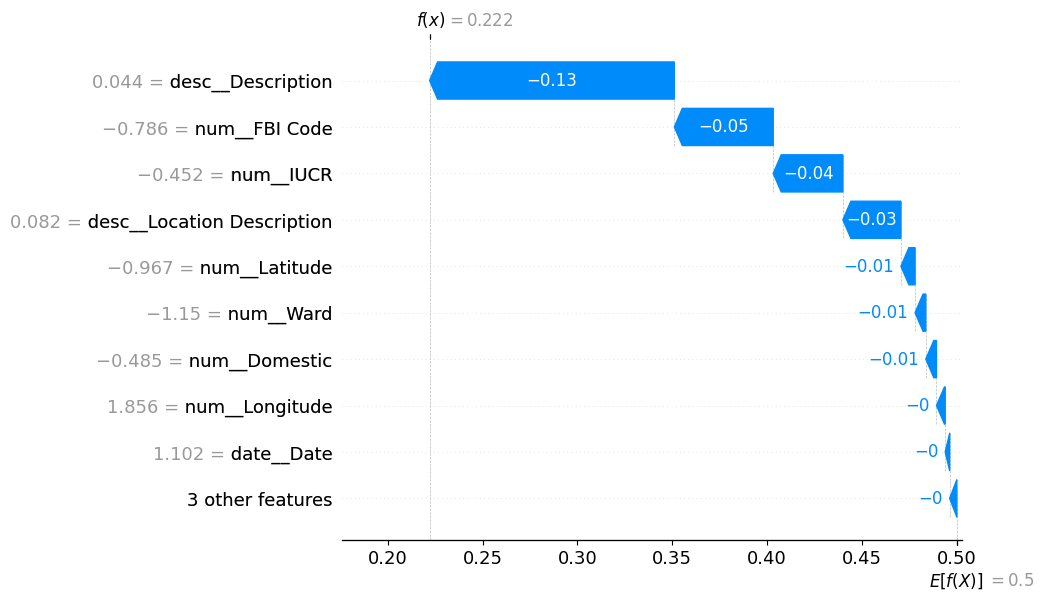

num__IUCR                    -0.184326
num__Domestic                -0.485291
num__Beat                     0.365707
num__District                 0.382730
num__Ward                     0.683291
num__Community Area          -0.714593
num__FBI Code                -0.612652
num__Latitude                 1.044616
num__Longitude               -0.441761
desc__Description             0.016137
desc__Location Description    0.134030
date__Date                    0.213634
Name: 1000, dtype: float64


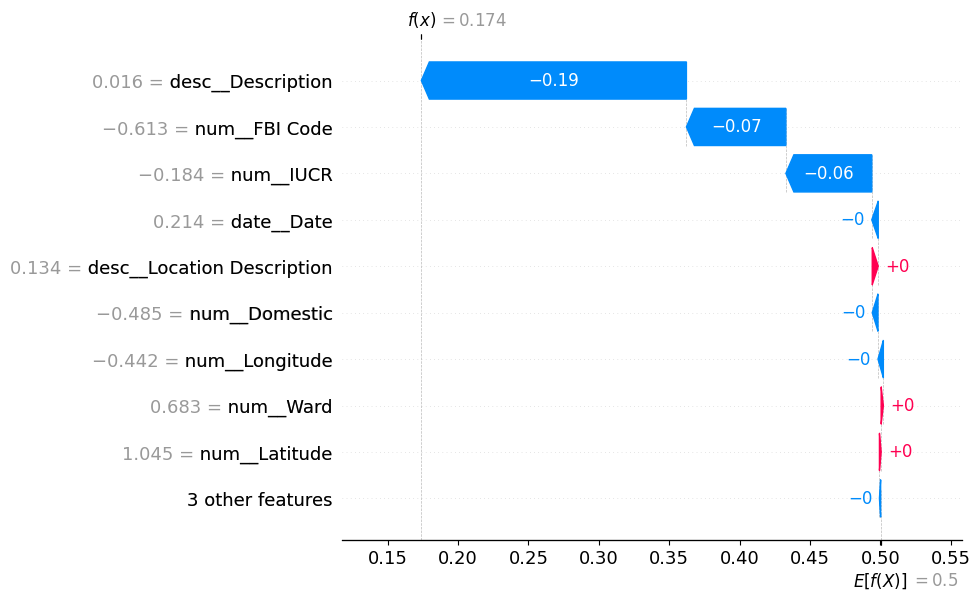

num__IUCR                    -1.048579
num__Domestic                -0.485291
num__Beat                    -0.736024
num__District                -0.747768
num__Ward                    -1.079330
num__Community Area           0.352789
num__FBI Code                 0.947228
num__Latitude                -1.087362
num__Longitude                1.036542
desc__Description             0.936059
desc__Location Description    0.189829
date__Date                   -0.419358
Name: 43, dtype: float64


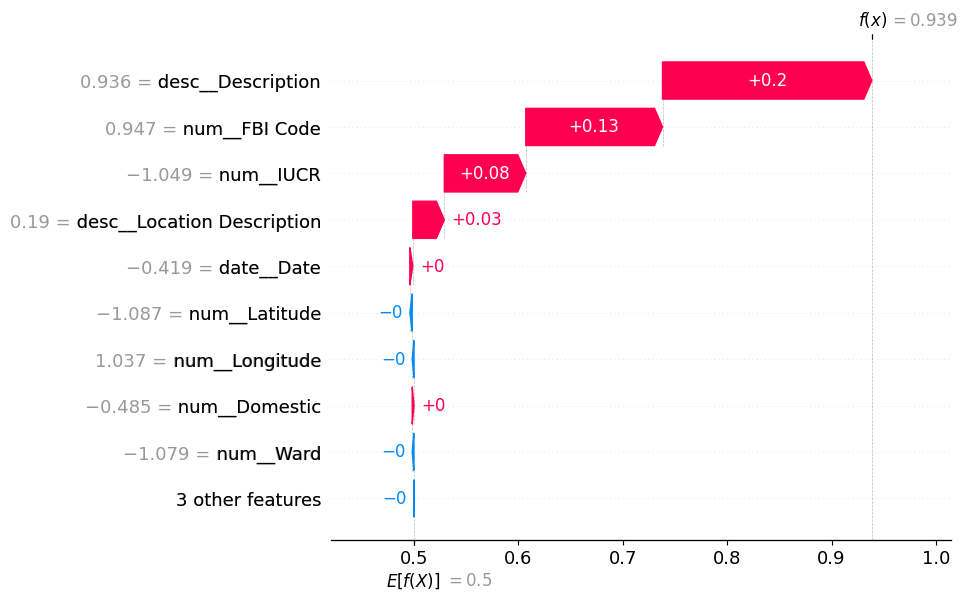

num__IUCR                    -0.133262
num__Domestic                -0.485291
num__Beat                     0.393957
num__District                 0.382730
num__Ward                    -1.572863
num__Community Area          -0.668185
num__FBI Code                -0.612652
num__Latitude                 0.858031
num__Longitude               -0.442666
desc__Description             0.168312
desc__Location Description    0.106921
date__Date                   -0.693624
Name: 21, dtype: float64


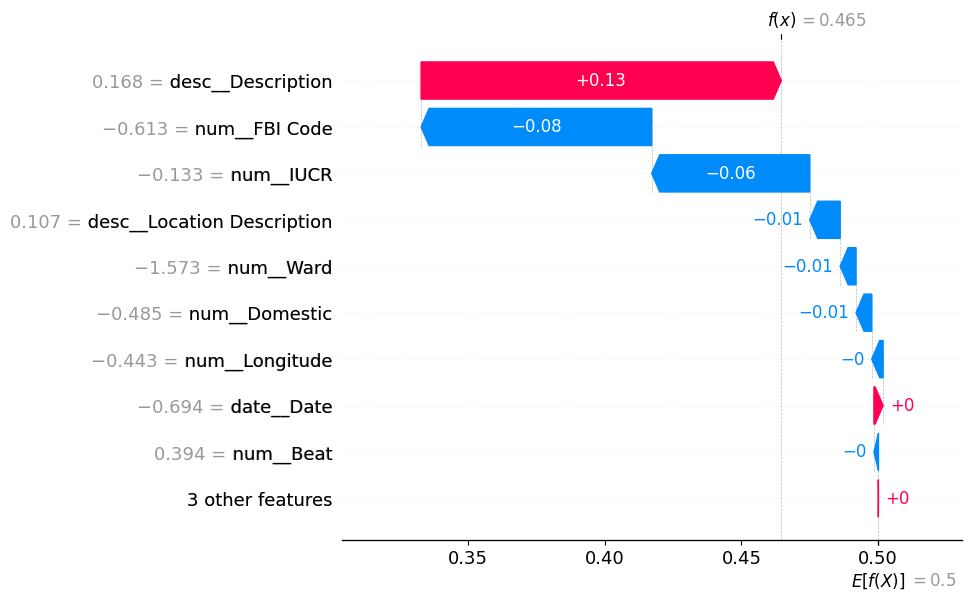

num__IUCR                     0.505034
num__Domestic                -0.485291
num__Beat                    -0.734611
num__District                -0.747768
num__Ward                    -1.079330
num__Community Area           0.352789
num__FBI Code                 2.853747
num__Latitude                -1.229904
num__Longitude                1.056877
desc__Description             0.021545
desc__Location Description    0.134030
date__Date                    0.742387
Name: 22, dtype: float64


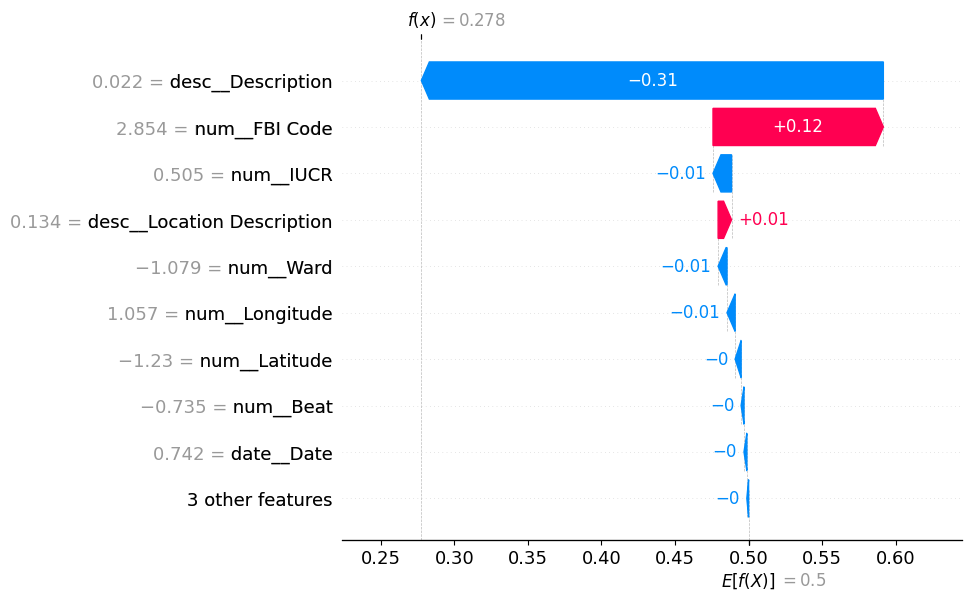

num__IUCR                    -0.197092
num__Domestic                -0.485291
num__Beat                     0.958947
num__District                 0.947979
num__Ward                     1.317834
num__Community Area          -1.317896
num__FBI Code                -0.612652
num__Latitude                 0.535872
num__Longitude                0.554772
desc__Description             0.010454
desc__Location Description    0.140329
date__Date                   -1.121565
Name: 23, dtype: float64


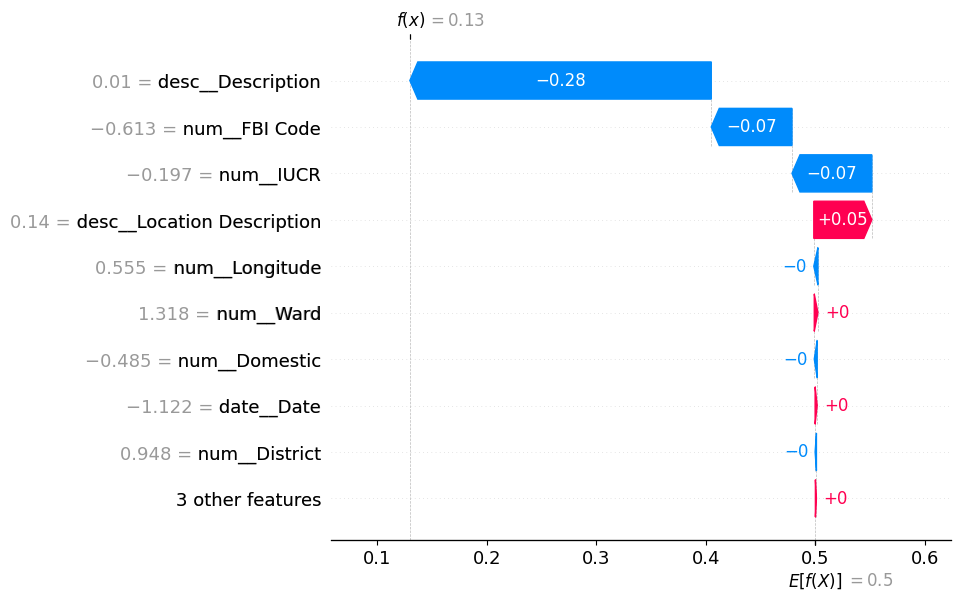

num__IUCR                     0.441205
num__Domestic                -0.485291
num__Beat                    -0.464828
num__District                -0.465143
num__Ward                    -0.021758
num__Community Area           1.373763
num__FBI Code                 0.773908
num__Latitude                -0.735722
num__Longitude               -0.653301
desc__Description             0.044838
desc__Location Description    0.067030
date__Date                   -0.493618
Name: 24, dtype: float64


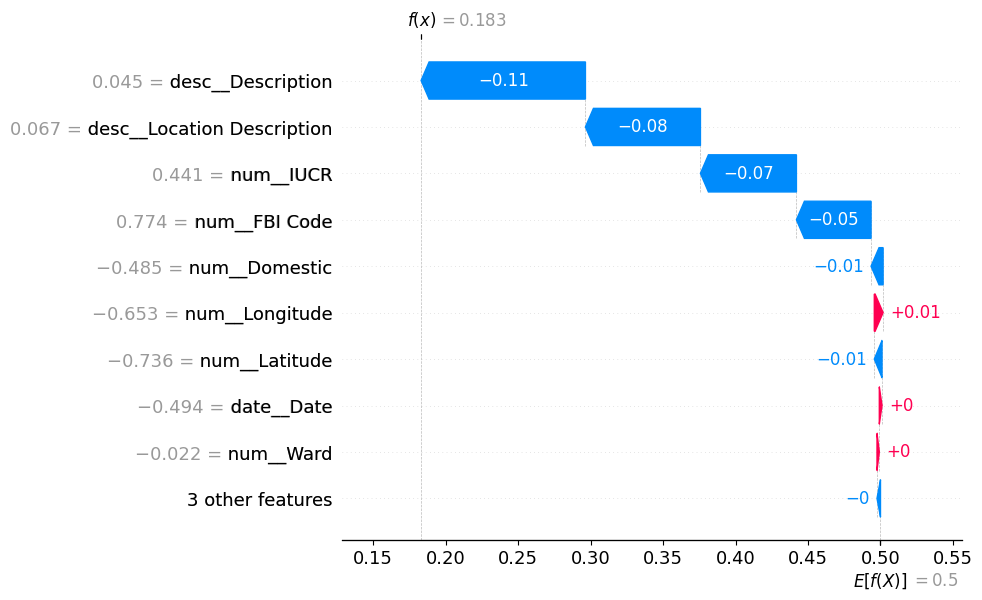

num__IUCR                     0.453970
num__Domestic                -0.485291
num__Beat                    -0.478953
num__District                -0.465143
num__Ward                    -0.726806
num__Community Area           1.188131
num__FBI Code                 0.773908
num__Latitude                -0.588053
num__Longitude               -0.890613
desc__Description             0.021545
desc__Location Description    0.134030
date__Date                   -0.148709
Name: 25, dtype: float64


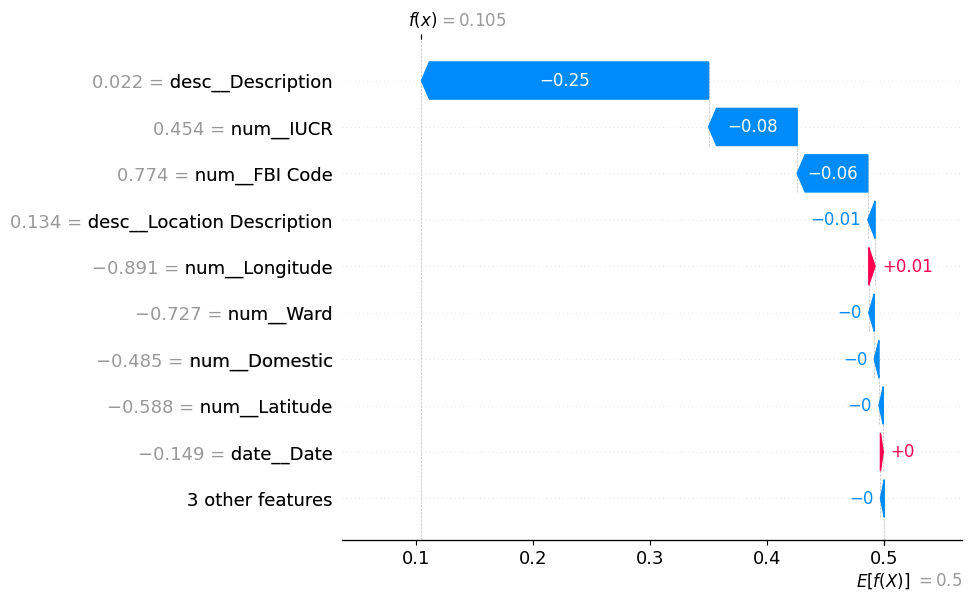

num__IUCR                     0.441205
num__Domestic                 2.060617
num__Beat                    -1.032644
num__District                -1.030392
num__Ward                    -1.149835
num__Community Area           0.306381
num__FBI Code                 0.773908
num__Latitude                -1.030054
num__Longitude                1.698557
desc__Description             0.044838
desc__Location Description    0.081583
date__Date                    1.199137
Name: 26, dtype: float64


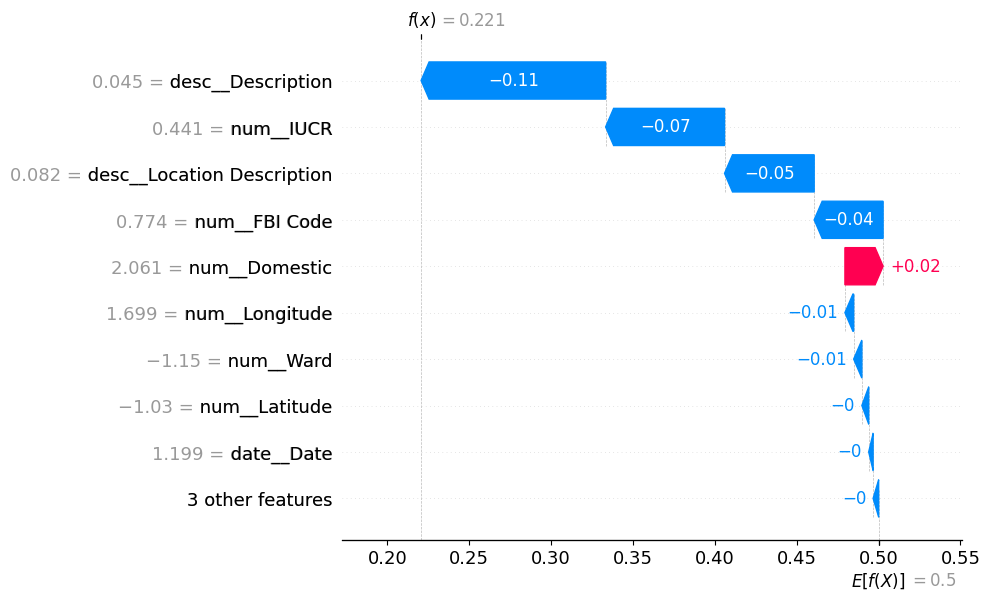

num__IUCR                     2.376519
num__Domestic                -0.485291
num__Beat                    -0.464828
num__District                -0.465143
num__Ward                    -0.515291
num__Community Area           1.373763
num__FBI Code                 2.853747
num__Latitude                -0.712295
num__Longitude               -0.425768
desc__Description             0.009199
desc__Location Description    0.067030
date__Date                   -0.552208
Name: 27, dtype: float64


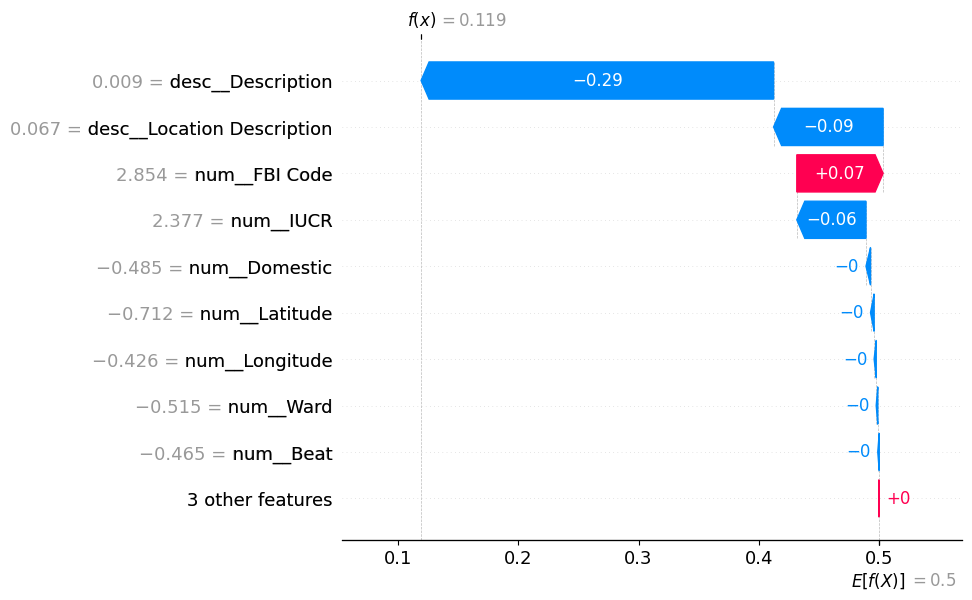

num__IUCR                    -0.197092
num__Domestic                -0.485291
num__Beat                     1.779595
num__District                 1.795852
num__Ward                     1.881872
num__Community Area          -1.596343
num__FBI Code                -0.612652
num__Latitude                 1.710545
num__Longitude               -0.606577
desc__Description             0.010454
desc__Location Description    0.134030
date__Date                    0.787297
Name: 28, dtype: float64


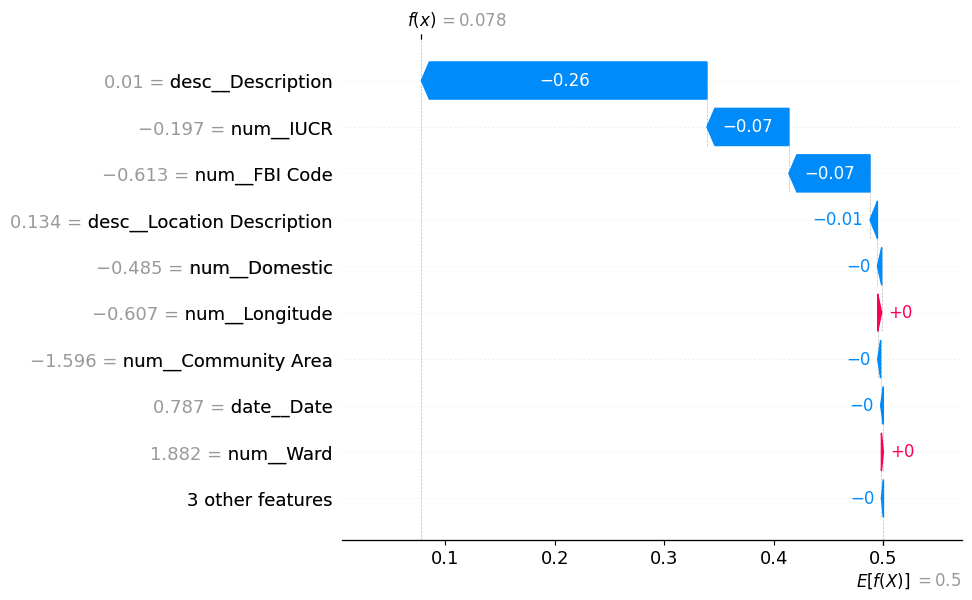

num__IUCR                    -1.048579
num__Domestic                -0.485291
num__Beat                    -1.440849
num__District                -1.454328
num__Ward                    -1.361349
num__Community Area          -0.157698
num__FBI Code                 0.947228
num__Latitude                 0.034198
num__Longitude                0.828268
desc__Description             0.936059
desc__Location Description    0.134030
date__Date                   -1.319397
Name: 29, dtype: float64


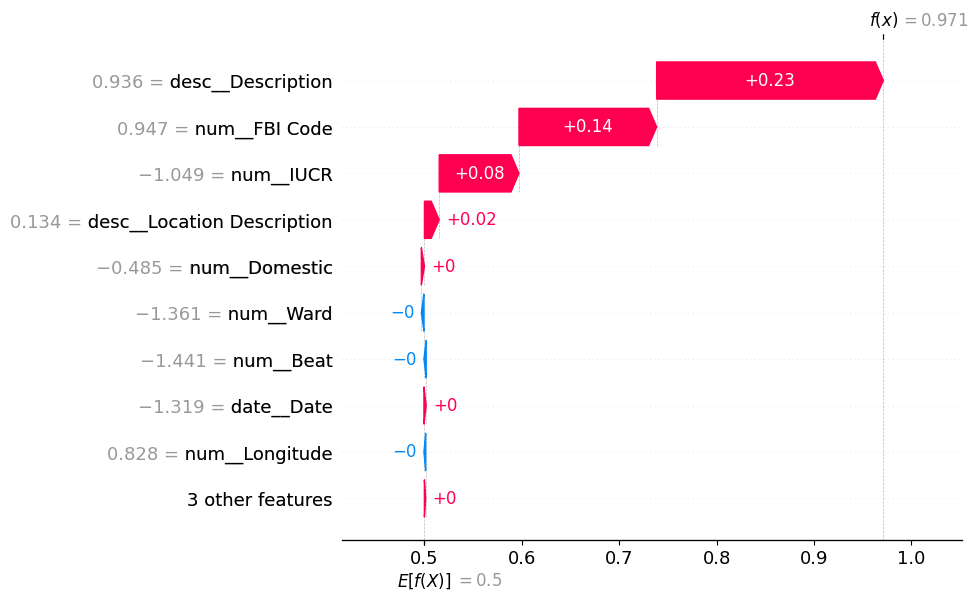

num__IUCR                    -0.060496
num__Domestic                -0.485291
num__Beat                     0.398194
num__District                 0.382730
num__Ward                     0.612786
num__Community Area          -0.575369
num__FBI Code                -0.439332
num__Latitude                 0.752567
num__Longitude               -0.145123
desc__Description             0.032526
desc__Location Description    0.134030
date__Date                   -0.497242
Name: 30, dtype: float64


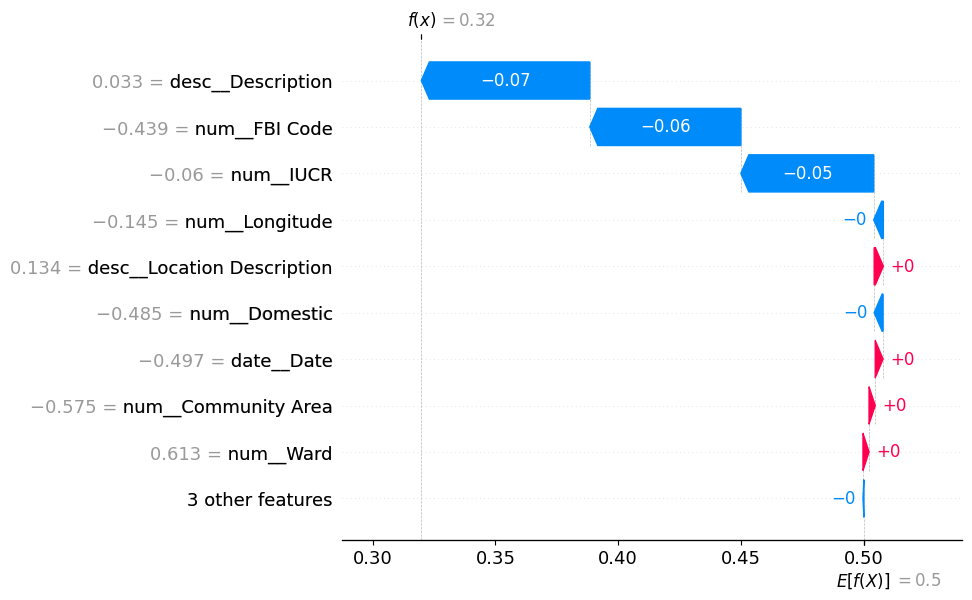

num__IUCR                     2.376519
num__Domestic                 2.060617
num__Beat                     1.213193
num__District                 1.230603
num__Ward                     1.176824
num__Community Area          -1.596343
num__FBI Code                 2.853747
num__Latitude                 1.611258
num__Longitude               -0.462187
desc__Description             0.009199
desc__Location Description    0.067030
date__Date                    1.393469
Name: 31, dtype: float64


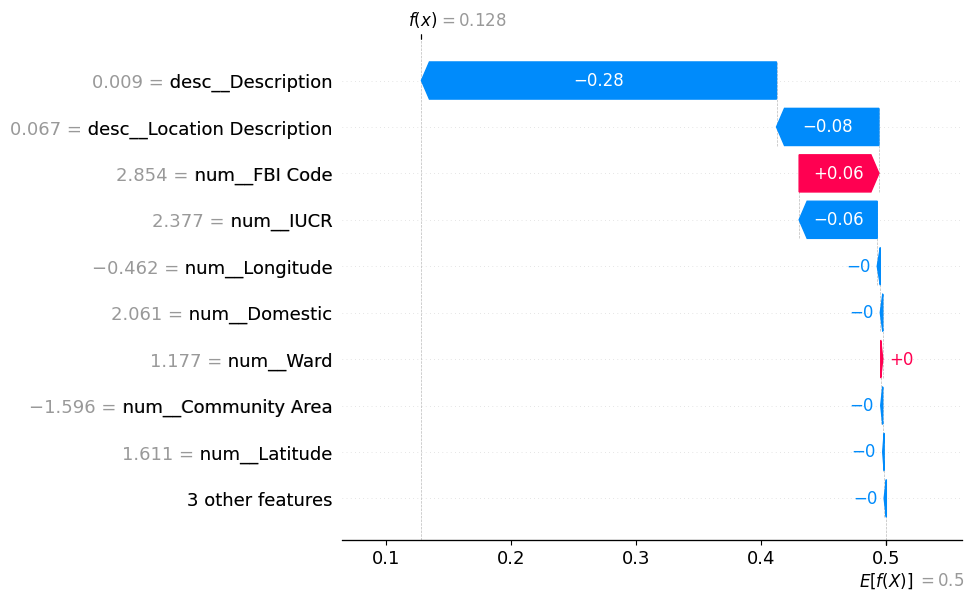

num__IUCR                    -0.516240
num__Domestic                -0.485291
num__Beat                     0.819112
num__District                 0.806667
num__Ward                     0.824300
num__Community Area          -0.714593
num__FBI Code                -0.266012
num__Latitude                 1.119779
num__Longitude               -0.719423
desc__Description             0.085514
desc__Location Description    0.070754
date__Date                    1.233491
Name: 32, dtype: float64


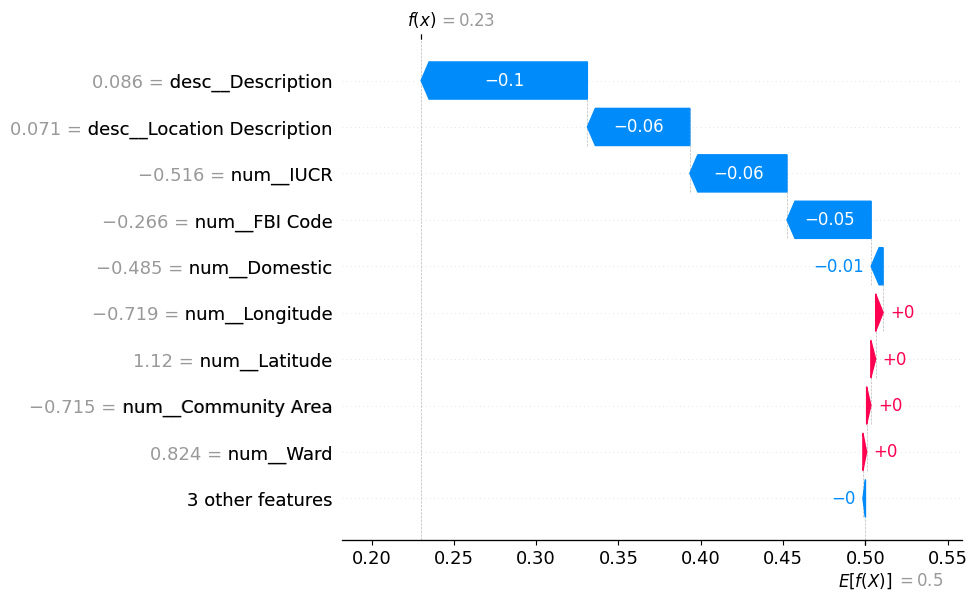

num__IUCR                    -0.590282
num__Domestic                -0.485291
num__Beat                    -0.038261
num__District                -0.041207
num__Ward                     0.260262
num__Community Area          -0.389738
num__FBI Code                 2.853747
num__Latitude                 0.354576
num__Longitude               -0.350401
desc__Description             0.488269
desc__Location Description    0.134030
date__Date                   -0.193797
Name: 33, dtype: float64


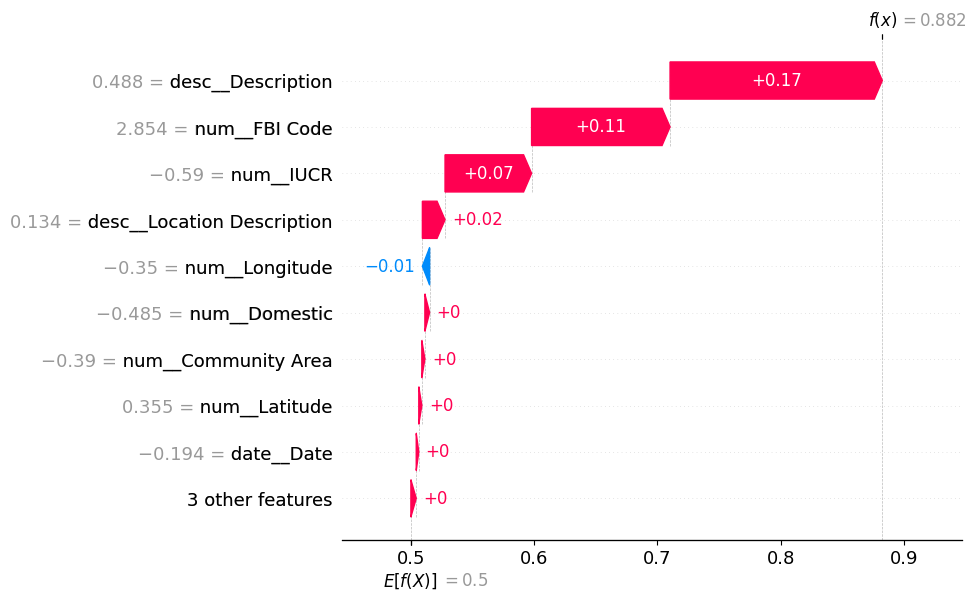

num__IUCR                     0.441205
num__Domestic                -0.485291
num__Beat                    -0.594776
num__District                -0.606455
num__Ward                    -1.220339
num__Community Area           1.512986
num__FBI Code                 0.773908
num__Latitude                -0.958916
num__Longitude                0.568185
desc__Description             0.044838
desc__Location Description    0.067030
date__Date                    0.743406
Name: 34, dtype: float64


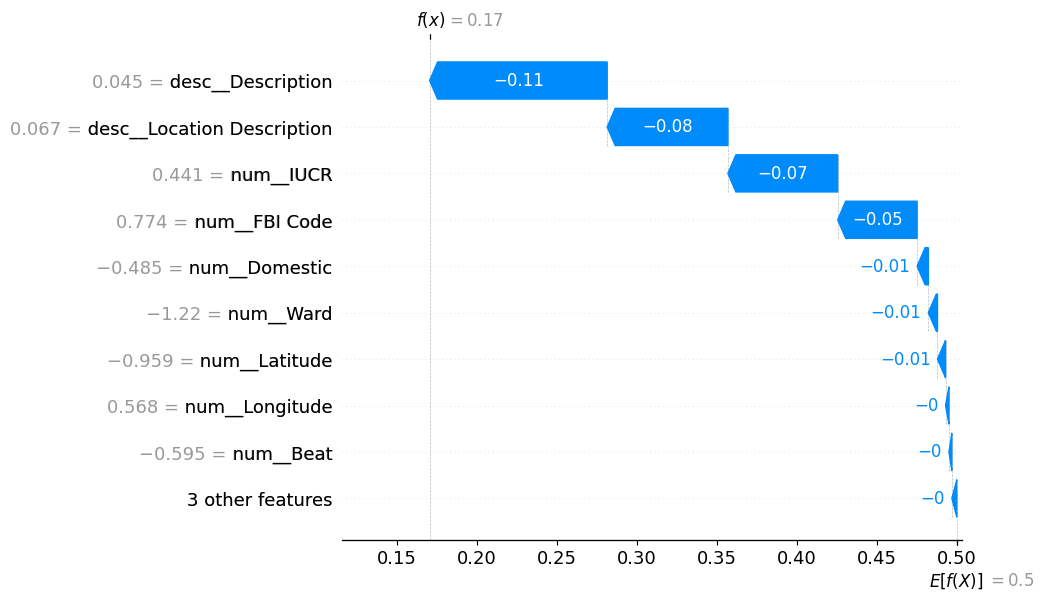

num__IUCR                     0.441205
num__Domestic                -0.485291
num__Beat                    -0.594776
num__District                -0.606455
num__Ward                    -1.220339
num__Community Area           1.512986
num__FBI Code                 0.773908
num__Latitude                -0.958916
num__Longitude                0.568185
desc__Description             0.044838
desc__Location Description    0.067030
date__Date                    0.743406
Name: 34, dtype: float64


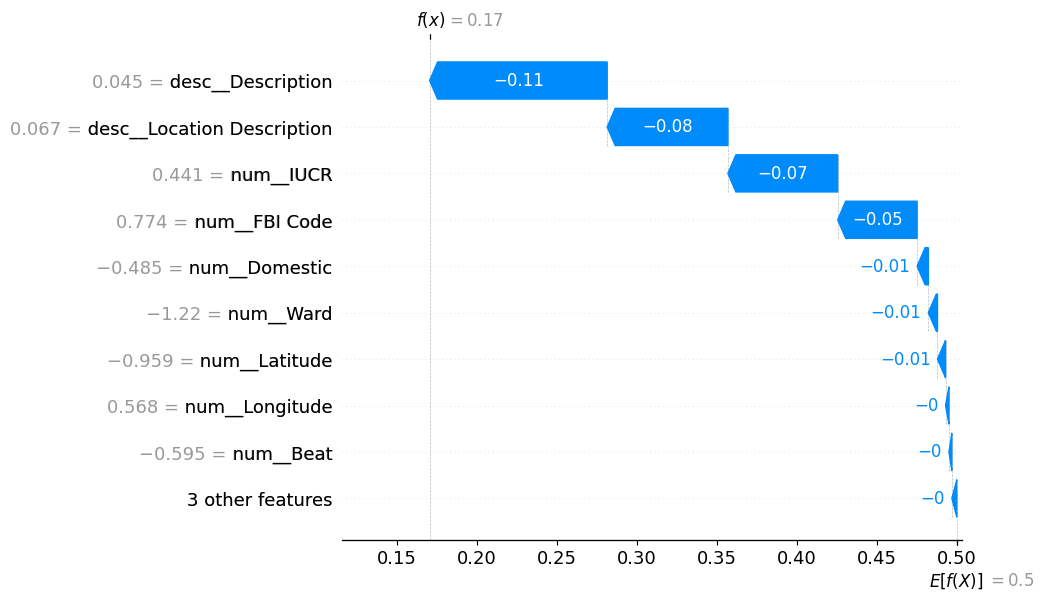

num__IUCR                    -0.184326
num__Domestic                -0.485291
num__Beat                     0.522492
num__District                 0.524042
num__Ward                     0.330767
num__Community Area          -0.528961
num__FBI Code                -0.612652
num__Latitude                 0.392177
num__Longitude               -1.417553
desc__Description             0.016137
desc__Location Description    0.134030
date__Date                    1.095151
Name: 2134, dtype: float64


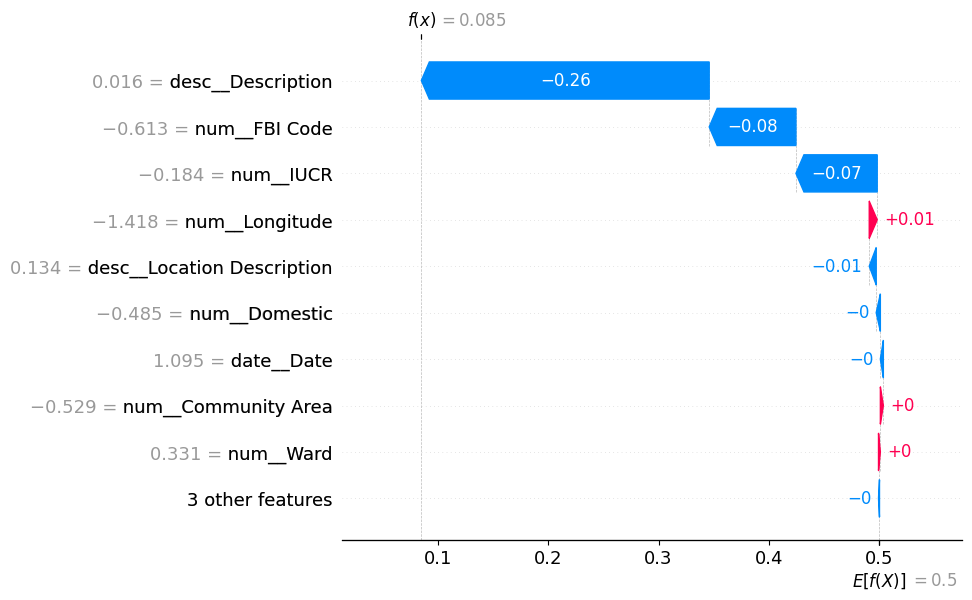

num__IUCR                    -0.516240
num__Domestic                 2.060617
num__Beat                    -0.902696
num__District                -0.889080
num__Ward                    -1.008825
num__Community Area           0.584828
num__FBI Code                -0.266012
num__Latitude                -1.699191
num__Longitude                0.921713
desc__Description             0.085514
desc__Location Description    0.081583
date__Date                   -0.407613
Name: 3214, dtype: float64


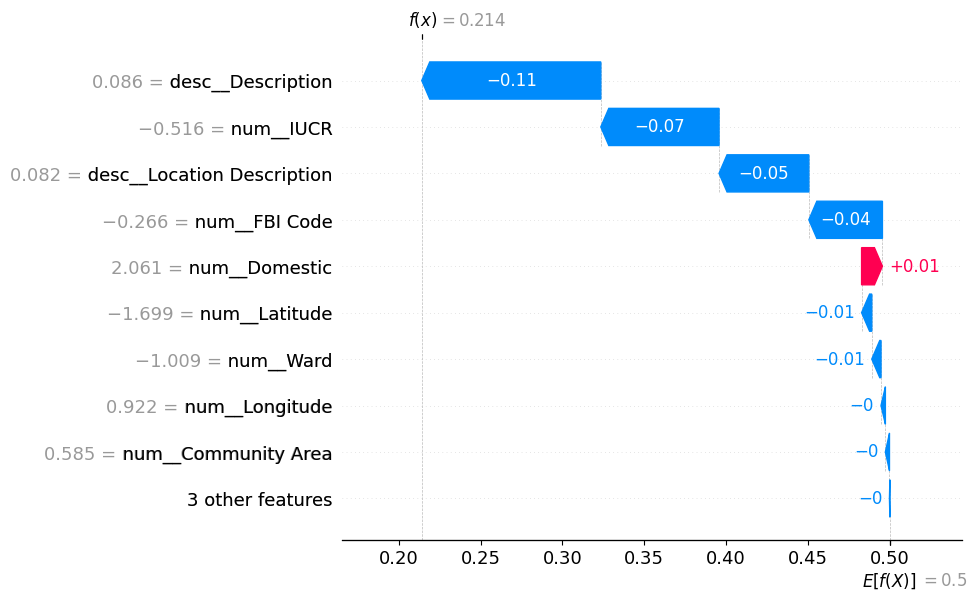

num__IUCR                    -0.184326
num__Domestic                -0.485291
num__Beat                     0.704702
num__District                 0.665354
num__Ward                     1.247329
num__Community Area           1.837842
num__FBI Code                -0.612652
num__Latitude                 1.468069
num__Longitude               -3.864445
desc__Description             0.016137
desc__Location Description    0.134030
date__Date                   -1.077673
Name: 1123, dtype: float64


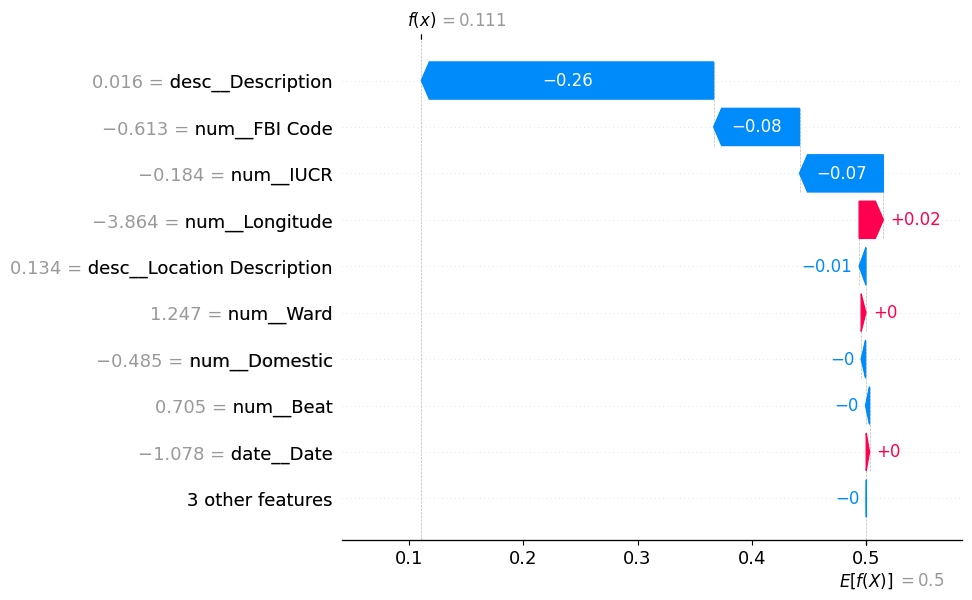

num__IUCR                    -0.554538
num__Domestic                -0.485291
num__Beat                    -0.058035
num__District                -0.041207
num__Ward                     0.965310
num__Community Area          -0.621777
num__FBI Code                -0.959291
num__Latitude                 0.559848
num__Longitude               -0.985220
desc__Description             0.108981
desc__Location Description    0.217986
date__Date                   -0.123960
Name: 88, dtype: float64


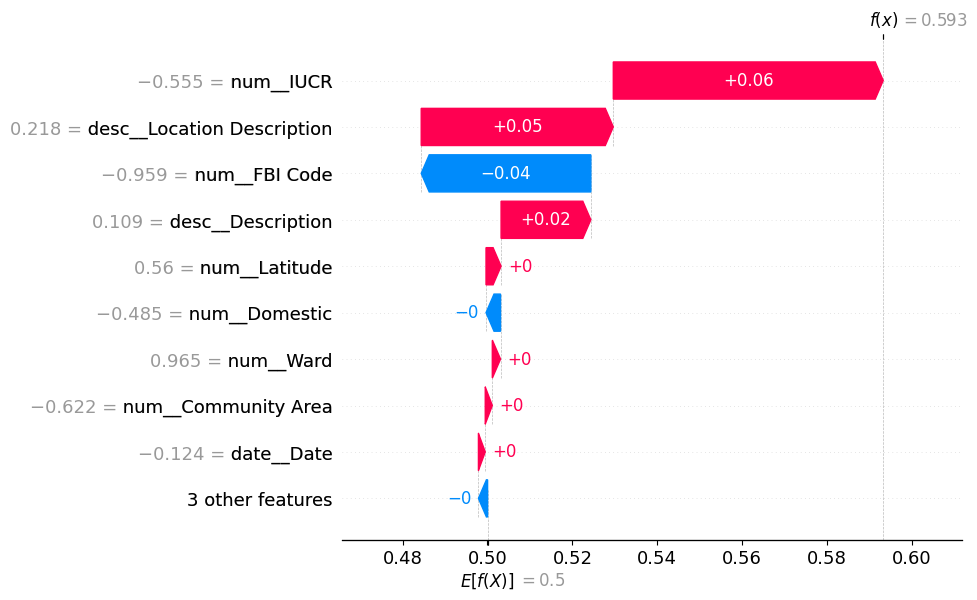

num__IUCR                    -0.452410
num__Domestic                -0.485291
num__Beat                    -1.032644
num__District                -1.030392
num__Ward                    -1.149835
num__Community Area           0.306381
num__FBI Code                -0.785972
num__Latitude                -0.967465
num__Longitude                1.855888
desc__Description             0.043657
desc__Location Description    0.081583
date__Date                    1.101715
Name: 99, dtype: float64


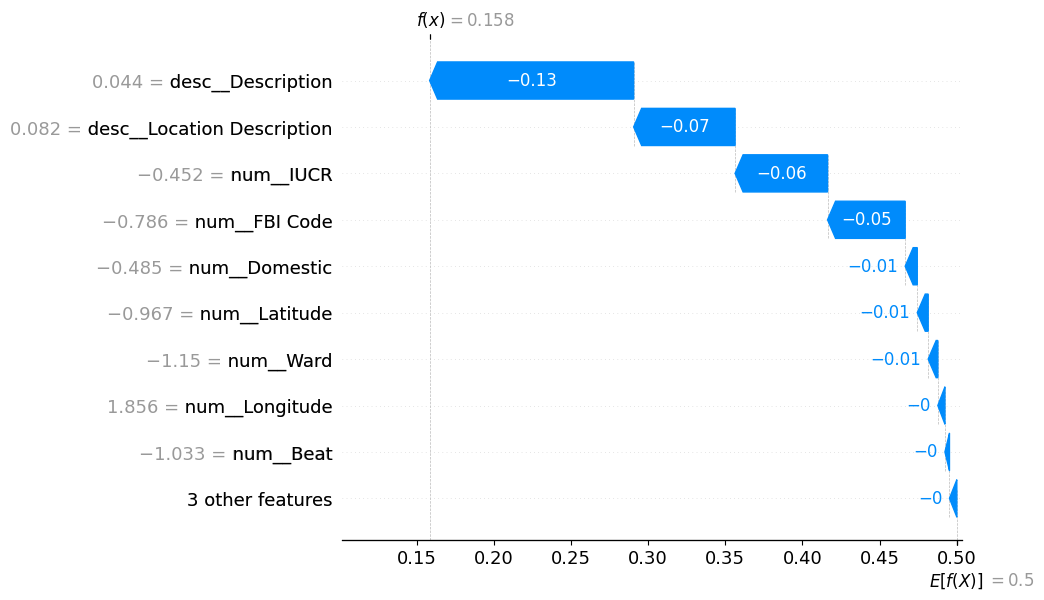

num__IUCR                    -0.184326
num__Domestic                -0.485291
num__Beat                     0.365707
num__District                 0.382730
num__Ward                     0.683291
num__Community Area          -0.714593
num__FBI Code                -0.612652
num__Latitude                 1.044616
num__Longitude               -0.441761
desc__Description             0.016137
desc__Location Description    0.134030
date__Date                    0.213634
Name: 1000, dtype: float64


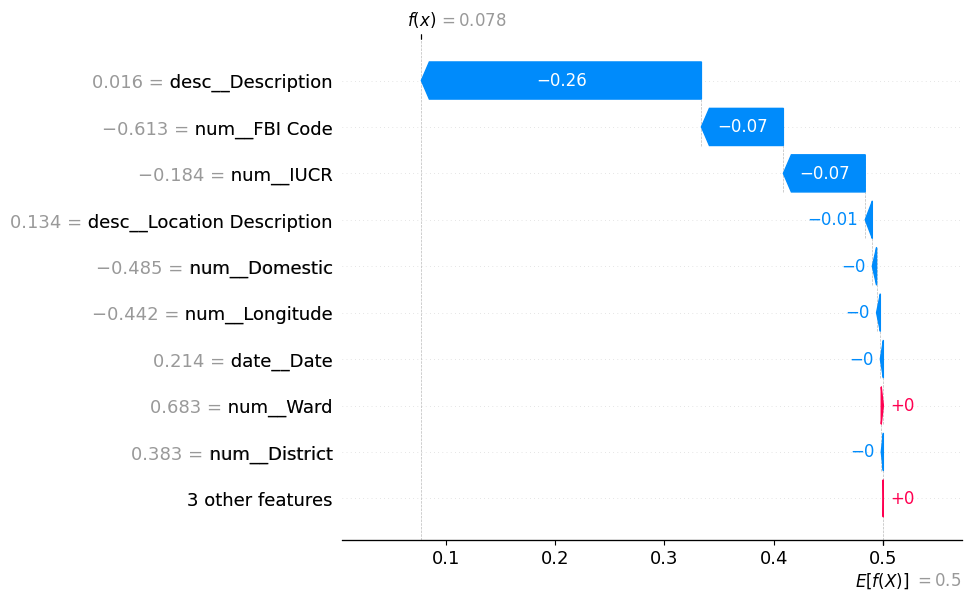

num__IUCR                    -1.048579
num__Domestic                -0.485291
num__Beat                    -0.736024
num__District                -0.747768
num__Ward                    -1.079330
num__Community Area           0.352789
num__FBI Code                 0.947228
num__Latitude                -1.087362
num__Longitude                1.036542
desc__Description             0.936059
desc__Location Description    0.189829
date__Date                   -0.419358
Name: 43, dtype: float64


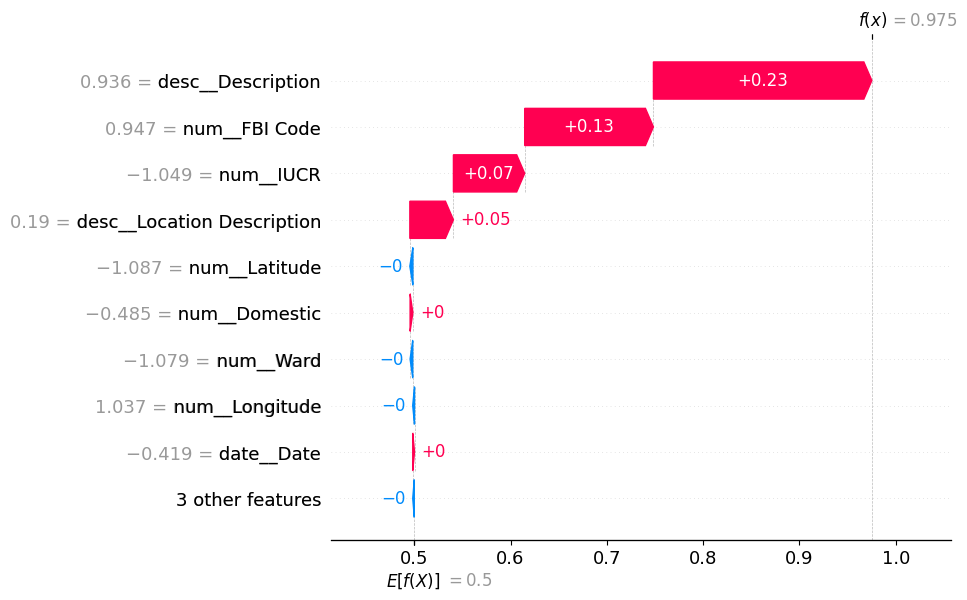

In [9]:
for key, best_model in best_models.items():
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    model=best_model.named_steps['clf']
    x_val_transformed_name = pd.DataFrame(best_model.named_steps['ct'].transform(X_test), columns=feature_names)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_val_transformed_name)

    # Create directory for saving plots
    output_dir = f'Graphs/{key}_waterfall_plot'
    os.makedirs(output_dir, exist_ok=True)
    
    for row in something:
        fig = plt.figure(figsize=(6, 3.3))
        print(x_val_transformed_name.iloc[row, :])
        explanation5 = shap.Explanation(
            values=shap_values[row, :, 1],  # Select SHAP values for the specific class
            base_values=explainer.expected_value[1],  # Use expected value for the same class
            #feature_names=X_test.columns,
            data=x_val_transformed_name.iloc[row, :]
        )
        shap.plots.waterfall(explanation5)
        fig.tight_layout()
        fig.savefig(f'{output_dir}/Details{row}.jpg', format='jpeg', dpi=300, bbox_inches='tight')


In [10]:
# for key, best_model in best_models.items():
#     if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
#         feature_names = best_model.named_steps['ct'].get_feature_names_out()
#     else:
#         feature_names = best_model.named_steps['ct'].get_feature_names()
#     model=best_model.named_steps['clf']
#     x_val_transformed_name = pd.DataFrame(best_model.named_steps['ct'].transform(X_test), columns=feature_names)
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(x_val_transformed_name)

#     # Create directory for saving plots
#     output_dir = f'Graphs/{key}_force_plots'
#     os.makedirs(output_dir, exist_ok=True)
#     plt.figure()

#     shap.plots.force(
#         base_value=explainer.expected_value[1],
#         shap_values=shap_values[1, :, 1],
#         features=x_val_transformed_name.iloc[1, :]
#     )
#     plt.savefig(f'{output_dir}/Details_ahhh.jpg', format='jpeg', dpi=300, bbox_inches='tight')
#     plt.close()  # Ensure plots are closed

    
#     # for row in rows_selection:
#     #     # plt.figure()  # Explicitly create a new figure
#     #     # shap.force_plot(explainer.expected_value[1], shap_values[row,:,1], x_val_transformed_name.iloc[row,:])
#     #     plt.figure()
#     #     shap.plots.force(
#     #         base_value=explainer.expected_value[1],
#     #         shap_values=shap_values[row, :, 1],
#     #         features=x_val_transformed_name.iloc[row, :]
#     #     )
#     #     plt.savefig(f'{output_dir}/Details_{row}.jpg', format='jpeg', dpi=300, bbox_inches='tight')
#     #     plt.close()  # Ensure plots are closed
#     #     # plt.savefig(f'{output_dir}/Details_{row}.jpg', format='jpeg', dpi=300, bbox_inches ='tight')
#     #     # plt.close()  # Close the plot to free up memory